In [33]:
save_path = '/Users/maori2/Documents/revision_stuff/All_dataset/sessions_files'
fig_path='/Users/maori2/Documents/revision_stuff/new_figures'

import scipy.io as sio
import scipy.stats as sts
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn.axisgrid")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.spatial.distance import mahalanobis as mahal
from scipy.spatial.distance import seuclidean, canberra, euclidean, cosine, minkowski
from scipy.linalg import pinvh

from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from scipy.spatial.distance import cosine

import scipy.io
from zetapy import ifr, zetatest, zetatstest, zetatest2, zetatstest2, plotzeta, plottszeta, plotzeta2, plottszeta2
from scipy.stats import norm
from scipy.signal import convolve
import time
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

from sklearn import svm
from sklearn.model_selection import cross_val_predict, cross_val_score, LeaveOneOut
#from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import sem
from sklearn import set_config
from sklearn.model_selection import permutation_test_score

from sklearn.linear_model import LinearRegression

#import umap.umap_ as umap
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

plt.rcParams['axes.grid'] = False        # Disable grid lines globally
plt.rcParams['axes.linewidth'] = 1    # Make axes thicker
plt.rcParams['axes.edgecolor'] = 'black' # Make axes darker



In [64]:

import sys, seaborn as sns
print("python:", sys.executable)
print("seaborn:", sns.__version__)


python: /Users/maori2/opt/anaconda3/envs/ofc_schema/envs/ofc_schema/bin/python
seaborn: 0.13.2


In [35]:
def analyze_behave(Analysis_table):

    Analysis_table_f = Analysis_table[(Analysis_table.correction_trial==0) & (Analysis_table.odor_unpoke_early==0)].reset_index()
    max_unpoke = 5000 #trim the sampling odor windo to 5 sec
    Analysis_table_f.loc[Analysis_table_f.odor_unpoke-Analysis_table_f.odor_poke>max_unpoke,'odor_unpoke']=Analysis_table_f.odor_poke+max_unpoke
    Analysis_table_f.loc[:,'pre_trial'] = Analysis_table_f['light_on'] - 1000

    y = np.array(Analysis_table_f.go_nogo)
    s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

    HitRate_cdnm = (y[cdnm_rule==1].astype(bool)==1)
    FaRate_cdnm = (y[cdnm_rule==0].astype(bool)==1)
    HitRate_disc =(y[disc_rule==1].astype(bool)==1)
    FaRate_disc = (y[disc_rule==0].astype(bool)==1)

    correct_cdnm = (np.average(HitRate_cdnm)+(1-np.average(FaRate_cdnm)))/2
    correct_disc = (np.average(HitRate_disc)+(1-np.average(FaRate_disc)))/2

    def calculate_d_prime(hits, false_alarms):
        if hits == 0:
            hits = 0.01
        if false_alarms == 0:
            false_alarms = 0.01
        if hits == 1:
            hits = 1 - 0.01
        if false_alarms == 1:
            false_alarms = 1 - 0.01


        hits = np.array(hits)
        false_alarms = np.array(false_alarms)

        # z-scores
        hitZ = sts.norm.ppf(hits)
        faZ  = sts.norm.ppf(false_alarms)

        # d-prime
        dPrime = hitZ-faZ

        return dPrime

    def find_first_index(Analysis_table_f): # Custom function to find the first index in vehave_crit where Value = 1
        index = (Analysis_table_f['behave_crit'] == 1).idxmax()
        return index if not (index==0 or pd.isna(index)) else 500

    dPrime_cdnm = calculate_d_prime(np.average(HitRate_cdnm), np.average(FaRate_cdnm))
    dPrime_disc = calculate_d_prime(np.average(HitRate_disc), np.average(FaRate_disc))
    tr_to_crit = index

    Analysis_table_mod = Analysis_table_f.copy()

    Analysis_table_mod.loc[:,'cdnm_rule']=cdnm_rule
    Analysis_table_mod.loc[:,'disc_rule']=disc_rule
    Analysis_table_mod.loc[:,'time_to_poke']=Analysis_table_f['odor_poke']-Analysis_table_f['light_on']
    Analysis_table_mod.loc[:,'time_to_unpoke']=Analysis_table_f['odor_unpoke']-Analysis_table_f['odor_poke']
    Analysis_table_mod.loc[:,'time_to_water']=Analysis_table_f['water_poke']-Analysis_table_f['odor_poke']
    Analysis_table_mod.loc[:,'ITI']=Analysis_table_mod['light_on'].diff()
    Analysis_table_mod.loc[:,'odor_before']=s1[:,1]
    Analysis_table_mod.loc[0,'odor_before']=Analysis_table_mod.loc[1,'odor_before'] #puting the same odor on the first trial to avoide nans


    behave_dict = {
        "Analysis_table_mod":Analysis_table_mod,
        "correct_cdnm": correct_cdnm,
        "correct_disc": correct_disc,
        "dPrime_cdnm": dPrime_cdnm,
        "dPrime_disc": dPrime_disc,
        "tr_to_crit": tr_to_crit,
        "HitRate_cdnm": HitRate_cdnm,
        "FaRate_cdnm": FaRate_cdnm,
        "HitRate_disc":HitRate_disc,
        "FaRate_disc": FaRate_disc
    }
    return behave_dict

def calculate_d_prime(hits, false_alarms):
    if hits == 0:
        hits = 0.01
    if false_alarms == 0:
        false_alarms = 0.01
    if hits == 1:
        hits = 1 - 0.01
    if false_alarms == 1:
        false_alarms = 1 - 0.01


    hits = np.array(hits)
    false_alarms = np.array(false_alarms)

    # z-scores
    hitZ = sts.norm.ppf(hits)
    faZ  = sts.norm.ppf(false_alarms)

    # d-prime
    dPrime = hitZ-faZ

    return dPrime

def bin_performance(Analysis_table_f,  bin_num=4):
    y = np.array(Analysis_table_f.go_nogo)
    s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

    cdnm_only = (cdnm_rule==1) & (disc_rule==0)
    disc_only = (cdnm_rule==0) & (disc_rule==1)

    HitRate_cdnm = (y[cdnm_rule==1].astype(bool)==1)
    FaRate_cdnm = (y[cdnm_rule==0].astype(bool)==1)
    HitRate_disc =(y[disc_rule==1].astype(bool)==1)
    FaRate_disc = (y[disc_rule==0].astype(bool)==1)

    HitRate_cdnm_only = (y[cdnm_only==1].astype(bool)==1)
    FaRate_cdnm_only =  (y[cdnm_only==0].astype(bool)==1)
    HitRate_disc_only = (y[disc_only==1].astype(bool)==1)
    FaRate_disc_only = (y[disc_only==0].astype(bool)==1)

    correct_cdnm_bin =[]
    correct_disc_bin = []
    dPrime_cdnm_bin =[]
    dPrime_disc_bin = []
    HitRate_cdnm_bin =[]
    FARate_cdnm_bin = []
    HitRate_disc_bin =[]
    FARate_disc_bin = []
    correct_cdnm_only_bin =[]
    correct_disc_only_bin = []

    hist, bin_edges_1 = np.histogram(np.arange(0, len(HitRate_cdnm)), bins=bin_num); bined_day_1 = np.floor(bin_edges_1).astype(int)
    hist, bin_edges_2 = np.histogram(np.arange(0, len(FaRate_cdnm)), bins=bin_num); bined_day_2 = np.floor(bin_edges_2).astype(int)
    hist, bin_edges_3 = np.histogram(np.arange(0, len(HitRate_disc)), bins=bin_num); bined_day_3 = np.floor(bin_edges_3).astype(int)
    hist, bin_edges_4 = np.histogram(np.arange(0, len(FaRate_disc)), bins=bin_num); bined_day_4 = np.floor(bin_edges_4).astype(int)

    hist, bin_edges_5 = np.histogram(np.arange(0, len(HitRate_cdnm_only)), bins=bin_num); bined_day_5 = np.floor(bin_edges_5).astype(int)
    hist, bin_edges_6 = np.histogram(np.arange(0, len(FaRate_cdnm_only)), bins=bin_num); bined_day_6 = np.floor(bin_edges_6).astype(int)
    hist, bin_edges_7 = np.histogram(np.arange(0, len(HitRate_disc_only)), bins=bin_num); bined_day_7 = np.floor(bin_edges_7).astype(int)
    hist, bin_edges_8 = np.histogram(np.arange(0, len(FaRate_disc_only)), bins=bin_num); bined_day_8 = np.floor(bin_edges_8).astype(int)

    for ii in range(len(bined_day_1) - 1):

        #correct_cdnm_bin.append(np.average(raw_correct_cdnm_rule[start_index1:end_index1]))
        #correct_disc_bin.append(np.average(raw_correct_disc_rule[start_index1:end_index1]))
        correct_cdnm_bin.append((np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]])+(1-np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]])))/2)
        correct_disc_bin.append((np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]])+(1-np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]])))/2)

        dPrime_cdnm_bin.append(calculate_d_prime(np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]]), np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]])))
        dPrime_disc_bin.append(calculate_d_prime(np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]]), np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]])))

        HitRate_cdnm_bin.append(np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]]))
        FARate_cdnm_bin.append(np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]]))
        HitRate_disc_bin.append(np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]]))
        FARate_disc_bin.append(np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]]))

        correct_cdnm_only_bin.append((np.average(HitRate_cdnm_only[bined_day_5[ii]:bined_day_5[ii+1]])+(1-np.average(FaRate_cdnm_only[bined_day_6[ii]:bined_day_6[ii+1]])))/2)
        correct_disc_only_bin.append((np.average(HitRate_disc_only[bined_day_7[ii]:bined_day_7[ii+1]])+(1-np.average(FaRate_disc_only[bined_day_8[ii]:bined_day_8[ii+1]])))/2)

    return correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin
def running_average_crossing_threshold(Table, Win, T, X):
    # Create logical variable 'A' where 'B' is 'Hit' or 'CR'
    Table['A'] = ((Table['score'] == 'Hit') | (Table['score'] == 'CR')).astype(int)

    # Calculate the running average of the column 'A' with a window size 'Win'
    Table['Running_Avg'] = Table['A'].rolling(window=Win).mean()

    # Determine when the running average crosses the threshold 'T'
    Table['Crossed_Threshold'] = (Table['Running_Avg'] > T).astype(int)

    # Find consecutive crossings of length X
    Table['Consecutive_Crossings'] = Table['Crossed_Threshold'].rolling(window=X).sum()

    # Determine where exactly the threshold is reached in X consecutive rows
    #crossing_points = (Table['Consecutive_Crossings'] >= X) & (Table['Crossed_Threshold'] == 1)
    crossing_points = Table[(Table['Consecutive_Crossings'] >= X) & (Table['Crossed_Threshold'] == 1)]

    # Find the first index where the condition is met
    first_crossing_index = crossing_points.index[0] if not crossing_points.empty else None


    return Table, first_crossing_index
#correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin = bin_performance(Analysis_table_f,  bin_num=10)
def divide_intervals(start_times, end_times, num_intervals):
    # Check if the input arrays have the same length
    if len(start_times) != len(end_times):
        raise ValueError("Input arrays must have the same length")

    # Calculate the duration of each interval
    interval_durations = (end_times - start_times) / num_intervals

    # Create a list to store the divided intervals
    divided_intervals = []

    # Iterate through each start and end time pair
    for start, end in zip(start_times, end_times):
        # Calculate the boundaries of each subinterval
        subinterval_boundaries = np.linspace(start, end, num_intervals + 1)

        divided_intervals.append(subinterval_boundaries)

    return divided_intervals

def calc_PETH_equal_bins (Analysis_table, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5):
    start_times = np.array(Analysis_table[event_start])/1000
    end_times = np.array(Analysis_table[event_end])/1000

    time_intervals = divide_intervals(start_times, end_times, bin_num)
    ntrials=len(time_intervals)
    temp1=[]
    for (trial_idx, trial) in enumerate(time_intervals):
        binduration=np.round(np.diff(trial)[0],decimals=2)
        temp2=[]
        for (unit_idx, spikes_unit) in enumerate(spikeTime):
            spikeinds = spikes_unit[np.logical_and((spikes_unit >= trial[0]),(spikes_unit < trial[-1]))]
            spikes_bin =np.histogram(spikeinds,bins = trial)
            temp2.append((1/binduration)*spikes_bin[0])# moving to Hz - 08/15/2024
            #temp2.append(spikes_bin[0])
        temp1.append(np.array(temp2))
    spikes_all = np.array(temp1) # [Trials,units,bins]
    PETH = spikes_all.reshape((ntrials,-1))

    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    #Analysis_table['vals_and_ID']=Analysis_table['odor_ID']+(cdnm_rule-1)*-100
    Analysis_table.loc[:, 'vals_and_ID'] = Analysis_table['odor_ID'].copy() + (cdnm_rule.copy()-1)*-100

    #Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID"]].copy()
    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]].copy()

    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan).copy()


    return PETH, Trials, spikes_all


def calc_PETH(Analysis_table, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1):

    nbins = int((resp_win[1]-resp_win[0])/binduration)
    timebins=np.arange(resp_win[0],(resp_win[1]+binduration),binduration,dtype=float)
    nunits=spikeTime.size;
    temp=[]
    for (event_idx, event) in enumerate(events):
        stim_times = np.array(Analysis_table[event])
        stimulustimes = stim_times/1000; #moving to sec                
        ntrials=stimulustimes.size;
        temp1=[]
        for  (trial_idx, trial) in enumerate(stimulustimes):
            temp2=[]
            for (unit_idx, spikes_unit) in enumerate(spikeTime):
                spikeinds = spikes_unit[np.logical_and((spikes_unit >= (trial+resp_win[0])),(spikes_unit < (trial+resp_win[1])))]-trial
                spikes_bin =np.histogram(spikeinds,bins = timebins)
                temp2.append((1/binduration)*spikes_bin[0])# moving to Hz - 08/15/2024
            temp1.append(np.array(temp2))
        temp.append(np.array(temp1))
    spikes_all = np.array(temp)
    #PETH = spikes_all.reshape((ntrials,-1))
    PETH = np.swapaxes(spikes_all, 0, 1).reshape((ntrials,-1))

    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    #Analysis_table['vals_and_ID']=Analysis_table['odor_ID']+(cdnm_rule-1)*-100
    Analysis_table.loc[:, 'vals_and_ID'] = Analysis_table['odor_ID'].copy() + (cdnm_rule.copy()-1)*-100

    #Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID"]].copy()
    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]].copy()

    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan).copy()

    return PETH, Trials, spikes_all

def calc_responsivness(Analysis_table_f,spikeTime):
    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime,events = ['odor_unpoke'] , resp_win = (-.5, 0)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all = np.squeeze(spikes_all)
    T_statistic_cdnm=[];P_value_cdnm=[];T_statistic_disc=[];P_value_disc=[];T_statistic_resp=[];P_value_resp=[]
    cell_num = spikes_all.shape[1]
    FR = np.mean(spikes_all,axis=2)
    trials_idx = Analysis_table_f.cdnm_rule == True; FR_cdnm_go = FR[trials_idx,:]
    trials_idx = Analysis_table_f.cdnm_rule == False; FR_cdnm_nogo = FR[trials_idx,:]
    trials_idx = Analysis_table_f.disc_rule == True; FR_disc_go = FR[trials_idx,:]
    trials_idx = Analysis_table_f.disc_rule == False; FR_disc_nogo = FR[trials_idx,:]
    PETH, Trials, spikes_all_spont = calc_PETH(Analysis_table_f, spikeTime,events = ['light_on'] , resp_win = (-1, -.5)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all_spont = np.squeeze(spikes_all_spont)
    FR_spont = np.mean(spikes_all_spont,axis=2)

    for i in range(cell_num):
        t_statistic, p_value = ttest_ind(FR_cdnm_go[:,i], FR_cdnm_nogo[:,i])
        T_statistic_cdnm.append(t_statistic); P_value_cdnm.append(p_value)
        t_statistic, p_value = ttest_ind(FR_disc_go[:,i], FR_disc_nogo[:,i])
        T_statistic_disc.append(t_statistic); P_value_disc.append(p_value)
        t_statistic, p_value = ttest_rel(FR[:,i], FR_spont[:,i])
        T_statistic_resp.append(t_statistic); P_value_resp.append(p_value)


    responsiveness = pd.DataFrame({'FR_all':np.mean(FR[:,:],axis=0),'FR_spont':np.mean(FR_spont[:,:],axis=0),'FR_spont_std':np.std(FR_spont[:,:],axis=0),'FR_cdnm_go':np.mean(FR_cdnm_go,axis=0),'FR_cdnm_nogo':np.mean(FR_cdnm_nogo,axis=0),'FR_disc_go':np.mean(FR_disc_go,axis=0),'FR_disc_nogo':np.mean(FR_disc_nogo,axis=0),
                                   'T_statistic_cdnm':np.array(T_statistic_cdnm),'P_value_cdnm':np.array(P_value_cdnm),'T_statistic_disc':np.array(T_statistic_disc),'P_value_disc':np.array(P_value_disc),'T_statistic_resp':np.array(T_statistic_resp),'P_value_resp':np.array(P_value_resp)})
    return responsiveness

# 2)Dimensionality reduction

def runPCA(PETH,n_components=50):
    X = PETH[:,:]
    pca = PCA(n_components=n_components)
    H = pca.fit(X)  # Reconstruct signals based on orthogonal components
    Y = H.components_
    Y.shape # Y: NXT
    V_pca = pca.fit_transform(X)
    V_pca.shape #V:MXN (the Eigenvectors)
    exp_var = pca.explained_variance_ratio_

    return V_pca, exp_var

def run_Similarity(V_pca,Trials):

    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    av_LDA = np.empty([u_vals.shape[0],V_pca.shape[1]])
    for val_id, val in enumerate(u_vals):
        av_LDA [val_id,:] = np.mean(V_pca[Trials["vals_and_ID"]==val,:],0)
    cm = np.zeros([av_LDA.shape[0],av_LDA.shape[0]])

    for i, LDA_i in enumerate(av_LDA):
        for j, LDA_j in enumerate(av_LDA):
            cm[i,j] =  cosine(LDA_i, LDA_j)

    return  av_LDA, cm

def run_LDA(B,Trials):

    clf = LinearDiscriminantAnalysis(solver = 'svd',store_covariance=True)
    LDA_transformed = clf.fit(B, Trials["vals_and_ID"])
    # !!!!!!!!!!!!!!!
    LDA_coef = LDA_transformed.coef_ #
    B_LDA = np.dot( B,LDA_coef.transpose())
    #!!!!!!!!!!!!!!!
    B_LDA.shape # MXN
    LDA_exp_var = LDA_transformed.explained_variance_ratio_
    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    av_LDA = np.empty([u_vals.shape[0],B_LDA.shape[1]])
    for val_id, val in enumerate(u_vals):
        av_LDA [val_id,:] = np.mean(B_LDA[Trials["vals_and_ID"]==val,:],0)
    #av_LDA = av_LDA
    cm = np.zeros([av_LDA.shape[0],av_LDA.shape[0]])
    c_m = np.cov(av_LDA, rowvar=False)
    #C_inv = np.linalg.inv(c_m)
    var_i = np.var(B_LDA,axis = 0)

    for i, LDA_i in enumerate(av_LDA):
        for j, LDA_j in enumerate(av_LDA):
            cov = np.cov(LDA_i,LDA_j)
            #C_inv = np.linalg.inv(cov)
            #cm[i,j] = mahal(LDA_i, LDA_j, C_inv)
            #cm[i,j] = euclidean(LDA_i, LDA_j)
            cm[i,j] =  cosine(LDA_i, LDA_j)

    return B_LDA, av_LDA, cm, LDA_exp_var, LDA_transformed, LDA_coef

def calc_PETH_with_baseline(Analysis_table, spikeTime, events = ['odor_unpoke'],resp_win = (-2, 2), binduration = .05):

    nbins = int((resp_win[1]-resp_win[0])/binduration)
    timebins=np.arange(resp_win[0],(resp_win[1]+binduration),binduration,dtype=float)
    nunits=spikeTime.size;

    basline_time = np.array(Analysis_table['light_on'] - 1000)/1000 #moving to sec   


    temp=[]
    base=[]
    for (event_idx, event) in enumerate(events):
        stim_times = np.array(Analysis_table[event])
        stimulustimes = stim_times/1000; #moving to sec                
        ntrials=stimulustimes.size;
        temp1=[]
        base1=[]
        for  (trial_idx, trial) in enumerate(stimulustimes):
            temp2=[]
            base2=[]
            for (unit_idx, spikes_unit) in enumerate(spikeTime):
                spikeinds = spikes_unit[np.logical_and((spikes_unit >= (trial+resp_win[0])),(spikes_unit < (trial+resp_win[1])))]-trial
                spikeinds_baseline = spikes_unit[np.logical_and((spikes_unit >= basline_time[trial_idx]),(spikes_unit < (basline_time[trial_idx]+.5)))]-basline_time[trial_idx]
                baseline_fr = len(spikeinds_baseline)*2 #moving to Hz
                spikes_bin =np.histogram(spikeinds,bins = timebins)
                #temp2.append((1/binduration)*spikes_bin[0] - baseline_fr) # moving to Hz and substracting basline
                temp2.append((1/binduration)*spikes_bin[0]) # moving to Hz
                base2.append(baseline_fr)
            temp1.append(np.array(temp2))
            base1.append(np.array(base2))
        temp.append(np.array(temp1))
        base.append(np.array(base1))
    spikes_all = np.array(temp)
    baseline_all = np.array(base)
    PETH = np.swapaxes(spikes_all, 0, 1).reshape((ntrials,-1))


    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    Analysis_table.loc[:,'vals_and_ID']=Analysis_table.loc[:,'odor_ID']+(cdnm_rule-1)*-100


    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]]
    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan)

    return PETH, Trials, spikes_all,baseline_all

def calc_zScore (spikes_all,baseline_all,trials_idx):
    baseline_mean = np.mean(np.squeeze(baseline_all)[trials_idx,:],0)
    baseline_std = np.std(np.squeeze(baseline_all)[trials_idx,:],0)
    baseline_std[baseline_std==0] = 1 #to overcome dividing by zero
    nbins = spikes_all.shape[3]
    temp = baseline_mean[:, np.newaxis]# Add a new axis using np.newaxis
    replicated_baseline_mean = np.tile(temp, (1, nbins))# Replicate the vector along the new axis using np.tile
    temp = baseline_std[:, np.newaxis]# Add a new axis using np.newaxis
    replicated_baseline_std = np.tile(temp, (1, nbins))# Replicate the vector along the new axis using np.tile
    mean_fr = np.mean(np.squeeze(spikes_all[:,trials_idx,:,:]),0)
    z_score = (mean_fr - replicated_baseline_mean)/replicated_baseline_std

    return z_score


def prep_for_svm(Analysis_table_f,spikeTime):


    PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
    PETH = np.squeeze(spikes_all.mean(axis = 2)) # mean over all bins

    # PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    # [PETH, temp] = runPCA(PETH)

    newDF_temp = Analysis_table_f.loc[:,["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"]]

    df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
    newDF = pd.concat([df1_reset, newDF_temp], axis=1)     # Concatenate along the x-axis (columns)

    PETH, Trials, spikes_all_before = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on'] , resp_win = (0, .3)) #Trials by events X bins X units (number of neurons × 4 epochs × 3 time points)
    PETH, Trials, spikes_all_response = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (0, .3)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all_concat = np.concatenate((np.squeeze(spikes_all_before),np.squeeze(spikes_all),np.squeeze(spikes_all_response)),axis=2)

    newDF_bins=[]
    for i in range(spikes_all_concat.shape[2]): #run over differnt bins
        PETH = np.squeeze(spikes_all_concat[:,:,i]) # select a specific bin
        df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
        newDF_bins.append( pd.concat([df1_reset, newDF_temp], axis=1))

    return newDF, newDF_bins

def prep_for_svm_pca(Analysis_table_f,spikeTime):


    #     PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
    #     PETH = np.squeeze(spikes_all.mean(axis = 2)) # mean over all bins

    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    [PETH, temp] = runPCA(PETH)

    newDF_temp = Analysis_table_f.loc[:,["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"]]

    df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
    # Concatenate along the x-axis (columns)
    newDF = pd.concat([df1_reset, newDF_temp], axis=1)

    return newDF



def calc_svm(newDF,decode_var = 'cdnm_rule',reg_var = 'go_nogo'):

    #dilute the dataframe so number of trial repetiations will be equal to the min number
    class_IDs, counts = np.unique(newDF[decode_var],return_counts=True)
    min_reps = np.min(counts)
    df = pd.DataFrame()
    for class_ID in class_IDs:
        df = pd.concat([df, newDF[newDF[decode_var] == class_ID].tail(min_reps)])

    #seperate the dataset into response variable and feature variables:

    X = df.drop(["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"],axis=1)
    y = df[decode_var]

    # SVM Classifier
    clf = make_pipeline(StandardScaler(), svm.SVC())

    y_pred = cross_val_predict(clf, X, np.ravel(y), cv=LeaveOneOut())

    cm = confusion_matrix(y, y_pred,normalize='true')
    # score_m = cross_val_score(clf, X, y, cv=LeaveOneOut()).mean()
    # score_s = cross_val_score(clf, X, y, cv=LeaveOneOut()).std()

    score_m = np.round(cross_val_score(clf, X, y, cv=LeaveOneOut(),scoring='accuracy').mean(),2)
    score_s = np.round(cross_val_score(clf, X, y, cv=LeaveOneOut(),scoring='accuracy').std(),2)


    D_df = pd.concat((df.reset_index(),pd.DataFrame(y_pred,columns=['y_pred'])),axis=1)

    X_residuals = regress_out_variable(X, df[reg_var])
    score_reg = np.round(cross_val_score(clf, X_residuals, y, cv=LeaveOneOut(),scoring='accuracy').mean(),2)

    return cm,min_reps,score_m,score_s,D_df,score_reg

def calc_svm_with_permutation(df_forSVM,decode_var = 'cdnm_rule',n_permutations=1000):

    #dilute the dataframe so number of trial repetiations will be equal to the min number
    class_IDs, counts = np.unique(df_forSVM[decode_var],return_counts=True)
    min_reps = np.min(counts)
    df = pd.DataFrame()
    for class_ID in class_IDs:
        df = pd.concat([df, df_forSVM[df_forSVM[decode_var] == class_ID].tail(min_reps)])

    #seperate the dataset into response variable and feature variables:

    X = df.drop(["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"],axis=1)
    y = df[decode_var]

    # SVM Classifier
    clf = make_pipeline(StandardScaler(), svm.SVC())

    # Perform permutation test
    score, permutation_scores, p_value = permutation_test_score(
        clf, X, y, scoring="accuracy", n_permutations=n_permutations, random_state=42)

    y_pred = cross_val_predict(clf, X, np.ravel(y), cv=LeaveOneOut())
    D_df = pd.concat((df.reset_index(),pd.DataFrame(y_pred,columns=['y_pred'])),axis=1) #data frame with trials info and predictions    
    cm = confusion_matrix(y, y_pred,normalize='true')

    return score,permutation_scores,p_value,D_df,cm

def regress_out_variable(X, variable):
    if isinstance(variable, pd.Series):
        variable = variable.to_numpy().reshape(-1, 1)
    else:
        variable = np.array(variable).reshape(-1, 1)

    regressor = LinearRegression()
    regressor.fit(variable, X)
    X_residuals = X - regressor.predict(variable)

    return X_residuals

def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]

    return pd.cut([value], bins=bins, labels=labels, right=False)[0]


def run_zeta_test(Analysis_table_f,spikeTime): #Calculate Zeta-tests For responsivness over all df_sessions and save files

    # create a T by 2 array with stimulus onsets and offsets so we can also compute the t-test
    AlldblZetaP=[]
    AlldblZetaTwoSample2a_cdnm = []
    AlldblZetaTwoSample2a_disc = []
    for (unit_idx, spikes_unit) in enumerate(spikeTime):

        vecSpikeTimes1=spikes_unit

        vecStimulusStartTimes = Analysis_table_f['odor_poke'].values.flatten()/1000
        vecStimulusStopTimes = Analysis_table_f['odor_unpoke'].values.flatten()/1000
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

        arrEventTimes = np.transpose(np.array([vecStimulusStartTimes, vecStimulusStopTimes]))

        dblZetaP = zetatest(vecSpikeTimes1, arrEventTimes,intResampNum = 50)[0]  # use [0] to return only the p-value

        dblZetaTwoSample2a_cdnm, dZETA2a_cdnm = zetatest2(vecSpikeTimes1,arrEventTimes[cdnm_rule==True,:],vecSpikeTimes1,arrEventTimes[cdnm_rule==False,:],
                                                          intResampNum=500,boolPlot=False)
        dblZetaTwoSample2a_disc, dZETA2a_disc = zetatest2(vecSpikeTimes1,arrEventTimes[disc_rule==True,:],vecSpikeTimes1,arrEventTimes[disc_rule==False,:],
                                                          intResampNum=500,boolPlot=False)

        #print(f'\nresponse p value: {dblZetaP} \ncdnm p-value: {dblZetaTwoSample2a_cdnm} \ndisc p-value: {dblZetaTwoSample2a_disc}')
        AlldblZetaP.append(dblZetaP)
        AlldblZetaTwoSample2a_cdnm.append(dblZetaTwoSample2a_cdnm)
        AlldblZetaTwoSample2a_disc.append(dblZetaTwoSample2a_disc)
    result_dict_Zeta = {'p_responsive': np.array(AlldblZetaP), 'p_cdnm': np.array(AlldblZetaTwoSample2a_cdnm), 'p_disc': np.array(AlldblZetaTwoSample2a_disc)}

    return result_dict_Zeta


def plot_cm(average_cm, cmap='cividis', vmin=0, vmax=.2, figsize=(3, 3)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)

    mask = np.tril(np.ones_like(average_cm, dtype=bool), k=-1)  # Mask out the upper triangular part of the matrix
    masked_matrix = np.where(mask, average_cm, np.nan)  # Mask out the upper triangular part of the matrix
    masked_matrix = average_cm
    plt.imshow(masked_matrix, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.gca().axes.get_xaxis().set_visible(False)  # Hide x-axis ticks and labels
    plt.gca().axes.get_yaxis().set_visible(False)  # Hide x-axis ticks and labels

    plt.gca().spines['top'].set_visible(False)  # Hide top spine/frame
    plt.gca().spines['right'].set_visible(False)  # Hide right spine/frame
    plt.gca().spines['bottom'].set_visible(False)  # Hide bottom spine/frame
    plt.gca().spines['left'].set_visible(False)  # Hide left spine/frame

    #ax1.axis('off')
    colorbar = plt.colorbar(mappable=None, cax=None, ax=None)

    ax1.axhline(y=7.5, color='w', linestyle='-')
    ax1.axvline(x=7.5, color='w', linestyle='-')

    ax1.axhline(y=3.5, color='w', linestyle='--')
    ax1.axvline(x=3.5, color='w', linestyle='--')

    ax1.axhline(y=11.5, color='w', linestyle='--')
    ax1.axvline(x=11.5, color='w', linestyle='--')
    ax1.set_title(f'{session_title}')
    cbar_axes = colorbar.ax
    cbar_axes.remove()
    return fig, ax1


def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]
    return pd.cut([value], bins=bins, labels=labels, right=False)[0]

def find_first_index(df_group): # Custom function to find the first index in vehave_crit where Value = 1
    index = (df_group['behave_crit'] == 1).idxmax()
    return index if not (index==0 or pd.isna(index)) else 500

def plot_zscore(zScore_all ,zScore_all2 ,color_go):
    color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
    z_score = np.concatenate(zScore_all, axis=0)
    max_indices = np.argmax(z_score, axis=1)
    sorted_indices = np.argsort(max_indices)
    z_score_sorted = z_score[sorted_indices,:] 
    z_score2 = np.concatenate(zScore_all2, axis=0)
    z_score_sorted2 = z_score2[sorted_indices,:] 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3, 5),sharex=True)
    for ax in axes[0]:
        ax.axis('off')
    for ax in axes[1]:
        ax.axis('off')
    gs = GridSpec(2, 2, height_ratios=[8, 1])
    ax0 = fig.add_subplot(gs[0, 0])
    im = ax0.imshow(z_score_sorted-z_score_sorted2,cmap = 'bone',vmin = -2, vmax = 2, aspect='auto')
    ax0.axvline(x=10, color='black', linestyle='--')
    plt.xlim((0,z_score_sorted.shape[1]))
    ax0.grid(False)
    ax0.set_yticks([0, len(z_score)])
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    ax0.xaxis.set_visible(False)
    ax0.set_ylabel('Units')

    ax1 = fig.add_subplot(gs[1, 0])
    window_size = 5
    y_smoothed = np.convolve(np.mean(z_score_sorted,0), np.ones(window_size)/window_size, mode='same')

    ax1.plot(y_smoothed,color_go)
    y_smoothed2 = np.convolve(np.mean(z_score_sorted2,0), np.ones(window_size)/window_size, mode='same')
    ax1.plot(y_smoothed2,"#b8b8b8")

    ax1.axvline(x=10, color='k', linestyle='--')
    ax1.grid(False)
    specific_ticks = [0,10, 20]
    specific_labels = [ '-1','0', '1']
    ax1.set_xticks(specific_ticks)
    ax1.set_xticklabels(specific_labels)
    ax1.yaxis.set_visible(True)
    ax1.xaxis.set_visible(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(True)
    ax1.set_xlabel('Time from\n un-poke (sec)')
    ax1.set_ylabel('z score')
    plt.tight_layout()
    heat_map = z_score_sorted-z_score_sorted2
    return fig, heat_map, y_smoothed, y_smoothed2

def compute_stats(selected_keys, data_dict):
    selected_values = np.concatenate([data_dict[key] for key in selected_keys if key in data_dict])
    mean = np.mean(selected_values)
    sem = np.std(selected_values, ddof=1) / np.sqrt(len(selected_values))
    return mean, sem

def permutation_test(observed_mean, permuted_means, alternative="two-sided"):
 
    permuted_means = np.array(permuted_means)

    # Two-sided test
    if alternative == "two-sided":
        extreme_counts = np.sum(np.abs(permuted_means - np.mean(permuted_means)) >= np.abs(observed_mean - np.mean(permuted_means)))
    # Greater test
    elif alternative == "greater":
        extreme_counts = np.sum(permuted_means >= observed_mean)
    # Less test
    elif alternative == "less":
        extreme_counts = np.sum(permuted_means <= observed_mean)
    else:
        raise ValueError("Invalid alternative hypothesis. Choose from 'two-sided', 'greater', or 'less'.")

    p_value = extreme_counts / len(permuted_means)
    return p_value

def plot_3d(data, labels, title,figsize=(2.5,2.5)):

    colors = [
        # Group 1: Darker Shades of Blue
        "SteelBlue",       # A slightly darker and muted blue
        "MediumBlue",      # A darker version of DodgerBlue
        "RoyalBlue",       # A deeper blue similar to CornflowerBlue
        "#1E90FF",   # A dark, rich blue with slight purple tones

        # Group 4: Darker Shades of Yellow/Orange
        "#FF8C00",       # Slightly darker golden-yellow (retain)
        "#DAA520",   # A deeper, richer golden color
        "#FFBF00",       # A darker orange leaning toward red
        "#FF7518"             # A dark orange with brown undertones
    ]

    custom_cmap1 = ListedColormap(colors)

    #fig = plt.figure(figsize=(2.5, 2.5))
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111, projection='3d')
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]

    x_o = x[labels < 8]
    y_o = y[labels < 8]
    z_o = z[labels < 8]

    x_s = x[labels >= 8]
    y_s = y[labels >= 8]
    z_s = z[labels >= 8]

    scatter = ax.scatter(x_o, y_o, z_o, label='non-match', marker='o', c=labels[labels < 8], cmap=custom_cmap1,s=15)  # Circle marker
    scatter = ax.scatter(x_s, y_s, z_s, label='match', marker='x', c=labels[labels >= 8], cmap=custom_cmap1,s=30)  # Square marker

    ax.set_title(title)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    return fig, ax

def plot_dendrogram(linkage_matrix,cluster_means,session_title,figsize=(2, 1.5)):

    fig, ax = plt.subplots(figsize=figsize)
    dendrogram(linkage_matrix, labels=cluster_means.index.get_level_values(2), leaf_rotation=90, leaf_font_size=10,link_color_func=lambda x: 'black')
    plt.title(f'dendogram_{session_title}')
    plt.xlabel("")
    plt.ylabel("Distance")
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xticklabels = ax.get_xticklabels()
    for label in ax.get_xticklabels():
        text = label.get_text()
        number = int(text.split()[0])  # Extract the number

        if number == 1 or number == 9:
            label.set_color("SteelBlue")  # Slightly darker and muted blue
        elif number == 2 or number == 10:
            label.set_color("MediumBlue")  # A darker version of DodgerBlue
        elif number == 3 or number == 11:
            label.set_color("RoyalBlue")  # A deeper blue
        elif number == 4 or number == 12:
            label.set_color("#1E90FF")  # Dark, rich blue with purple tones
        elif number == 5 or number == 13:
            label.set_color("#FF8C00")  # Slightly darker golden-yellow
        elif number == 6 or number == 14:
            label.set_color("#DAA520")  # A deeper golden color
        elif number == 7 or number == 15:
            label.set_color("#FFBF00")  # Darker orange leaning toward red
        elif number == 8 or number == 16:
            label.set_color("#FF7518")  # Dark orange with brown undertones

    plt.ylim(0, 3)  # Adjust the range as needed
    plt.xticks(rotation=-90)  # Rotate for better visibility
    ax.tick_params(axis='both', which='major', labelsize=8)  # For major ticks
    ax.tick_params(axis='both', which='minor', labelsize=8)  # For minor ticks (if present)
    return fig, ax
# Update matplotlib settings so ticks are always drawn
plt.rcParams.update({
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False
})
from scipy.stats import ncf
from scipy.optimize import brentq

def _eta2_ci_from_F(F, df1, df2, alpha=0.05, max_lambda=1e8):
    """
    Partial η² and its (1-alpha) CI from F, df1, df2 via noncentral-F inversion.
    Robust to boundary cases:
      - If lower root can't be bracketed, sets lower CI to 0.0
      - If upper root can't be bracketed (common when F isn't huge), sets upper CI to 1.0
    """
    # Point estimate
    if (F is None) or (np.isnan(F)) or (F <= 0):
        return 0.0, 0.0, 1.0  # degenerate; report full-range CI

    eta_hat = (F * df1) / (F * df1 + df2)

    # Helper to convert noncentrality λ -> partial eta^2
    def lam_to_eta2(lmbda):
        f2 = lmbda / df1
        return float(np.clip(f2 / (1.0 + f2), 0.0, 1.0))

    # CDF at λ=0 (central F)
    cdf0 = ncf.cdf(F, df1, df2, 0.0)
    plo = alpha / 2.0
    phi = 1.0 - alpha / 2.0

    # Find lower bound: solve ncf.cdf(F; df1,df2, λ) = plo
    # Since CDF decreases with λ, if cdf0 <= plo the lower bound is at λ=0
    if cdf0 <= plo:
        eta_low = 0.0
    else:
        # bracket root on [0, max_lambda] by doubling upper until sign change
        def g_lo(lmbda): return ncf.cdf(F, df1, df2, lmbda) - plo
        a, b = 0.0, 1.0
        fa, fb = g_lo(a), g_lo(b)
        it = 0
        while np.sign(fa) == np.sign(fb) and b < max_lambda and it < 60:
            b *= 2.0
            fb = g_lo(b)
            it += 1
        if np.sign(fa) == np.sign(fb):
            eta_low = 0.0  # fail safe
        else:
            lam_lo = brentq(g_lo, a, b)
            eta_low = lam_to_eta2(lam_lo)

    # Find upper bound: solve ncf.cdf(F; df1,df2, λ) = phi
    # If cdf0 < phi, you cannot reach a larger CDF by increasing λ (CDF decreases with λ),
    # thus the upper CI for λ is effectively unbounded → set η² upper to 1.0
    if cdf0 < phi:
        eta_high = 1.0
    else:
        def g_hi(lmbda): return ncf.cdf(F, df1, df2, lmbda) - phi
        a, b = 0.0, 1.0
        fa, fb = g_hi(a), g_hi(b)
        it = 0
        while np.sign(fa) == np.sign(fb) and b < max_lambda and it < 60:
            b *= 2.0
            fb = g_hi(b)
            it += 1
        if np.sign(fa) == np.sign(fb):
            eta_high = 1.0  # fail safe (unbounded above)
        else:
            lam_hi = brentq(g_hi, a, b)
            eta_high = lam_to_eta2(lam_hi)

    return float(eta_hat), float(eta_low), float(eta_high)

def add_eta2_ci_from_anova(anova_df, alpha=0.05, digits=3):
    """
    Input
    -----
    anova_df : pandas.DataFrame
        statsmodels anova_lm table with index as effects and columns:
        ['sum_sq', 'df', 'F', 'PR(>F)'], including a 'Residual' row.

    Output
    ------
    pandas.DataFrame with Effect, F, df1, df2, p, partial η², 95% CI.
    """
    if 'Residual' not in anova_df.index:
        raise ValueError("ANOVA table must include a 'Residual' row to get df2.")
    df2 = int(anova_df.loc['Residual', 'df'])

    rows = []
    for eff, row in anova_df.iterrows():
        if eff == 'Residual':
            continue
        F = None if pd.isna(row['F']) else float(row['F'])
        df1 = int(row['df'])
        p = None if pd.isna(row['PR(>F)']) else float(row['PR(>F)'])

        eta, lo, hi = _eta2_ci_from_F(F, df1, df2, alpha=alpha)
        rows.append({
            'Effect': eff,
            'F': None if F is None else round(F, 2),
            'df1': df1,
            'df2': df2,
            'p': p,
            'partial η²': None if F is None else round(eta, digits),
            '95% CI': f"[{None if F is None else round(lo, digits)}, "
                      f"{None if F is None else round(hi, digits)}]"
        })
    return pd.DataFrame(rows)
def partial_eta_squared(F, df1, df2):
    # From F and dfs (no SS needed)
    return (F * df1) / (F * df1 + df2)

def np2_ci_from_pingouin(F, df1, df2, alpha=0.05):
    try:
        import pingouin as pg
        es = pg.compute_esci(F=F, df=(df1, df2), eftype='np2', alpha=alpha)
        # pingouin returns a dict (older) or Series/DataFrame (newer).
        # Normalize access:
        if isinstance(es, dict):
            low = es.get('CI[2.5%]') or (es.get('CI95%')[0] if es.get('CI95%') else None)
            high = es.get('CI[97.5%]') or (es.get('CI95%')[1] if es.get('CI95%') else None)
        elif hasattr(es, 'get'):
            low = es.get('CI[2.5%]', None)
            high = es.get('CI[97.5%]', None)
            if low is None and 'CI95%' in es:
                low, high = es['CI95%']
        else:
            low = high = None
        return low, high
    except Exception:
        return None, None
def extract_anova_inputs(anova_table):
    """
    Extract F, df1, df2, and p from a statsmodels-style ANOVA table.

    Parameters
    ----------
    anova_table : pd.DataFrame
        Must contain columns 'df', 'F', and 'PR(>F)' (p-value).
        The 'Residual' row provides df2.

    Returns
    -------
    pd.DataFrame
        Columns: Effect, F, df1, df2, p
    """
    # Copy and clean
    df = anova_table.reset_index().rename(columns={'index':'Effect'})

    # Get residual df (denominator)
    df2 = float(df.loc[df['Effect']=='Residual', 'df'])

    # Keep only effects (exclude Residual)
    effects = df[df['Effect']!='Residual'].copy()
    effects['df1'] = effects['df']
    effects['df2'] = df2
    effects['p'] = effects['PR(>F)']

    return effects[['Effect','F','df1','df2','p']]

# def remap_df(df):
#     new_df = df.copy()
#     # Map rats 
#     if "rats" in new_df.columns:
# 
#         rat_map = {"cd10": 'exp1', "cd11": 'exp2', "cd12": 'exp3', "cd16": 'exp4', "n004": 'exp5',"cd19": 'cont1', "cd20": 'cont2', "cd25": 'cont3', "cd27": 'cont4' }
#         new_df["rats"] = new_df["rats"].map(rat_map)
# 
#     # Map score_type → rule names
#     if "score_type" in new_df.columns:
# 
#         score_map = {"correct_cdnm": "non-match", "correct_disc": "cue-id",'correct_cdnm_bin': "non-match",'correct_disc_bin': "cue-id","cdnm_score": "non-match", "disc_score": "cue-id",}
#         new_df["score_type"] = new_df["score_type"].map(score_map)
#     # Adjust session_id
#     if "session_id" in new_df.columns:
#         new_df.loc[new_df["session_id"] >= 30, "session_id"] -= 15
#     # === Bin mapping ===
#     bin_map = {
#         1: "non-match A",
#         2: "non-match B",
#         3: "non-match A'",
#         4: "cue-id A",
#         5: "cue-id B",
#         7: "cue-id A",
#         8: "cue-id B",
#     }
# 
#     if "bin_column" in new_df.columns:
#         new_df = new_df[new_df["bin_column"] != 6]  # exclude bin=6
#         new_df["bin_column"] = new_df["bin_column"].map(bin_map)   
# 
#     return new_df
# data = remap_df(melted_df)
# data.to_excel(f'{fig_path}/2dg.xlsx', index=False)


In [36]:
#Prepering a sorted sessions names and stages  (With new n4 rat)
data = [
    {
        'session_title': 'Non-match A First',
        'session_names': [
            'cd10_cdnma_1',
            'cd11_cdnma_1',
            'cd12_cdnma_1',
            'cd16_cdnma_1',
            'n004_cdnma_1'
        ]
    },
    {
        'session_title': 'Non-match A Second',
        'session_names':
            ['cd10_cdnma_2', 
             'cd11_cdnma_2',
             'cd12_cdnma_2', 
             'cd16_cdnma_2',
             'n004_cdnma_2']
    },
    {
        'session_title': 'Non-match A Third',
        'session_names': [
            'cd10_cdnma_3',
            'cd11_cdnma_3',
            'cd12_cdnma_3',
            'cd16_cdnma_3',
            'n004_cdnma_3'
        ]
    },
    {
        'session_title': 'Non-match A Forth',
        'session_names': [
            'cd10_cdnma_4',
            'cd11_cdnma_4',
            'cd12_cdnma_4',
            'cd16_cdnma_4',
            'n004_cdnma_4'
        ]
    },
    {
        'session_title': 'Non-match A Last',
        'session_names': [
            'cd10_cdnma_5',
            'cd11_cdnma_5',
            'cd12_cdnma_5',
            'cd16_cdnma_5',
            'n004_cdnma_5'
        ]
    },
    {
        'session_title': 'Non-match B First',
        'session_names': [
            'cd10_cdnmb_1',
            'cd11_cdnmb_1',
            'cd12_cdnmb_1',
            'cd16_cdnmb_1',
            'n004_cdnmb_1'
        ]
    },
    {
        'session_title': 'Non-match B Second',
        'session_names': [
            'cd10_cdnmb_2',
            'cd11_cdnmb_2',
            'cd12_cdnmb_2',
            'cd16_cdnmb_2',
            'n004_cdnmb_2'
        ]
    },
    {
        'session_title': 'Non-match B Third',
        'session_names': [
            'cd10_cdnmb_3',
            'cd11_cdnmb_3',
            'cd12_cdnmb_3',
            'cd16_cdnmb_3',
            'n004_cdnmb_3'
        ]
    },
    {
        'session_title': 'Non-match B Forth',
        'session_names': [
            'cd10_cdnmb_4',
            'cd11_cdnmb_4',
            'cd12_cdnmb_4',
            'cd16_cdnmb_4',
            'n004_cdnmb_4'
        ]
    },
    {
        'session_title': 'Non-match B Last',
        'session_names': [
            'cd10_cdnmb_5',
            'cd11_cdnmb_5',
            'cd12_cdnmb_5',
            'cd16_cdnmb_5',
            'n004_cdnmb_5'
        ]
    },
    {
        'session_title': 'Non-match A2 First',
        'session_names': [
            'cd10_cdnma2_1',
            'cd11_cdnma2_1',
            'cd12_cdnma2_1',
            'cd16_cdnma2_1',
            'n004_cdnma2_1'
        ]
    },
    {
        'session_title': 'Non-match A2 Second',
        'session_names': [
            'cd10_cdnma2_2',
            'cd11_cdnma2_2',
            'cd12_cdnma2_2',
            'cd16_cdnma2_2',
            'n004_cdnma2_2'
        ]
    },
    {
        'session_title': 'Non-match A2 Third',
        'session_names': [
            'cd10_cdnma2_3',
            'cd11_cdnma2_3',
            'cd12_cdnma2_3',
            'cd16_cdnma2_3',
            'n004_cdnma2_3'
        ]
    },
    {
        'session_title': 'Non-match A2 Forth',
        'session_names': [
            'cd10_cdnma2_4',
            'cd11_cdnma2_4',
            'cd12_cdnma2_4',
            'cd16_cdnma2_4',
            'n004_cdnma2_4'
        ]
    },
    {
        'session_title': 'Non-match A2 Last',
        'session_names': [
            'cd10_cdnma2_5',
            'cd11_cdnma2_5',
            'cd12_cdnma2_5',
            'cd16_cdnma2_5',
            'n004_cdnma2_5'
        ]
    },
    {
        'session_title': 'Cue-identity A First',
        'session_names': [
            'cd10_disca_1',
            'cd11_disca_1',
            'cd12_disca_1',
            'cd16_disca_1',
            'n004_disca_1'
        ]
    },
    {
        'session_title': 'Cue-identity A Second',
        'session_names': [
            'cd10_disca_2',
            'cd11_disca_2',
            'cd12_disca_2',
            'cd16_disca_2',
            'n004_disca_2'
        ]
    },
    {
        'session_title': 'Cue-identity A Third',
        'session_names': [
            'cd10_disca_3',
            'cd11_disca_3',
            'cd12_disca_3',
            'cd16_disca_3',
            'n004_disca_3']
    },
    {
        'session_title': 'Cue-identity A Forth',
        'session_names': [
            'cd10_disca_4',
            'cd11_disca_4',
            'cd12_disca_4',
            'cd16_disca_4',
            'n004_disca_4']
    },
    {
        'session_title': 'Cue-identity A Last',
        'session_names': [
            'cd10_disca_5',
            'cd11_disca_5',
            'cd12_disca_5',
            'cd16_disca_5',
            'n004_disca_5'
        ]
    },
    {
        'session_title': 'Cue-identity B First',
        'session_names': [
            'cd10_discb_1',
            'cd11_discb_1',
            'cd12_discb_1',
            'cd16_discb_1',
            'n004_discb_1'
        ]
    },
    {
        'session_title': 'Cue-identity B Second',
        'session_names': [
            'cd10_discb_2',
            'cd11_discb_2',
            'cd12_discb_2',
            'cd16_discb_2',
            'n004_discb_2'
        ]
    },
    {
        'session_title': 'Cue-identity B Third',
        'session_names': [
            'cd10_discb_3',
            'cd11_discb_3',
            'cd12_discb_3',
            'cd16_discb_3',
            'n004_discb_3'
        ]
    },
    {
        'session_title': 'Cue-identity B Forth',
        'session_names': [
            'cd10_discb_4',
            'cd11_discb_4',
            'cd12_discb_4',
            'n004_discb_4'
        ]
    },
    {
        'session_title': 'Cue-identity B Last',
        'session_names': [
            'cd10_discb_5',
            'cd11_discb_5',
            'cd12_discb_5',
            'cd16_discb_5',
            'n004_discb_5'
        ]
    },
    {
        'session_title': 'Cue-identity A First control',
        'session_names': [
            'cd19_disca_1',
            'cd20_disca_1',
            'cd25_disca_1',
            'cd27_disca_1'
        ]
    },
    {
        'session_title': 'Cue-identity A second control',
        'session_names': [
            'cd19_disca_2',
            'cd20_disca_2',
            'cd25_disca_2',
            'cd27_disca_2'
        ]
    },
    {
        'session_title': 'Cue-identity A Third control',
        'session_names': [
            'cd19_disca_3',
            'cd20_disca_3',
            'cd25_disca_3',
            'cd27_disca_3'
        ]
    },
    {
        'session_title': 'Cue-identity A Forth control',
        'session_names': [
            'cd19_disca_4',
            'cd20_disca_4',
            'cd25_disca_4',
            'cd27_disca_4'
        ]
    },
    {
        'session_title': 'Cue-identity A Last control',
        'session_names': [
            'cd19_disca_5',
            'cd20_disca_5',
            'cd25_disca_5',
            'cd27_disca_5'
        ]
    },
    {
        'session_title': 'Cue-identity B First control',
        'session_names': [
            'cd19_discb_1',
            'cd20_discb_1',
            'cd25_discb_1',
            'cd27_discb_1'
        ]
    },
    {
        'session_title': 'Cue-identity B Second control',
        'session_names': [
            'cd19_discb_2',
            'cd20_discb_2',
            'cd27_discb_2'
        ]
    },
    {
        'session_title': 'Cue-identity B Third control',
        'session_names': [
            'cd19_discb_3',
            'cd20_discb_3',
            'cd25_discb_3',
            'cd27_discb_3'
        ]
    },
    {
        'session_title': 'Cue-identity B Forth control',
        'session_names': [
            'cd19_discb_4',
            'cd20_discb_4',
            'cd27_discb_4'
        ]
    },
    {
        'session_title': 'Cue-identity B Last control',
        'session_names': [
            'cd19_discb_5',
            'cd20_discb_5',
            'cd25_discb_5',
            'cd27_discb_5'
        ]
    }
]
# Create an empty DataFrame
df_sessions = pd.DataFrame(columns=['session_title', 'session_names'])

# Iterate over the list and append rows to the DataFrame
# for item in data:
#     df_sessions = df_sessions.append(item, ignore_index=True)
#     
df_sessions = pd.concat(
    (pd.DataFrame([item]) for item in data),
    ignore_index=True
)


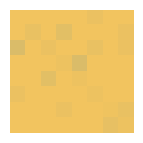

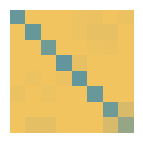

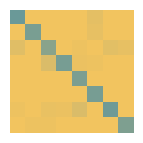

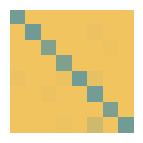

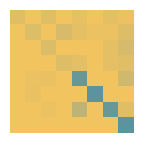

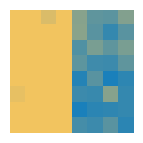

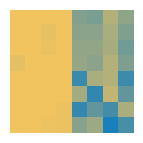

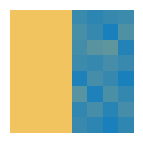

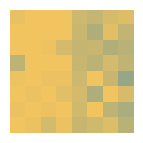

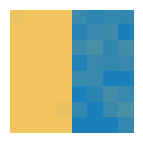

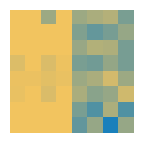

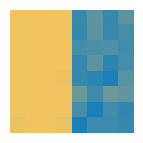

In [37]:
#Figure 2a-c

df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<35)]

df_rats = pd.DataFrame()
Big_Analysis_table_mode=pd.DataFrame()

for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']

        filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
        filtered_dict['rats']=session_name[:4]
        filtered_dict['session_name'] = session_name
        filtered_dict['session_title'] = session_title
        filtered_dict['session_id'] = index
        df = pd.DataFrame([filtered_dict])
        if df_rats.empty:
            df_rats = pd.DataFrame(columns=df.columns)
        df_rats = pd.concat([df_rats,df ], axis=0)

        Analysis_table_f = behave_dict['Analysis_table_mod']
        Analysis_table_f['rats'] = session_name[:4]
        Analysis_table_f['session_name'] = session_name
        Analysis_table_f['session_title'] = session_title
        Analysis_table_f['session_id'] = index

        if Big_Analysis_table_mode.empty:
            Big_Analysis_table_mode = pd.DataFrame(columns=Analysis_table_f.columns)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            Big_Analysis_table_mode = pd.concat([Big_Analysis_table_mode, Analysis_table_f], axis=0)    
df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)

# 
# import matplotlib.colors as mcolors
# 
# colors = ["#1a80bb", "#f2c45f"]  # Blue to orange shades
# num_colors = 100  
# blue_to_orange = mcolors.LinearSegmentedColormap.from_list("BlueToOrange", colors, N=num_colors)
# fig, axes = plt.subplots(3,4,figsize=(5, 5))
# 
# #l = [0, 4, 5, 9, 15, 19, 20, 24, 30,34,35,39]
# l = [0, 4, 5, 9, 15, 19, 20, 24, 25,29,30,34]
# 
# odor_means =Big_Analysis_table_mode.groupby(['session_id','odor_before','odor_ID']).go_nogo.mean()
# axes = axes.flatten()
# 
# for i, value in enumerate(l):
#     go_odors_mat = odor_means.loc[(value, slice(None), slice(None))].unstack().values # select the session #
#     axes[i].imshow(go_odors_mat, cmap = blue_to_orange, interpolation='nearest',vmin=0, vmax=1)


import matplotlib.colors as mcolors

colors = ["#1a80bb", "#f2c45f"]  # Blue to orange shades
num_colors = 100
blue_to_orange = mcolors.LinearSegmentedColormap.from_list("BlueToOrange", colors, N=num_colors)

# Session list
l = [0, 4, 5, 9, 15, 19, 20, 24, 25,29,30,34]

# Compute odor means
odor_means = Big_Analysis_table_mode.groupby(
    ['session_id', 'odor_before', 'odor_ID']
).go_nogo.mean()

# Loop through sessions and save each plot separately
for value in l:
    go_odors_mat = odor_means.loc[(value, slice(None), slice(None))].unstack().values

    fig, ax = plt.subplots(figsize=(1.6, 1.6))  # small square figure
    ax.imshow(
        go_odors_mat,
        cmap=blue_to_orange,
        interpolation='nearest',
        vmin=0, vmax=1
    )

    # Remove ticks, labels, and title
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("")
    ax.axis("off")

    # Save as high-resolution PNG
    #plt.savefig(f"{fig_path}/heatmap{value}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1990072547.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.catplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1990072547.py:20: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1990072547.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.0}` instead.

  g = sns.catplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1990072547.py:36: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.stripplot(


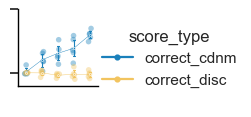

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1990072547.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.catplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1990072547.py:20: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1990072547.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.0}` instead.

  g = sns.catplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1990072547.py:36: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.stripplot(


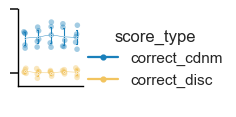

In [38]:
# Learning curves Figure 2d

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
color_set = ["#1a80bb", "#f2c45f","#f2c45f","#eddca5"]


df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=[ 'rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')
# 
for i in range(1, 3):
    data = melted_df[melted_df.bin_column == i]

    # Main pointplot (mean ± sem)
    g = sns.catplot(
        data=data,
        x="session_id", y="score_value", hue="score_type",
        capsize=.1, palette=color_set,
        kind="point", height=1.6, aspect=1.3,
        estimator=np.mean,
        markers=["o", "o"],          # Marker shapes
        linestyles=["-", "-"],
        scale=0.6,
        linewidth=0.3,
        errwidth=1.0
    )

    ax = g.axes.flat[0]

    # Overlay raw points in the background
    sns.stripplot(
        data=data,
        x="session_id", y="score_value", hue="score_type",
        palette=color_set,
        dodge=False, jitter=True,
        size=4.0, alpha=0.4,          # smaller + transparent
        ax=ax, linewidth=0
    )

    # Remove duplicate legend from stripplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

    # Tidy up lines/markers
    for line in ax.findobj(mpl.lines.Line2D):
        mk = line.get_marker()
        if not mk or mk == "None":
            continue
        col = line.get_color()
        line.set_linewidth(0.3)
        line.set_markersize(1.4)
        line.set_markerfacecolor(col)
        line.set_markeredgecolor("w")
        line.set_markeredgewidth(0.4)
        line.set_zorder(10)

    for ln in ax.lines:
        if ln.get_marker() in [None, "None", ""]:
            ln.set_linewidth(0.8)

    # Clean up plot appearance
    g.set_titles("")
    g.despine(left=False, bottom=False, top=True)
    g.set(
        ylabel='', xlabel='',
        xticks=[], title='',
        yticks=[.5, 1], ylim=(.4, 1)
    )
    g.set(yticklabels=[])

    g.fig.savefig(f'{fig_path}/2d_{i}.png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(g.fig)


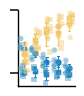

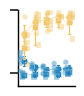

In [39]:
# Learning curves Figure 2g

color_set = ["#1a80bb", "#1a80bb","#f2c45f","#f2c45f"]

for i in range(4, 6):
    data = melted_df[melted_df.bin_column.isin([i, i+2])].copy()
    data["session_id"] = data["session_id"].where(data["session_id"] < 25, data["session_id"] - 10)
    data["combined"] = data["score_type"] + " - Bin " + data["bin_column"].astype(str)

    # lock grouping ▶ [1,2,3,4] = [cdnm Bin i, disc Bin i, cdnm Bin i+3, disc Bin i+3]
    hue_order = [
        f"correct_cdnm - Bin {i}",
        f"correct_cdnm - Bin {i+2}",
        f"correct_disc - Bin {i}",
        f"correct_disc - Bin {i+2}"
    ]
    palette_map = dict(zip(hue_order, color_set))

    # --- summary (mean ± sem) ---
    g = sns.catplot(
        data=data, x="session_id", y="score_value", hue="combined",
        hue_order=hue_order, palette=palette_map,
        kind="point", height=1.6, aspect=1.4,
        estimator=np.mean, capsize=.2,
        linestyles=["-", ":", "-", ":"],
        markers=["o", "s", "o", "s"],
        zorder=10,
        linewidth=0.3,
        err_kws={'linewidth': 1.0}
        
    )
    ax = g.axes.flat[0]

    # --- raw points UNDER the summary ---
    # groups 1 & 3 → circles
    sns.stripplot(
        data=data[data["combined"].isin([hue_order[0], hue_order[2]])],
        x="session_id", y="score_value", hue="combined",
        hue_order=hue_order, palette=palette_map,
        dodge=True, jitter=True, marker="o", size=4, alpha=0.4,
        linewidth=0, ax=ax
    )
    # groups 2 & 4 → squares
    sns.stripplot(
        data=data[data["combined"].isin([hue_order[1], hue_order[3]])],
        x="session_id", y="score_value", hue="combined",
        hue_order=hue_order, palette=palette_map,
        dodge=True, jitter=True, marker="s", size=4, alpha=0.4,
        linewidth=0, ax=ax
    )

    # Format markers/lines of pointplot
    for line in ax.findobj(mpl.lines.Line2D):
        mk = line.get_marker()
        if not mk or mk == "None":
            continue
        col = line.get_color()
        line.set_linewidth(0.3)
        line.set_markersize(5)
        line.set_markerfacecolor(col)
        line.set_markeredgecolor("w")
        line.set_markeredgewidth(0.4)
        line.set_zorder(10)

    for ln in ax.lines:
        if ln.get_marker() in [None, "None", ""]:
            ln.set_linewidth(0.8)

    # Optional clean-up (titles, axes labels, etc.)
    g.set_titles("")
    g.despine(left=False, bottom=False, top=True)
    # make them thin

    # 2) Collection-based markers (some seaborn versions/themes use these)
    # PathCollection (scatter-like) or LineCollection (errorbars)
    for coll in ax.collections:
        # Thin the errorbar strokes
        try:
            coll.set_linewidths([0.3])
        except Exception:
            pass
        # If this collection holds the markers, set its edge
        if isinstance(coll, mpl.collections.PathCollection):
            try:
                coll.set_edgecolor("w")   # <— edge color
                coll.set_linewidth(0.3)
                coll.set_zorder(10)

            except Exception:
                pass

    # cleanup (remove duplicate legends, tidy axes)
    leg = ax.get_legend()
    if leg: leg.remove()
    if getattr(g, "_legend", None): g._legend.remove()

    g.set_titles("")
    g.despine(left=False, bottom=False, top=True, right=True)
    g.set(ylabel="", xlabel="", xticks=[], yticks=[.5, 1.0], ylim=(.4, 1.0), yticklabels=[])

    g.fig.savefig(f"{fig_path}/2d_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(g.fig)


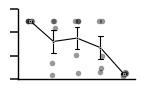

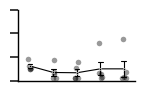

       Effect   F  df1  df2        p  partial η²         95% CI
C(session_id) 6.5    9   40 0.000012       0.594 [0.914, 0.672]


/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/3141901204.py:82: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, "tr_to_crit"] = pd.to_numeric(data["tr_to_crit"], errors="coerce")


In [40]:
# Trials to criterion. Figure 2 e
crit_df=pd.DataFrame(columns=['session_id','rats','tr_to_crit'])
index=[]
i=-1
for  (group, df) in Big_Analysis_table_mode.groupby(['session_id','rats'], group_keys=True,sort=False):#to ensure the order of the groups as the original
    i=i+1
    crit_df.loc[i,'session_id']=group[0]
    crit_df.loc[i,'rats']=group[1]
    crit_df.loc[i,'tr_to_crit']=find_first_index(df.reset_index())

crit_df['bin_column'] = crit_df['session_id'].apply(categorize_into_bins)
for i in range(1, 3):
    data = crit_df[(crit_df.bin_column == i)]

    # --- summary (mean ± SE) on top ---
    g = sns.catplot(
        data=data, x="session_id", y="tr_to_crit",
        color="black", errorbar="se",
        kind="point", height=1.55, aspect=1.3, 
        estimator=np.mean, capsize=.2,
        zorder=10,
        linewidth=0.3,
        err_kws={'linewidth': 1.0}
    )
    ax = g.axes.flat[0]

    # --- raw points UNDER the summary ---
    sns.stripplot(
        data=data,
        x="session_id", y="tr_to_crit",
        jitter=True, dodge=False,
        color="black", alpha=0.4,  # lighter/transparent
        size=4, linewidth=0,
        ax=ax, zorder=1
    )

    # ---- style summary markers/lines (thin with white edges) ----
    for line in ax.findobj(mpl.lines.Line2D):
        mk = line.get_marker()
        if not mk or mk == "None":
            continue
        col = line.get_color()
        line.set_linewidth(0.8)
        line.set_markersize(1.8)
        line.set_markerfacecolor(col)
        line.set_markeredgecolor("w")
        line.set_markeredgewidth(0.4)
        line.set_zorder(12)  # above everything

    # Make connecting lines thin (pure lines without markers)
    for ln in ax.lines:
        if ln.get_marker() in [None, "None", ""]:
            ln.set_linewidth(0.8)
            ln.set_zorder(11)

    # ---- remove all axis labels, keep tick MARKS, hide tick LABELS ----
    g.set_titles("")
    g.set_xlabels("")
    g.set_ylabels("")
    ax.set_title("")
    ax.tick_params(axis='x', which='both', labelbottom=False)
    ax.tick_params(axis='y', which='both', labelleft=False)

    # y-range and ticks
    ax.set_ylim(0, 600)
    ax.set_yticks([0, 200, 400, 600])

    # Clean spines
    g.despine(left=False, bottom=False, top=True, right=True)

    # No legend expected (no hue), but guard anyway
    leg = ax.get_legend()
    if leg:
        leg.remove()

    g.fig.savefig(f"{fig_path}/2e_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(g.fig)

    
data = crit_df[crit_df.bin_column.isin([1, 2])].copy()  # <-- .copy()
data.loc[:, "tr_to_crit"] = pd.to_numeric(data["tr_to_crit"], errors="coerce")
# 
# data["tr_to_crit"] = pd.to_numeric(data["tr_to_crit"], errors="coerce")
# data["session_id"] = pd.to_numeric(data["session_id"], errors="coerce")

model = ols('tr_to_crit ~ C(session_id)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))

# data = remap_df(crit_df)
# data.to_excel(f'{fig_path}/2eh.xlsx', index=False)


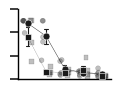

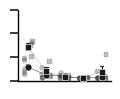

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1468270051.py:86: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, "tr_to_crit"] = pd.to_numeric(data["tr_to_crit"], errors="coerce")


                Effect     F  df1  df2            p  partial η²         95% CI
         C(session_id) 34.18    9   67 1.092265e-21       0.821  [0.98, 0.954]
              C(group)  2.50    1   67 1.187821e-01       0.036   [0.927, 1.0]
C(session_id):C(group)  7.78    9   67 9.662096e-08       0.511 [0.923, 0.757]
Post-hoc results for 15:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1    group2    meandiff p-adj   lower    upper   reject
-------------------------------------------------------------
control experimental   115.25 0.1865 -70.8599 301.3599  False
-------------------------------------------------------------
Post-hoc results for 16:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1    group2    meandiff p-adj   lower    upper   reject
-------------------------------------------------------------
control experimental   306.15 0.0042 132.8566 479.4434   True
-------------------------------------------------------------
Post-hoc resul

In [41]:
# Trials to criterion. Figure 2h
for i in range(4, 6):
    data = crit_df[crit_df.bin_column.isin([i, i+2])].copy()
    data["session_id"] = data["session_id"].where(data["session_id"] < 25, data["session_id"] - 10)

    hue_order = [i, i+2]  # first group = i (o), second group = i+3 (s)

    g = sns.catplot(
        data=data, x="session_id", y="tr_to_crit", hue="bin_column",
        hue_order=hue_order, palette=['k', 'k'], errorbar="se",
        kind="point", height=1.55, aspect=1.35,
        estimator=np.mean, capsize=.2,
        linestyles=["-", ":"],
        markers=["o", "s"],
        zorder=10,
        linewidth=0.3,
        err_kws={'linewidth': 1.0}    
        )
    ax = g.axes.flat[0]

    # --- raw points UNDER the summary ---
    # first group (Bin i) -> circles
    sns.stripplot(
        data=data[data["bin_column"] == i],
        x="session_id", y="tr_to_crit", hue="bin_column",
        hue_order=hue_order, palette=['k', 'k'],
        dodge=True, jitter=True, marker="o",
        size=3.5, alpha=0.28, linewidth=0, ax=ax
    )
    # second group (Bin i+3) -> squares
    sns.stripplot(
        data=data[data["bin_column"] == i+2],
        x="session_id", y="tr_to_crit", hue="bin_column",
        hue_order=hue_order, palette=['k', 'k'],
        dodge=True, jitter=True, marker="s",
        size=3.5, alpha=0.28, linewidth=0, ax=ax
    )

    # push all raw PathCollections behind
    for coll in ax.collections:
        if isinstance(coll, mpl.collections.PathCollection):
            coll.set_zorder(1)

    # style summary markers/lines
    for line in ax.findobj(mpl.lines.Line2D):
        mk = line.get_marker()
        if mk and mk != "None":
            col = line.get_color()
            line.set_linewidth(0.3)
            line.set_markersize(5)
            line.set_markerfacecolor(col)
            line.set_markeredgecolor("w")
            line.set_markeredgewidth(0.4)
            line.set_zorder(12)
    for ln in ax.lines:
        if ln.get_marker() in [None, "None", ""]:
            ln.set_linewidth(0.8)
            ln.set_zorder(11)

    # thin collections (errorbars/markers)
    for coll in ax.collections:
        try: coll.set_linewidths([0.3])
        except Exception: pass

    # clean axes/legend
    g.set_titles(""); g.set_xlabels(""); g.set_ylabels(""); ax.set_title("")
    ax.tick_params(axis='x', which='both', labelbottom=False)
    ax.tick_params(axis='y', which='both', labelleft=False)
    ax.set_ylim(0, 600); ax.set_yticks([0, 200, 400, 600])
    g.despine(left=False, bottom=False, top=True, right=True)
    leg = ax.get_legend()
    if leg: leg.remove()
    if getattr(g, "_legend", None): g._legend.remove()

    g.fig.savefig(f"{fig_path}/2h_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(g.fig)

    
    
data = crit_df[(crit_df.bin_column.isin([4, 5, 6, 7]))].copy()
data = data.copy()
data["group"] = "experimental"
data.loc[data["session_id"] >= 25, "group"] = "control"
data['session_id'] = data['session_id'].apply(lambda x: x - 10 if x >= 25 else x)
data.loc[:, "tr_to_crit"] = pd.to_numeric(data["tr_to_crit"], errors="coerce")

from statsmodels.formula.api import ols

model = ols('tr_to_crit ~ C(session_id) * C(group)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform pairwise comparisons within each level of factor1
for level in data['session_id'].unique():
    subset = data[data['session_id'] == level]

    tukey = pairwise_tukeyhsd(endog=subset['tr_to_crit'], groups=subset['group'], alpha=0.05)
    print(f"Post-hoc results for {level}:")
    print(tukey)


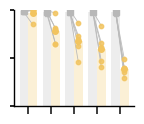

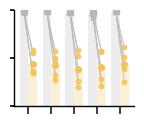

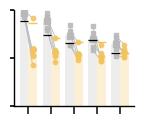

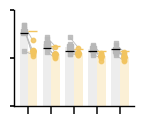

                    Effect    F  df1  df2            p  partial η²         95% CI
             C(session_id) 9.77    9   56 8.303288e-09       0.611 [0.937, 0.809]
              C(Condition) 0.03    1   56 8.551185e-01       0.001    [0.78, 1.0]
C(session_id):C(Condition) 0.09    9   56 9.996690e-01       0.015     [0.0, 1.0]
Post-hoc results for 25:
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------
FaRate_disc0_cdnm0P FaRate_disc0_cdnm1P   0.0212 0.6708 -0.0949 0.1372  False
-----------------------------------------------------------------------------
Post-hoc results for 26:
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------

In [42]:
# go prob bars  figure 2f 
df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<5)]

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# go prob bars  figure 2f 
session_ids = grouped_df['session_id'].to_numpy()
pos = np.arange(len(session_ids)) * 1.20
width = 0.45

fig, ax = plt.subplots(figsize=(1.6, 1.4))

def sem(v):
    return np.std(v, ddof=1) / np.sqrt(len(v)) if len(v) > 1 else 0

# -------- Background bars (means only) --------
bar_left = ax.bar(
    pos - width/2, grouped_df['mean_missrate_1'], width,
    facecolor=color_set[2], edgecolor='none', alpha=0.25, zorder=0, label='Exp mean cdnm1'
)
bar_right = ax.bar(
    pos + width/2, grouped_df['mean_missrate_0'], width,
    facecolor=color_set[1], edgecolor='none', alpha=0.25, zorder=0, label='Exp mean cdnm0'
)

# -------- Paired slopegraph (rats) --------
for k, sid in enumerate(session_ids):
    x_left  = pos[k] - width/2   # cdnm1 (LEFT, grey, squares)
    x_right = pos[k] + width/2   # cdnm0 (RIGHT, yellow, circles)

    d1 = df_behave_bins.loc[df_behave_bins.session_id==sid, 'FaRate_disc0_cdnm1P'].dropna().to_numpy()
    d0 = df_behave_bins.loc[df_behave_bins.session_id==sid, 'FaRate_disc0_cdnm0P'].dropna().to_numpy()

    n = min(len(d0), len(d1))
    if n == 0:
        continue
    d1, d0 = d1[:n], d0[:n]

    # paired lines
    for a, b in zip(d1, d0):
        ax.plot([x_left, x_right], [a, b], color="#bbbbbb", linewidth=0.6, zorder=1)

    # raw points
    ax.scatter(np.full(n, x_left),  d1, s=10, marker="s", color=color_set[2], alpha=0.85, zorder=2)
    ax.scatter(np.full(n, x_right), d0, s=10, marker="o", color=color_set[1], alpha=0.85, zorder=2)

    # session means as markers ± SEM (only markers)
    ax.errorbar(x_left,  np.mean(d1), yerr=None, fmt='s', ms=4, color=color_set[2],
                zorder=3)
    ax.errorbar(x_right, np.mean(d0), yerr=None, fmt='o', ms=4, color=color_set[1],
                zorder=3)

# -------- Cosmetics --------
ax.set_xticks(pos); ax.set_xticklabels(['']*len(pos))
ax.set_ylim(0, 1)

for spine in ['right','top']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.set_xlabel(''); ax.set_ylabel('')
ax.set_yticks([0, 0.5, 1]); ax.set_yticklabels([])
ax.tick_params(axis='y', which='both',
               direction='out', length=3, width=1.2,
               color='black', labelleft=False)

plt.tight_layout()
plt.show()
fig.savefig(f"{fig_path}/2f1.png", dpi=300, bbox_inches="tight")

df_sessions_f = df_sessions[(df_sessions.index>=5)&(df_sessions.index<10)]


#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# go prob bars  figure 2f 
session_ids = grouped_df['session_id'].to_numpy()
pos = np.arange(len(session_ids)) * 1.20
width = 0.45

fig, ax = plt.subplots(figsize=(1.6, 1.4))

# -------- Background bars (means only) --------
bar_left = ax.bar(
    pos - width/2, grouped_df['mean_missrate_1'], width,
    facecolor=color_set[2], edgecolor='none', alpha=0.25, zorder=0, label='Exp mean cdnm1'
)
bar_right = ax.bar(
    pos + width/2, grouped_df['mean_missrate_0'], width,
    facecolor=color_set[1], edgecolor='none', alpha=0.25, zorder=0, label='Exp mean cdnm0'
)

# -------- Paired slopegraph (rats) --------
for k, sid in enumerate(session_ids):
    x_left  = pos[k] - width/2   # cdnm1 (LEFT, grey, squares)
    x_right = pos[k] + width/2   # cdnm0 (RIGHT, yellow, circles)

    d1 = df_behave_bins.loc[df_behave_bins.session_id==sid, 'FaRate_disc0_cdnm1P'].dropna().to_numpy()
    d0 = df_behave_bins.loc[df_behave_bins.session_id==sid, 'FaRate_disc0_cdnm0P'].dropna().to_numpy()

    n = min(len(d0), len(d1))
    if n == 0:
        continue
    d1, d0 = d1[:n], d0[:n]

    # paired lines
    for a, b in zip(d1, d0):
        ax.plot([x_left, x_right], [a, b], color="#bbbbbb", linewidth=0.6, zorder=1)

    # raw points
    ax.scatter(np.full(n, x_left),  d1, s=10, marker="s", color=color_set[2], alpha=0.85, zorder=2)
    ax.scatter(np.full(n, x_right), d0, s=10, marker="o", color=color_set[1], alpha=0.85, zorder=2)

    # session means as markers ± SEM (only markers)
    ax.errorbar(x_left,  np.mean(d1), yerr=None, fmt='s', ms=4, color=color_set[2],
                zorder=3)
    ax.errorbar(x_right, np.mean(d0), yerr=None, fmt='o', ms=4, color=color_set[1],
                zorder=3)

# -------- Cosmetics --------
ax.set_xticks(pos); ax.set_xticklabels(['']*len(pos))
ax.set_ylim(0, 1)

for spine in ['right','top']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.set_xlabel(''); ax.set_ylabel('')
ax.set_yticks([0, 0.5, 1]); ax.set_yticklabels([])
ax.tick_params(axis='y', which='both',
               direction='out', length=3, width=1.2,
               color='black', labelleft=False)

plt.tight_layout()
plt.show()
fig.savefig(f"{fig_path}/2f2.png", dpi=300, bbox_inches="tight")

df_sessions_exp = df_sessions[(df_sessions.index>=15)&(df_sessions.index<20)]

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

# Build per-rat values (experimental)
exp_rows = []
for index, row in df_sessions_exp.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']

        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,
                              Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),
                              Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)

        exp_rows.append({
            'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
            'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
            'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,   # cdnm0 (RIGHT)
            'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,   # cdnm1 (LEFT)
            'rats':session_name[:4],
            'session_name':session_name,
            'session_title':session_title,
            'session_id':index
        })

df_behave_bins_exp = pd.DataFrame(exp_rows)

grouped_exp = df_behave_bins_exp.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0 =('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1 =('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# ==== CONTROL SESSIONS (choose the range you use for controls) ====
# Adjust these indices if needed:
df_sessions_ctrl = df_sessions[(df_sessions.index>=25)&(df_sessions.index<30)]

ctrl_rows = []
for index, row in df_sessions_ctrl.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']

        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,
                              Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),
                              Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)

        ctrl_rows.append({
            'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
            'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
            'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
            'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
            'rats':session_name[:4],
            'session_name':session_name,
            'session_title':session_title,
            'session_id':index
        })

df_behave_bins_ctrl = pd.DataFrame(ctrl_rows)

grouped_ctrl = df_behave_bins_ctrl.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0 =('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1 =('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# ==== PLOTTING: exp background bars + slopegraph, control thin foreground ticks ====
spacing = 1.20
n = min(len(grouped_exp), len(grouped_ctrl))  # keep aligned
grouped_exp  = grouped_exp.iloc[:n].reset_index(drop=True)
grouped_ctrl = grouped_ctrl.iloc[:n].reset_index(drop=True)

x = np.arange(0, n * spacing, spacing)
width = 0.45  # also used to size control ticks

fig, ax = plt.subplots(figsize=(1.6, 1.4))

# 1) Experimental background bars (means only; no error bars)
# LEFT = cdnm1 (grey), RIGHT = cdnm0 (yellow)
ax.bar(
    x - width/2, grouped_exp['mean_missrate_1'], width,
    facecolor=color_set[2], edgecolor='none', alpha=0.25, zorder=0
)
ax.bar(
    x + width/2, grouped_exp['mean_missrate_0'], width,
    facecolor=color_set[1], edgecolor='none', alpha=0.25, zorder=0
)

# 2) Experimental slopegraph (paired rats)
def _pair_and_plot_one_session(ax, sid, x_left, x_right):
    d1_df = df_behave_bins_exp.loc[df_behave_bins_exp.session_id == sid, ['rats', 'FaRate_disc0_cdnm1P']]
    d0_df = df_behave_bins_exp.loc[df_behave_bins_exp.session_id == sid, ['rats', 'FaRate_disc0_cdnm0P']]
    merged = pd.merge(d1_df, d0_df, on='rats', how='inner').dropna()
    if merged.empty:
        return
    d1 = merged['FaRate_disc0_cdnm1P'].to_numpy()  # LEFT (grey)
    d0 = merged['FaRate_disc0_cdnm0P'].to_numpy()  # RIGHT (yellow)

    # connectors per rat
    for a, b in zip(d1, d0):
        ax.plot([x_left, x_right], [a, b], color="#bbbbbb", linewidth=0.6, zorder=1)

    # raw points
    ax.scatter(np.full(len(d1), x_left),  d1, s=10, marker="s",
               color=color_set[2], alpha=0.85, zorder=2)
    ax.scatter(np.full(len(d0), x_right), d0, s=10, marker="o",
               color=color_set[1], alpha=0.85, zorder=2)

    # session mean markers (no error bars)
    ax.plot(x_left,  np.mean(d1), marker='s', ms=4, color=color_set[2], zorder=3)
    ax.plot(x_right, np.mean(d0), marker='o', ms=4, color=color_set[1], zorder=3)

for k, sid in enumerate(grouped_exp['session_id'].to_numpy()):
    _pair_and_plot_one_session(ax, sid, x[k] - width/2, x[k] + width/2)

# 3) Control means as thin foreground ticks (same width as bars)
tick_len = width / 2.0   # full bar width
lw_black = 0.9           # thinner
lw_yellow = 1.0          # thinner

for k in range(n):
    center_left  = x[k] - width/2   # cdnm1 (LEFT)
    center_right = x[k] + width/2   # cdnm0 (RIGHT)

    # cdnm1 control tick (black, foreground)
    mean_ctrl_left = grouped_ctrl.loc[k, 'mean_missrate_1']
    ax.hlines(y=mean_ctrl_left,
              xmin=center_left - tick_len, xmax=center_left + tick_len,
              colors='black', linewidth=lw_black, zorder=10)

    # cdnm0 control tick (bold yellow, foreground)
    mean_ctrl_right = grouped_ctrl.loc[k, 'mean_missrate_0']
    ax.hlines(y=mean_ctrl_right,
              xmin=center_right - tick_len, xmax=center_right + tick_len,
              colors=color_set[1], linewidth=lw_yellow, zorder=10)

# Cosmetics
ax.set_xticks(x); ax.set_xticklabels([''] * len(x))
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black');  ax.spines['bottom'].set_color('black')
ax.set_xlabel(''); ax.set_ylabel('')
ax.set_yticks([0, 0.5, 1]); ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', direction='out',
               length=3, width=1.2, color='black', labelleft=False)

plt.tight_layout()
plt.show()
fig.savefig(f"{fig_path}/2i1.png", dpi=300, bbox_inches="tight")

df_sessions_exp = df_sessions[(df_sessions.index>=20)&(df_sessions.index<25)]

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

# Build per-rat values (experimental)
exp_rows = []
for index, row in df_sessions_exp.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']

        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,
                              Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),
                              Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)

        exp_rows.append({
            'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
            'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
            'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,   # cdnm0 (RIGHT)
            'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,   # cdnm1 (LEFT)
            'rats':session_name[:4],
            'session_name':session_name,
            'session_title':session_title,
            'session_id':index
        })

df_behave_bins_exp = pd.DataFrame(exp_rows)

grouped_exp = df_behave_bins_exp.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0 =('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1 =('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# ==== CONTROL SESSIONS (choose the range you use for controls) ====
# Adjust these indices if needed:
df_sessions_ctrl = df_sessions[(df_sessions.index>=30)&(df_sessions.index<35)]

ctrl_rows = []
for index, row in df_sessions_ctrl.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']

        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,
                              Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),
                              Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)

        ctrl_rows.append({
            'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
            'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
            'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
            'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
            'rats':session_name[:4],
            'session_name':session_name,
            'session_title':session_title,
            'session_id':index
        })

df_behave_bins_ctrl = pd.DataFrame(ctrl_rows)

grouped_ctrl = df_behave_bins_ctrl.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0 =('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1 =('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# ==== PLOTTING: exp background bars + slopegraph, control thin foreground ticks ====
spacing = 1.20
n = min(len(grouped_exp), len(grouped_ctrl))  # keep aligned
grouped_exp  = grouped_exp.iloc[:n].reset_index(drop=True)
grouped_ctrl = grouped_ctrl.iloc[:n].reset_index(drop=True)

x = np.arange(0, n * spacing, spacing)
width = 0.45  # also used to size control ticks

fig, ax = plt.subplots(figsize=(1.6, 1.4))

# 1) Experimental background bars (means only; no error bars)
# LEFT = cdnm1 (grey), RIGHT = cdnm0 (yellow)
ax.bar(
    x - width/2, grouped_exp['mean_missrate_1'], width,
    facecolor=color_set[2], edgecolor='none', alpha=0.25, zorder=0
)
ax.bar(
    x + width/2, grouped_exp['mean_missrate_0'], width,
    facecolor=color_set[1], edgecolor='none', alpha=0.25, zorder=0
)

# 2) Experimental slopegraph (paired rats)
def _pair_and_plot_one_session(ax, sid, x_left, x_right):
    d1_df = df_behave_bins_exp.loc[df_behave_bins_exp.session_id == sid, ['rats', 'FaRate_disc0_cdnm1P']]
    d0_df = df_behave_bins_exp.loc[df_behave_bins_exp.session_id == sid, ['rats', 'FaRate_disc0_cdnm0P']]
    merged = pd.merge(d1_df, d0_df, on='rats', how='inner').dropna()
    if merged.empty:
        return
    d1 = merged['FaRate_disc0_cdnm1P'].to_numpy()  # LEFT (grey)
    d0 = merged['FaRate_disc0_cdnm0P'].to_numpy()  # RIGHT (yellow)

    # connectors per rat
    for a, b in zip(d1, d0):
        ax.plot([x_left, x_right], [a, b], color="#bbbbbb", linewidth=0.6, zorder=1)

    # raw points
    ax.scatter(np.full(len(d1), x_left),  d1, s=10, marker="s",
               color=color_set[2], alpha=0.85, zorder=2)
    ax.scatter(np.full(len(d0), x_right), d0, s=10, marker="o",
               color=color_set[1], alpha=0.85, zorder=2)

    # session mean markers (no error bars)
    ax.plot(x_left,  np.mean(d1), marker='s', ms=4, color=color_set[2], zorder=3)
    ax.plot(x_right, np.mean(d0), marker='o', ms=4, color=color_set[1], zorder=3)

for k, sid in enumerate(grouped_exp['session_id'].to_numpy()):
    _pair_and_plot_one_session(ax, sid, x[k] - width/2, x[k] + width/2)

# 3) Control means as thin foreground ticks (same width as bars)
tick_len = width / 2.0   # full bar width
lw_black = 0.9           # thinner
lw_yellow = 1.0          # thinner

for k in range(n):
    center_left  = x[k] - width/2   # cdnm1 (LEFT)
    center_right = x[k] + width/2   # cdnm0 (RIGHT)

    # cdnm1 control tick (black, foreground)
    mean_ctrl_left = grouped_ctrl.loc[k, 'mean_missrate_1']
    ax.hlines(y=mean_ctrl_left,
              xmin=center_left - tick_len, xmax=center_left + tick_len,
              colors='black', linewidth=lw_black, zorder=10)

    # cdnm0 control tick (bold yellow, foreground)
    mean_ctrl_right = grouped_ctrl.loc[k, 'mean_missrate_0']
    ax.hlines(y=mean_ctrl_right,
              xmin=center_right - tick_len, xmax=center_right + tick_len,
              colors=color_set[1], linewidth=lw_yellow, zorder=10)

# Cosmetics
ax.set_xticks(x); ax.set_xticklabels([''] * len(x))
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black');  ax.spines['bottom'].set_color('black')
ax.set_xlabel(''); ax.set_ylabel('')
ax.set_yticks([0, 0.5, 1]); ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', direction='out',
               length=3, width=1.2, color='black', labelleft=False)

plt.tight_layout()
plt.show()
fig.savefig(f"{fig_path}/2i2.png", dpi=300, bbox_inches="tight")

#Go probability figure 2f
from scipy import stats

#df_sessions_f = df_sessions[(df_sessions.index>=15)&(df_sessions.index<25)]
df_sessions_f = df_sessions[(df_sessions.index>=25)&(df_sessions.index<35)]

#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Plotting the grouped bar chart
x = np.arange(len(grouped_df['session_id']))
width = 0.35

# Prepare data in long format for the ANOVA
anova_data_long = df_behave_bins.melt(id_vars=['rats', 'session_id'], value_vars=['FaRate_disc0_cdnm0P', 'FaRate_disc0_cdnm1P'],
                                      var_name='Condition', value_name='FARate')

# Performing the two-way ANOVA with interaction
model = ols('FARate ~ C(session_id) * C(Condition)', data=anova_data_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform pairwise comparisons within each level of factor1
for level in anova_data_long['session_id'].unique():
    subset = anova_data_long[anova_data_long['session_id'] == level]

    tukey = pairwise_tukeyhsd(endog=subset['FARate'], groups=subset['Condition'], alpha=0.05)
    print(f"Post-hoc results for {level}:")
    print(tukey)

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/3866409070.py:42: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  LC = sns.catplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/3866409070.py:55: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.stripplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/3866409070.py:55: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.stripplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/3866409070.py:55: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.stripplot(
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/3866409070.py:55: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.stripplot(
/var/folders/4m/5b48_0dx7q3

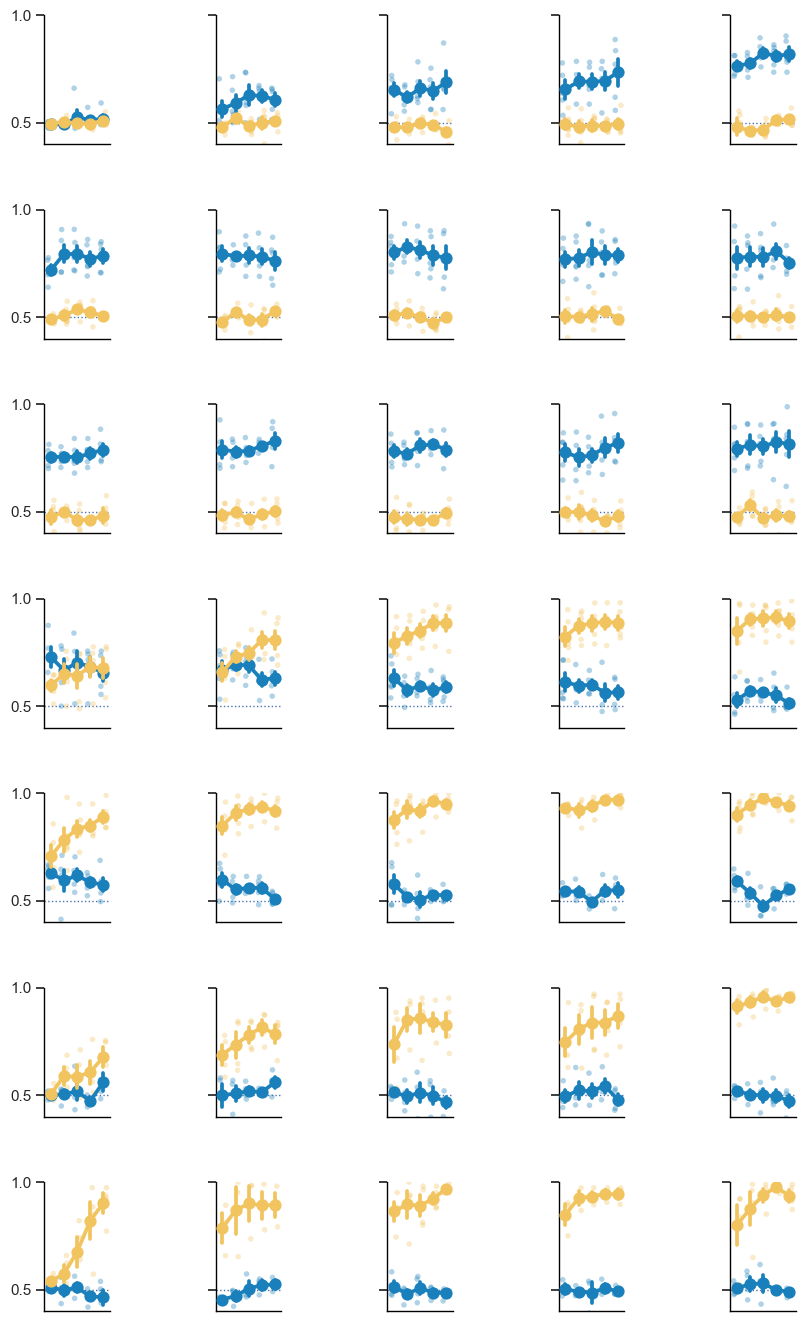

In [43]:
#Learning curves with multiple bins per session Supplementary figure1
df_sessions_f = df_sessions[(df_sessions.index >= 0) & (df_sessions.index < 35) ]

#initialize df with scores per session
df_behave_bins_temp = []
bin_num=5
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin = bin_performance(Analysis_table_f,  bin_num=bin_num)
        df_behave_bins_temp.append({'correct_cdnm_bin':correct_cdnm_bin,
                                    'correct_disc_bin':correct_disc_bin,
                                    'dPrime_cdnm_bin':dPrime_cdnm_bin,
                                    'dPrime_disc_bin':dPrime_disc_bin,
                                    'HitRate_cdnm_bin':HitRate_cdnm_bin,
                                    'FARate_cdnm_bin':FARate_cdnm_bin,
                                    'HitRate_disc_bin':HitRate_disc_bin,
                                    'FARate_disc_bin':FARate_disc_bin,
                                    'correct_cdnm_only_bin':correct_cdnm_only_bin,
                                    'correct_disc_only_bin':correct_disc_only_bin,
                                    'bin_id':range(bin_num),
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)
df_behave_bins
df_behave_bins_exploded = df_behave_bins.explode(['correct_cdnm_bin','correct_disc_bin','dPrime_cdnm_bin','dPrime_disc_bin','HitRate_cdnm_bin','FARate_cdnm_bin',
                                                  'HitRate_disc_bin','FARate_disc_bin','correct_cdnm_only_bin','correct_disc_only_bin','bin_id'])
df_behave_bins_exploded
data = pd.melt(df_behave_bins_exploded, id_vars=[ 'rats','session_id','bin_id'], value_vars=['correct_cdnm_bin','correct_disc_bin'], var_name='score_type', value_name='score_value')

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

LC = sns.catplot(
    data=data,
    x="bin_id", y="score_value",
    palette=color_set,
    errorbar="se", sharex=False,
    col="session_id", hue="score_type", col_wrap=5,
    kind="point", height=2, aspect=.85
)

# --- Overlay raw points per facet (background) ---
# Use LC.col_names to align each axis with its session_id slice
for ax, sid in zip(LC.axes.flat, LC.col_names):
    sub = data[data["session_id"] == sid]
    sns.stripplot(
        data=sub,
        x="bin_id", y="score_value", hue="score_type",
        palette=color_set,
        dodge=True, jitter=True,
        size=4.0, alpha=0.35, linewidth=0,
        ax=ax, zorder=1
    )
    # Keep summary pointplot on top
    for line in ax.lines:
        line.set_zorder(10)

# --- Remove ALL legends (grid-level and axis-level) ---
# Remove any legends that stripplot may have added to each facet
for ax in LC.axes.flat:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()
# Remove the FacetGrid's main legend if present
if getattr(LC, "_legend", None) is not None:
    LC._legend.remove()

# --- Apply your styling PER AXIS ---
for ax in LC.axes.flat:
    # despine (top only; right will be removed by default in seaborn's despine)
    sns.despine(ax=ax, left=False, bottom=False, top=True)
    # horizontal reference line at 0.5
    ax.axhline(0.5, linestyle=":", linewidth=1, zorder=0)
    # axis limits/ticks/labels/titles
    ax.set(ylim=(.4, 1), ylabel="", xlabel="", xticks=[], yticks=[.5, 1], title="")

# (Optional) If you want to wipe facet titles (which are the col facet labels),
# uncomment the next line:
# LC.set_titles("")



plt.show()
LC.savefig(f"{fig_path}/S1.png", dpi=300, bbox_inches="tight")
# data_new = remap_df(data)
# data_new.to_excel(f'{fig_path}/S1.xlsx', index=False)


Supplementary Fig2A: ANOVA: F(24, 99) = 0.187, p = 1
Spearman rho=-0.217, p=0.297
Kendall tau=-0.141, p=0.3258
Supplementary Fig2C: ANOVA: F(24, 5210) = 1.518, p = 0.0503
Supplementary Fig2B: ANOVA: F(24, 99) = 0.919, p = 0.576


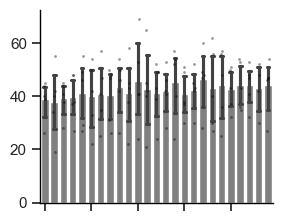

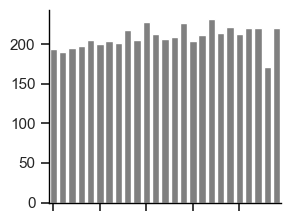

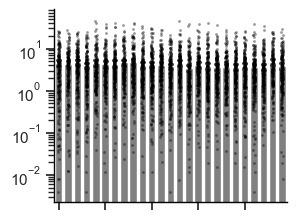

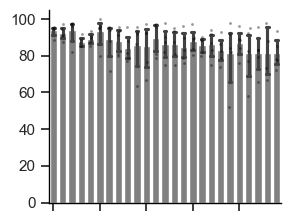

In [44]:
# Suplementary figure 2
from scipy.stats import spearmanr, kendalltau

Responsiveness = pd.DataFrame(columns=['session_name','session_title','cell_num','FR','FR_spont'])

for index, row in df_sessions.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        # Analysis_table_f = loaded_data['Analysis_table_f']  
        # spikeTime = loaded_data['spikeTime']
        # PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime,events = ['odor_unpoke'] , resp_win = (-.5, 0)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
        # spikes_all = np.squeeze(spikes_all)
        # cell_num = spikes_all.shape[1]
        #        FR = np.mean(np.mean(spikes_all,axis=2),0)
        FR = loaded_data['responsivness']['FR_all']

        FR_spont = loaded_data['responsivness']['FR_spont']
        cell_num = len(FR_spont)
        new_row = pd.DataFrame([{
            'session_name': session_name,
            'session_title': session_title,
            'session_ind': index,
            'rats':session_name[:4],
            'cell_num': cell_num,
            'FR': [FR],  # No need for brackets around single values
            'FR_spont': [FR_spont]  # No need for brackets around single values
        }])
        Responsiveness = pd.concat([Responsiveness, new_row], ignore_index=True)
        # Responsiveness = Responsiveness.append({'session_name':session_name,'session_title':session_title,'cell_num':cell_num,'FR':[FR],'FR_spont': [FR_spont]}, ignore_index=True)
fig, ax = plt.subplots(figsize=(3, 2.5))


sns.barplot(data=Responsiveness,x='session_title',y='cell_num',ax=ax,color='gray', capsize=.3, alpha=1)

# Overlay raw points (light black markers)
sns.stripplot(data=Responsiveness, x='session_title', y='cell_num',
              ax=ax, color='black', size=2, alpha=0.4, jitter=True)

plt.xlim([-.5, 24.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([0,5,10,15,20])
ax.set_xticklabels('')
fig.savefig(f"{fig_path}/S2a.png", dpi=300, bbox_inches="tight")

results = Responsiveness.groupby('session_title',sort=False).agg(
    Sum=('cell_num', 'sum'),
    StdDev=('cell_num', 'std')
).reset_index()
results.Sum[0:29].mean()
results.Sum[0:29].std()
fig, ax = plt.subplots(figsize=(3, 2.5))

sns.barplot(data=results,x='session_title',y='Sum',ax=ax,color='gray', capsize=.5, alpha=1)

plt.xlim([-.5,24.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('')


ax.set_xticks([0,5,10,15,20])  # Set only one x-tick at zero
ax.set_xticklabels('')  # Set only one x-tick at zero
fig.savefig(f"{fig_path}/S2b.png", dpi=300, bbox_inches="tight")

Responsiveness_FR = Responsiveness.explode('FR').explode('FR')# Explode the lists to create separate rows for each value
fig, ax = plt.subplots(figsize=(3, 2.5))

sns.barplot(data=Responsiveness_FR, x='session_title', y='FR',
            ax=ax, color='gray', capsize=.3, alpha=1)

sns.stripplot(data=Responsiveness_FR, x='session_title', y='FR',
              ax=ax, color='black', size=2, alpha=0.4, jitter=True)

ax.set_xlabel('')
plt.xlim([-.5, 24.5])
ax.set_xticks([0,5,10,15,20])
ax.set_xticklabels('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_yscale('log')
fig.savefig(f"{fig_path}/S2c.png", dpi=300, bbox_inches="tight")

df = pd.DataFrame()

for index, row in df_sessions.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        result_dict_Zeta = loaded_data['result_dict_Zeta']
        for i in range(len(result_dict_Zeta['p_responsive'])):
         
            new_row = pd.DataFrame([{
                'session_name': session_name,
                'session_title': session_title,
                'session_ind': index,
                'p_responsive': result_dict_Zeta['p_responsive'][i],
                'p_cdnm': result_dict_Zeta['p_cdnm'][i],
                'p_disc': result_dict_Zeta['p_disc'][i]
            }])
            df = pd.concat([df, new_row], ignore_index=True)


df['responsive'] = (df['p_responsive'] < 0.01)

original_order = df['session_title'].unique()
result_cdnm = df.groupby(['session_title','session_ind','session_name'])['responsive'].mean() #mean for each rat in session
result_cdnm_sorted = result_cdnm.loc[original_order]* 100
result_cdnm_sorted_i=result_cdnm_sorted.reset_index()

fig, ax = plt.subplots(figsize=(3, 2.5))

sns.barplot(data=result_cdnm_sorted_i, x='session_title', y='responsive',
            ax=ax, color='gray', capsize=.3, alpha=1)

sns.stripplot(data=result_cdnm_sorted_i, x='session_title', y='responsive',
              ax=ax, color='black', size=2, alpha=0.4, jitter=True)

plt.xlim([-.5, 24.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([0,5,10,15,20])
ax.set_xticklabels('')
fig.savefig(f"{fig_path}/S2d.png", dpi=300, bbox_inches="tight")


# Supplementary figure 2 statistics
Responsiveness = Responsiveness[Responsiveness['session_ind'] < 25]
groups = [group['cell_num'].values for _, group in Responsiveness.groupby('session_title')]
# compute dfs
k = len(groups)
N = sum(len(g) for g in groups)
df1 = k - 1
df2 = N - k
f_stat, p_val = stats.f_oneway(*groups)
print(f"Supplementary Fig2A: ANOVA: F({df1}, {df2}) = {f_stat:.3f}, p = {p_val:.3g}")

results = Responsiveness.groupby('session_title',sort=False).agg(
    Sum=('cell_num', 'sum'),
    StdDev=('cell_num', 'std')
).reset_index()

groups = [group['Sum'].values for _, group in results.groupby('session_title')]
# make an ordered index for sessions
ses_map = {s:i for i, s in enumerate(sorted(results['session_title'].unique()))}
df = results.assign(session_idx=results['session_title'].map(ses_map)).copy()

rho, p_s = spearmanr(df['session_idx'], pd.to_numeric(df['Sum'], errors='coerce'))
tau, p_k = kendalltau(df['session_idx'], pd.to_numeric(df['Sum'], errors='coerce'))
print(f"Spearman rho={rho:.3f}, p={p_s:.4g}")
print(f"Kendall tau={tau:.3f}, p={p_k:.4g}")

Responsiveness_FR = Responsiveness.explode('FR').explode('FR')# Explode the lists to create separate rows for each value
groups = [group['FR'].values for _, group in Responsiveness_FR.groupby('session_title')]
# compute dfs
k = len(groups)
N = sum(len(g) for g in groups)
df1 = k - 1
df2 = N - k
f_stat, p_val = stats.f_oneway(*groups)
print(f"Supplementary Fig2C: ANOVA: F({df1}, {df2}) = {f_stat:.3f}, p = {p_val:.3g}")

result_cdnm_sorted_i = result_cdnm_sorted_i[result_cdnm_sorted_i['session_ind'] < 25]
groups = [group['responsive'].values for _, group in result_cdnm_sorted_i.groupby('session_title')]
# compute dfs
k = len(groups)
N = sum(len(g) for g in groups)
df1 = k - 1
df2 = N - k
f_stat, p_val = stats.f_oneway(*groups)
print(f"Supplementary Fig2B: ANOVA: F({df1}, {df2}) = {f_stat:.3f}, p = {p_val:.3g}")
# # data_new = remap_df(Responsiveness)
# # data_new.to_excel(f'{fig_path}/S2.xlsx', index=False)
# 
# 
# data_new = remap_df(result_cdnm_sorted_i)
# data_new.to_excel(f'{fig_path}/S2d.xlsx', index=False)


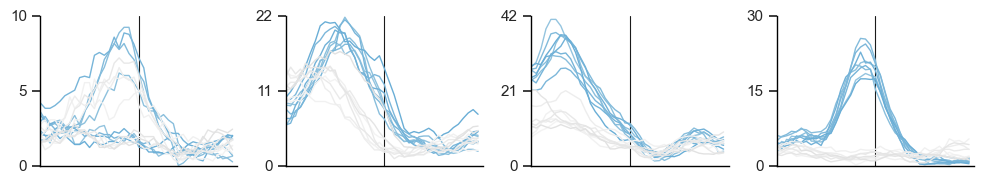

In [45]:
#Figure 3a
fig, axes = plt.subplots(1,4,figsize=(10, 2))
axes = axes.flatten()
shades_of_blue1 = plt.cm.Blues(np.linspace(.4, .5, 8))  
shades_of_blue2 = plt.cm.Greys(np.linspace(.1, .2, 8))  
colors = np.vstack((shades_of_blue1,shades_of_blue2)) 

window_size = 5
h=np.ones(window_size)/window_size
sessions=['cd11_cdnma_1','cd11_cdnma_5','cd10_cdnmb_1','cd11_cdnmb_5']
cell=[28,16,12,13]
ylims=[10,22,42,30]
all_rows = []  # collect each y_smoothed1 row here
row_labels = []  # optional: keep track of which session/val

for cc in range(0, 4):
    session_name=sessions[cc]
    i=cell[cc]
    y_lim=ylims[cc]
    with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    spikeTime = loaded_data["spikeTime"]
    Analysis_table_f = loaded_data["Analysis_table_f"]
    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (-1, 1),binduration=.05) #Trials by 
    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    axes[cc].plot([20, 20], [0, y_lim], 'k-', linewidth=.8)    
    for val_id, val in enumerate(u_vals):
        inds1 = Trials["vals_and_ID"]==val
    
        x=np.mean(spikes_all[0,inds1,i,:],0)
        x_padded_reflect = np.pad(x, (len(h)//2, len(h)//2), mode='reflect')
        y_smoothed1 = np.convolve(x_padded_reflect, h, mode='same')
        axes[cc].plot(y_smoothed1[2:-2],color=colors[val_id,:],linewidth=1) # without the padding and normalize to Hz
        # === collect row for Excel ===
        all_rows.append(y_smoothed1[2:-2])  # strip padding
        row_labels.append(f"session{cc}_val{val}")

    axes[cc].set_xlim(0, 40)
    axes[cc].set_ylim(0, y_lim)
    
    specific_ticks = [0, 20, 40]
    specific_labels = ['-1', '0', '1']

    axes[cc].set_xticks(specific_ticks)
    axes[cc].set_xticklabels(specific_labels,fontsize=8)
    axes[cc].set_yticks([0, y_lim/2, y_lim])

    axes[cc].yaxis.set_visible(True)
    axes[cc].xaxis.set_visible(False)
    
    axes[cc].spines['top'].set_visible(False)
    axes[cc].spines['right'].set_visible(False)
    axes[cc].spines['bottom'].set_visible(True)
    axes[cc].spines['left'].set_visible(True)
plt.tight_layout()
plt.show()
# === Save all rows to Excel ===
df_out = pd.DataFrame(all_rows, index=row_labels)
df_out.to_excel(f"{fig_path}/smoothed_traces.xlsx", index=True)

Paired t-test: t(193) = 1.04, p = 0.3009
Mean difference = 0.01, 95% CI [-0.01, 0.04]
Cohen's d = 0.07
Pre: mean = 0.08, SD = 0.73
Post: mean = 0.07, SD = 0.74
Paired t-test: t(205) = 2.56, p = 0.0113
Mean difference = 0.08, 95% CI [0.02, 0.13]
Cohen's d = 0.18
Pre: mean = 0.04, SD = 0.66
Post: mean = -0.04, SD = 0.44
Paired t-test: t(200) = 2.88, p = 0.0044
Mean difference = 0.07, 95% CI [0.02, 0.12]
Cohen's d = 0.20
Pre: mean = 0.07, SD = 0.64
Post: mean = -0.00, SD = 0.47
Paired t-test: t(205) = 3.58, p = 0.0004
Mean difference = 0.13, 95% CI [0.06, 0.20]
Cohen's d = 0.25
Pre: mean = 0.13, SD = 0.75
Post: mean = -0.00, SD = 0.54


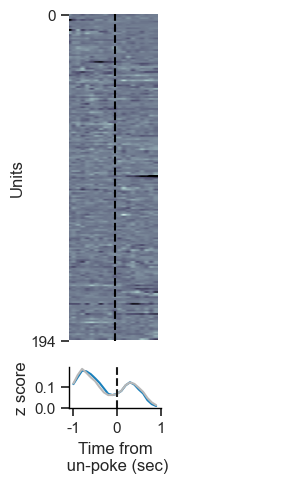

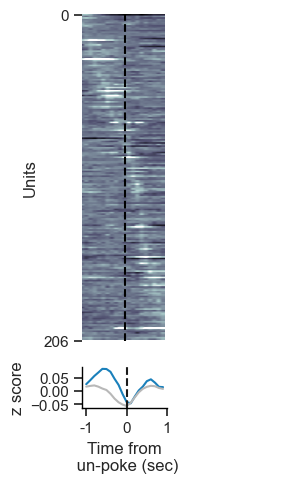

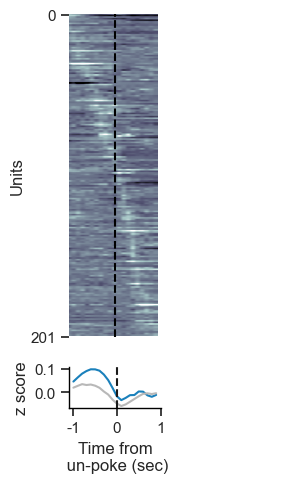

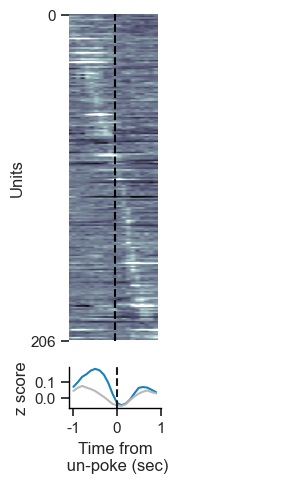

In [46]:
#figure 3b
for i in [0,4,5,9]:
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']
    session_names = df_sessions_f['session_names']
    Z_score_cdnm_go=[]
    Z_score_cdnm_nogo=[]
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        Analysis_table_f=loaded_data['Analysis_table_f']
        spikeTime = loaded_data['spikeTime']
        PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (-1,1),binduration=.1)
        nbins = spikes_all.shape[-1]  
        responsiveness = loaded_data['responsivness']
        p_responsive = loaded_data['result_dict_Zeta']['p_responsive']
        resp_units = p_responsive<0.001
        baseline_mean = responsiveness.FR_spont
        baseline_std = responsiveness.FR_spont_std
        baseline_std[baseline_std==0] = 1
        temp = baseline_mean.to_numpy()[:, np.newaxis]  
        replicated_baseline_mean = np.tile(temp, (1, nbins))
        temp = baseline_std.to_numpy()[:, np.newaxis]
        replicated_baseline_std = np.tile(temp, (1, nbins))
        spikes_all=np.squeeze(spikes_all)
        trials_idx = Trials.cdnm_rule == True
        mean_fr = np.mean(np.squeeze(spikes_all[trials_idx,:,:]),0)
        z_score_cdnm_go = (mean_fr - replicated_baseline_mean)/replicated_baseline_std    
        Z_score_cdnm_go.append(z_score_cdnm_go)    
        trials_idx = Trials.cdnm_rule == False    
        mean_fr = np.mean(np.squeeze(spikes_all[trials_idx,:,:]),0)
        z_score_cdnm_nogo = (mean_fr - replicated_baseline_mean)/replicated_baseline_std   
        Z_score_cdnm_nogo.append(z_score_cdnm_nogo)
    fig1,heat_map, y_smoothed, y_smoothed2=plot_zscore(Z_score_cdnm_go ,Z_score_cdnm_nogo ,color_go = color_set[0])
    ax = fig1.axes[1]
    ax.set_yticks([0, 0.1])
    fig1.savefig(f"{fig_path}/delta_z_{i}.png", dpi=300, bbox_inches="tight")

    # Put heat_map in a DataFrame
    df_heat = pd.DataFrame(heat_map)
    
    # Add smoothed traces as extra rows at the bottom
    df_heat.loc['y_smoothed'] = y_smoothed
    df_heat.loc['y_smoothed2'] = y_smoothed2

    
    # Save to Excel
    df_heat.to_excel(f"{fig_path}/zscore_{i}.xlsx", index=False)


    zScore_all = Z_score_cdnm_go
    zScore_all2 = Z_score_cdnm_nogo
    z_score = np.concatenate(zScore_all, axis=0)
    max_indices = np.argmax(z_score, axis=1)
    sorted_indices = np.argsort(max_indices)
    z_score_sorted = z_score[sorted_indices,:] 
    
    
    z_score2 = np.concatenate(zScore_all2, axis=0)
    z_score_sorted2 = z_score2[sorted_indices,:] 
    
    window_size = 5
    y_smoothed1 = np.mean(z_score[:,6:10],1)
    y_smoothed2 = np.mean(z_score2[:,6:10],1)

    from scipy.stats import ttest_ind, ttest_rel, t
    t_stat, p_val = ttest_rel(y_smoothed1, y_smoothed2)  # Welch's t-test
    n = len(y_smoothed1)
    df = n - 1
    diffs = y_smoothed1 - y_smoothed2
    cohens_d = diffs.mean() / diffs.std(ddof=1)  # paired-samples Cohen's d
    mean_diff = diffs.mean()
    se_diff = sem(diffs)  # standard error of the difference
    confidence = 0.95
    h = se_diff * t.ppf((1 + confidence) / 2., df)
    ci_low, ci_high = mean_diff - h, mean_diff + h
    print(f"Paired t-test: t({df}) = {t_stat:.2f}, p = {p_val:.4f}")
    print(f"Mean difference = {mean_diff:.2f}, 95% CI [{ci_low:.2f}, {ci_high:.2f}]")
    print(f"Cohen's d = {cohens_d:.2f}")
    print(f"Pre: mean = {y_smoothed1.mean():.2f}, SD = {y_smoothed1.std(ddof=1):.2f}")
    print(f"Post: mean = {y_smoothed2.mean():.2f}, SD = {y_smoothed2.std(ddof=1):.2f}")
    

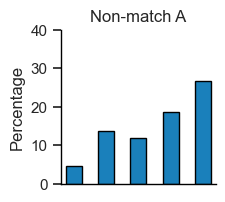

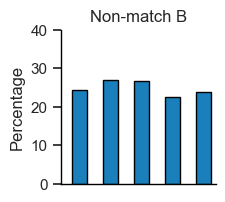

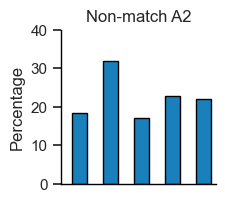

In [47]:
#Figure 3c-
df_zeta = pd.DataFrame()

for index, row in df_sessions.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        result_dict_Zeta = loaded_data['result_dict_Zeta']
        for i in range(len(result_dict_Zeta['p_responsive'])):


            new_row = pd.DataFrame([{
                'session_name': session_name,
                'session_title': session_title,
                'session_id': index,
                'p_responsive': result_dict_Zeta['p_responsive'][i],
                'p_cdnm': result_dict_Zeta['p_cdnm'][i],
                'p_disc': result_dict_Zeta['p_disc'][i]
            }])            
            df_zeta = pd.concat([df_zeta, new_row], ignore_index=True)

            # df_zeta = df_zeta.append({'session_name': session_name, 'session_title': session_title,'session_id': index, 'p_responsive': result_dict_Zeta['p_responsive'][i], 'p_cdnm': result_dict_Zeta['p_cdnm'][i], 'p_disc': result_dict_Zeta['p_disc'][i]}, ignore_index=True)

from matplotlib.colors import to_hex

df_zeta['both_conditions_cdnm'] = (df_zeta['p_responsive'] < 0.01) & (df_zeta['p_cdnm'] < 0.01)
df_zeta['both_conditions_disc'] = (df_zeta['p_responsive'] < 0.01) & (df_zeta['p_disc'] < 0.01)
df_zeta['three_conditions'] = (df_zeta['p_responsive'] < 0.01) & (df_zeta['p_disc'] < 0.01) & (df_zeta['p_cdnm'] < 0.01)
original_order = df_zeta['session_title'].unique()

result_cdnm = df_zeta.groupby('session_title')['both_conditions_cdnm'].mean(numeric_only=True)
result_disc = df_zeta.groupby('session_title')['both_conditions_disc'].mean(numeric_only=True)
result_both = df_zeta.groupby('session_title')['three_conditions'].mean(numeric_only=True)

result_cdnm_sorted = result_cdnm.loc[original_order]* 100
result_disc_sorted = result_disc.loc[original_order]* -100
result_both_sorted = result_both.loc[original_order]* 100
bottoms = result_both_sorted.to_numpy()/-2

color_cdnm = sns.color_palette('Set1')[0]
color_disc= sns.color_palette('Set1')[1]
mixture_color = sns.color_palette()[4]

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
color_cdnm=color_set[0]
color_disc=color_set[1]
mixture_color=color_set[2]
df_zeta_by_session=df_zeta.groupby(['session_id','session_name']).agg('mean',numeric_only=True)




fig, ax = plt.subplots(figsize=(2, 2))
result_cdnm_sorted.plot(kind='bar', color=color_cdnm, edgecolor='black',ax = ax)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
#ax.set_ylim(0,40)
plt.title('Non-match A')
plt.xlabel('')
plt.ylabel('Percentage')
yticks = ax.get_yticks()
ax.set_yticks(yticks)  # Explicitly fix the locator
ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])
ax.set_xlim(-.4,4.4)
plt.xticks(ticks=[])
plt.show()
fig.savefig(f"{fig_path}/3c1.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=(2, 2))  
result_cdnm_sorted.plot(kind='bar', color=color_cdnm, edgecolor='black',ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_ylim(0,40)
plt.title('Non-match B')
plt.xlabel('')
plt.ylabel('Percentage')
yticks = ax.get_yticks()
ax.set_yticks(yticks)  # Explicitly fix the locator
ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])
ax.set_xlim(4.4,9.4)
plt.xticks(ticks=[])  
plt.show()
fig.savefig(f"{fig_path}/3c2.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=(2, 2))  
result_cdnm_sorted.plot(kind='bar', color=color_cdnm, edgecolor='black',ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_ylim(0,40)
plt.title('Non-match A2')
plt.xlabel('')
plt.ylabel('Percentage')
yticks = ax.get_yticks()
ax.set_yticks(yticks)  # Explicitly fix the locator
ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])
ax.set_xlim(9.4,14.4)
plt.xticks(ticks=[])  
plt.show()
fig.savefig(f"{fig_path}/3c3.png", dpi=300, bbox_inches="tight")
# result_cdnm_sorted.to_excel(f"{fig_path}/3c.xlsx", index=False)


ks_statistic = 0.260, p_value_cdnm = 0.0022
ks_statistic = 0.127, p_value_disc = 1.1041, n1=159,n2=92
ks_statistic = 0.214, p_value_cdnm = 0.0255
ks_statistic = 0.183, p_value_disc = 0.1152, n1=166,n2=96
ks_statistic = 0.226, p_value_cdnm = 0.0223
ks_statistic = 0.160, p_value_disc = 0.3954, n1=167,n2=83
ks_statistic = 0.216, p_value_cdnm = 0.0267
ks_statistic = 0.210, p_value_disc = 0.0377, n1=159,n2=93


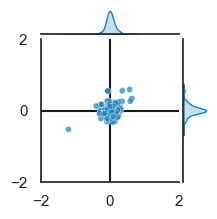

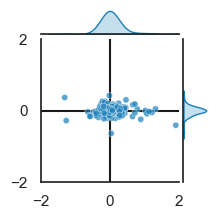

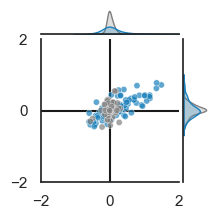

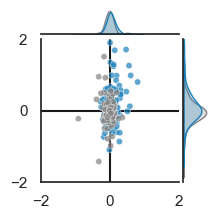

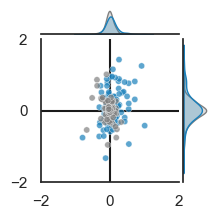

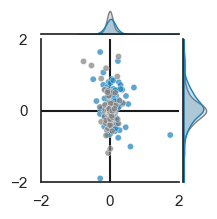

In [48]:
#Figure 4a,c
from scipy.stats import ks_2samp
sns.set_theme(style="white")  # Set the style for the plot
color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

Responsiveness_all = pd.DataFrame()
for index, row in df_sessions.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    Responsiveness = pd.DataFrame()

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        responsiveness = loaded_data['responsivness']
        if Responsiveness.empty:
            Responsiveness = pd.DataFrame(columns=responsiveness.columns)
        responsiveness['session_name'] = session_name
        responsiveness['session_title'] = session_title
        responsiveness['session_title_idx'] = index
        responsiveness['p_responsive'] = loaded_data['result_dict_Zeta']['p_responsive']
        responsiveness['z_cdnm_go']=(responsiveness.FR_cdnm_go-responsiveness.FR_spont)/responsiveness.FR_spont_std
        responsiveness['z_cdnm_nogo']=(responsiveness.FR_cdnm_nogo-responsiveness.FR_spont)/responsiveness.FR_spont_std
        responsiveness['z_disc_go']=(responsiveness.FR_disc_go-responsiveness.FR_spont)/responsiveness.FR_spont_std
        responsiveness['z_disc_nogo']=(responsiveness.FR_disc_nogo-responsiveness.FR_spont)/responsiveness.FR_spont_std

        Responsiveness = pd.concat([Responsiveness, responsiveness], ignore_index=True)

    if Responsiveness_all.empty:
        Responsiveness_all = pd.DataFrame(columns=Responsiveness.columns)
    #Responsiveness_all = Responsiveness_all.append(Responsiveness, ignore_index=True)
    Responsiveness_all = pd.concat([Responsiveness_all, Responsiveness], ignore_index=True)
color_set = ["#1a80bb"]
for i in [0,4]:
    
    
    Responsiveness_all_temp = Responsiveness_all[(Responsiveness_all['p_responsive']<0.001) & (Responsiveness_all.session_title_idx==i) ]
    Responsiveness_all_temp = Responsiveness_all_temp.copy()  # Ensure a new DataFrame copy
    Responsiveness_all_temp.loc[:, 'data1'] = (Responsiveness_all_temp['z_cdnm_go'] - Responsiveness_all_temp['z_cdnm_nogo'])
    Responsiveness_all_temp = Responsiveness_all_temp.copy()  # Ensure a new DataFrame copy
    Responsiveness_all_temp.loc[:, 'data2'] = (Responsiveness_all_temp['z_disc_go'] - Responsiveness_all_temp['z_disc_nogo'])
    g = sns.jointplot(data=Responsiveness_all_temp,
                      x='data1',
                      y='data2',
                      hue = 'session_title_idx',
                      palette=color_set,
                      marginal_kws=dict(common_norm=False),  # Normalize the KDEs separately for each hue level
                      xlim=(-2,2),ylim=(-2,2),
                      kind="scatter", s=20,alpha=.7,zorder=2
                      )
        
    main_ax = g.ax_joint
    main_ax.plot([-2,2],[0,0],'k',alpha = 1,zorder=1)
    main_ax.plot([0,0],[-2,2],'k',alpha = 1,zorder=1)
    g.ax_joint.set_xticks([-2, 0, 2])
    g.ax_joint.set_yticks([-2, 0, 2])    
    g.set_axis_labels("", "")
    marg_x_ax = g.ax_marg_x  # X-axis marginal axis
    main_ax.legend_.remove()
    fig = g.fig
    fig.set_size_inches(2, 2)  # Width, height in inches
    fig.savefig(f"{fig_path}/4a{i}.png", dpi=300, bbox_inches="tight")

    # --- Save source data for this plot ---
    out_path = f"{fig_path}/4a{i}_data.xlsx"
    Responsiveness_all_temp[["session_title_idx", "data1", "data2"]].to_excel(
        out_path, index=False
    )

color_set = ["#1a80bb", 'grey']
for i in [15,19,20,24]:

    Responsiveness_all_temp = Responsiveness_all[(Responsiveness_all['p_responsive']<0.001) & ((Responsiveness_all.session_title_idx==i) | (Responsiveness_all.session_title_idx==i+10)) ]
    Responsiveness_all_temp = Responsiveness_all_temp.copy()  # Ensure a new DataFrame copy
    Responsiveness_all_temp.loc[:, 'data1'] = (Responsiveness_all_temp['z_cdnm_go'] - Responsiveness_all_temp['z_cdnm_nogo'])
    Responsiveness_all_temp = Responsiveness_all_temp.copy()  # Ensure a new DataFrame copy
    Responsiveness_all_temp.loc[:, 'data2'] = (Responsiveness_all_temp['z_disc_go'] - Responsiveness_all_temp['z_disc_nogo'])
    Responsiveness_all_temp2 = Responsiveness_all_temp.copy()
    Responsiveness_all_temp2.loc[Responsiveness_all_temp2['data1'] > 2, 'data1'] = np.nan
    Responsiveness_all_temp2.loc[Responsiveness_all_temp2['data2'] > 2, 'data2'] = np.nan
    
    g = sns.jointplot(data=Responsiveness_all_temp2,
                      x='data1',
                      y='data2',
                      hue = 'session_title_idx',
                      palette=color_set,  # Use a predefined palette, or you can use custom colors like ['#FF6347', '#4682B4']
                      marginal_kws=dict(common_norm=False),  # Normalize the KDEs separately for each hue level
                      xlim=(-2,2),ylim=(-2,2),
                      kind="scatter", zorder=2, s=20,alpha=.7
                      )
    main_ax = g.ax_joint
    main_ax.plot([-2,2],[0,0],'k',alpha = 1,zorder=1)
    main_ax.plot([0,0],[-2,2],'k',alpha = 1,zorder=1)
    marg_x_ax = g.ax_marg_x  # X-axis marginal axis
    
    group_A = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i]['data1']
    group_B = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i+10]['data1']
    ks_statistic, p_value_cdnm = ks_2samp(group_A, group_B)# Run the Kolmogorov-Smirnov test and correct for multiple comparison
    print(f"ks_statistic = {ks_statistic:.3f}, p_value_cdnm = {p_value_cdnm*4:.4f}")

    group_A = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i]['data2']
    group_B = Responsiveness_all_temp[Responsiveness_all_temp['session_title_idx'] == i+10]['data2']
    ks_statistic, p_value_disc = ks_2samp(group_A, group_B)# Run the Kolmogorov-Smirnov test and correct for multiple comparison
    print(f"ks_statistic = {ks_statistic:.3f}, p_value_disc = {p_value_disc*4:.4f}, n1={len(group_A)},n2={len(group_B)}")

    main_ax.legend_.remove()
    g.ax_joint.set_xticks([-2, 0, 2])
    g.ax_joint.set_yticks([-2, 0, 2])    
    g.set_axis_labels("", "")
    fig = g.fig    
    fig.set_size_inches(2, 2)  # Width, height in inches
    fig.savefig(f"{fig_path}/4c{i}.png", dpi=300, bbox_inches="tight")

    # --- Save source data for this plot ---
    out_path = f"{fig_path}/4a{i}_data.xlsx"
    Responsiveness_all_temp[["session_title_idx", "data1", "data2"]].to_excel(
        out_path, index=False
    )


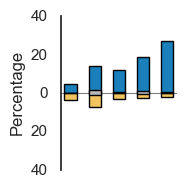

In [49]:
# #figure 4b
fig, ax = plt.subplots(figsize=(1.5, 2))  # Adjust the width and height as needed
ax.axhline(0, color='gray', linewidth=0.8, linestyle='-',zorder=1)  # Zero line for context (not inside bars)

result_cdnm_sorted.plot(kind='bar', color=color_cdnm, edgecolor='black',ax = ax,zorder=2)
result_disc_sorted.plot(kind='bar', color=color_disc, edgecolor='black',ax = ax,zorder=2)
result_both_sorted.plot(kind='bar', color=mixture_color, edgecolor='black',bottom = bottoms,ax = ax,zorder=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(-40,40)
plt.title('')
plt.xlabel('')
plt.ylabel('Percentage')
yticks = ax.get_yticks()
ax.set_yticks(yticks)  # Explicitly fix the locator
ax.set_yticklabels([f"{abs(int(label))}" for label in ax.get_yticks()])
plt.xticks(ticks=[])
# ax.legend_.remove()     # works if a legend was automatically created
ax.set_xlim(-.4,4.4)
plt.show()
fig.savefig(f"{fig_path}/4b.png", dpi=300, bbox_inches="tight")

result_cdnm_sorted.to_excel(f"{fig_path}/4b1.xlsx", index=False)
result_disc_sorted.to_excel(f"{fig_path}/4b2.xlsx", index=False)
result_both_sorted.to_excel(f"{fig_path}/4b3.xlsx", index=False)


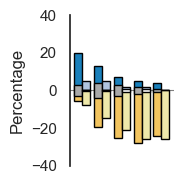

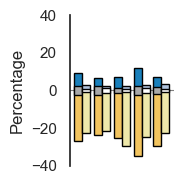

                   Effect     F  df1  df2        p  partial η²         95% CI
         C(session_index)  1.90    9   67 0.066971       0.203   [0.762, 1.0]
                 C(group) 14.46    1   67 0.000313       0.177 [0.972, 0.749]
C(session_index):C(group)  0.51    9   67 0.865031       0.064   [0.379, 1.0]
                   Effect    F  df1  df2        p  partial η²       95% CI
         C(session_index) 1.78    9   67 0.087621       0.193 [0.751, 1.0]
                 C(group) 0.04    1   67 0.841098       0.001 [0.789, 1.0]
C(session_index):C(group) 0.13    9   67 0.998749       0.017   [0.0, 1.0]
                   Effect    F  df1  df2        p  partial η²         95% CI
         C(session_index) 0.69    9   67 0.716632       0.085   [0.506, 1.0]
                 C(group) 6.99    1   67 0.010193       0.094 [0.956, 0.272]
C(session_index):C(group) 0.46    9   67 0.899244       0.058   [0.325, 1.0]


In [50]:
#figure 4d
e_cdnm=result_cdnm_sorted.iloc[15:20].values
e_disc=result_disc_sorted.iloc[15:20].values
e_both=result_both_sorted.iloc[15:20].values

c_cdnm=result_cdnm_sorted.iloc[25:30].values
c_disc=result_disc_sorted.iloc[25:30].values
c_both=result_both_sorted.iloc[25:30].values

x1=[1,3,5,7,9]
x2=[2,4,6,8,10]

df=pd.DataFrame({'x1':x1,'x2':x2,'e_cdnm':e_cdnm,'e_disc':e_disc,'e_both':e_both,'c_cdnm':c_cdnm,'c_disc':c_disc,'c_both':c_both})
group1 = df[['e_cdnm', 'e_disc', 'e_both']]
group2 = df[['c_cdnm', 'c_disc', 'c_both']]
group1.columns = ['cdnm', 'disc', 'both']
group2.columns = ['cdnm', 'disc', 'both']
concatenated_df = pd.concat([group1, group2], ignore_index=False)
concatenated_df['Group'] = ['exp'] * len(group1) + ['control'] * len(group2)
concatenated_df['Index']=concatenated_df.index
data=concatenated_df
exp_data = data[data['Group'] == 'exp']
control_data = data[data['Group'] == 'control']
bar_width = 0.4
index = np.arange(len(exp_data))  # Positions for groups

fig, ax = plt.subplots(figsize=(2, 2))  # Adjust the width and height as needed
ax.axhline(0, color='gray', linewidth=0.8, linestyle='-',zorder=1)  # Zero line for context (not inside bars)
ax.bar(index - bar_width / 2, exp_data['cdnm'], bar_width, color='#1a80bb', label='cdnm (exp)', edgecolor='black',zorder=2)
ax.bar(index - bar_width / 2, exp_data['disc'], bar_width, color='#f2c45f', label='disc (exp)', edgecolor='black',zorder=2)

ax.bar(index - bar_width / 2, exp_data['both'], bar_width, bottom=-exp_data['both'] / 2,
       color='darkgray', label='both (exp)', edgecolor='black', alpha=1,zorder=2)

ax.bar(index + bar_width / 2, control_data['cdnm'], bar_width, color='lightsteelblue', label='cdnm (control)', edgecolor='black',zorder=2)
ax.bar(index + bar_width / 2, control_data['disc'], bar_width, color='palegoldenrod', label='disc (control)', edgecolor='black',zorder=2)

ax.bar(index + bar_width / 2, control_data['both'], bar_width, bottom=-control_data['both'] / 2,
       color='white', label='both (control)', edgecolor='black', alpha=1,zorder=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(-40,40)
plt.title('')
plt.xlabel('')
plt.ylabel('Percentage')
plt.xticks(ticks=[])

ax.grid(False)
plt.tight_layout()
plt.show()
fig.savefig(f"{fig_path}/4d1.png", dpi=300, bbox_inches="tight")

e_cdnm=result_cdnm_sorted.iloc[20:25].values
e_disc=result_disc_sorted.iloc[20:25].values
e_both=result_both_sorted.iloc[20:25].values

c_cdnm=result_cdnm_sorted.iloc[30:35].values
c_disc=result_disc_sorted.iloc[30:35].values
c_both=result_both_sorted.iloc[30:35].values

x1=[1,3,5,7,9]
x2=[2,4,6,8,10]

df=pd.DataFrame({'x1':x1,'x2':x2,'e_cdnm':e_cdnm,'e_disc':e_disc,'e_both':e_both,'c_cdnm':c_cdnm,'c_disc':c_disc,'c_both':c_both})
group1 = df[['e_cdnm', 'e_disc', 'e_both']]
group2 = df[['c_cdnm', 'c_disc', 'c_both']]
group1.columns = ['cdnm', 'disc', 'both']
group2.columns = ['cdnm', 'disc', 'both']
concatenated_df = pd.concat([group1, group2], ignore_index=False)
concatenated_df['Group'] = ['exp'] * len(group1) + ['control'] * len(group2)
concatenated_df['Index']=concatenated_df.index
data=concatenated_df
exp_data = data[data['Group'] == 'exp']
control_data = data[data['Group'] == 'control']
bar_width = 0.4
index = np.arange(len(exp_data))  # Positions for groups
fig, ax = plt.subplots(figsize=(2, 2))  # Adjust the width and height as needed
ax.axhline(0, color='gray', linewidth=0.8, linestyle='-',zorder=1)  # Zero line for context (not inside bars)
ax.bar(index - bar_width / 2, exp_data['cdnm'], bar_width, color='#1a80bb', label='cdnm (exp)', edgecolor='black',zorder=2)
ax.bar(index - bar_width / 2, exp_data['disc'], bar_width, color='#f2c45f', label='disc (exp)', edgecolor='black',zorder=2)
ax.bar(index - bar_width / 2, exp_data['both'], bar_width, bottom=-exp_data['both'] / 2,
       color='darkgray', label='both (exp)', edgecolor='black', alpha=1,zorder=2)
ax.bar(index + bar_width / 2, control_data['cdnm'], bar_width, color='lightsteelblue', label='cdnm (control)', edgecolor='black',zorder=2)
ax.bar(index + bar_width / 2, control_data['disc'], bar_width, color='palegoldenrod', label='disc (control)', edgecolor='black',zorder=2)
ax.bar(index + bar_width / 2, control_data['both'], bar_width, bottom=-control_data['both'] / 2,
       color='white', label='both (control)', edgecolor='black', alpha=1,zorder=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(-40,40)
plt.title('')
plt.xlabel('')
plt.ylabel('Percentage')
plt.xticks(ticks=[])
ax.grid(False)
plt.tight_layout()
plt.show()
fig.savefig(f"{fig_path}/4d2.png", dpi=300, bbox_inches="tight")

result_disc = df_zeta.groupby(['session_title','session_name'])[['both_conditions_cdnm','both_conditions_disc','three_conditions']].mean()
result_disc_sorted = result_disc.loc[original_order]
session_titles = result_disc_sorted.index.get_level_values('session_title').unique()

experimental_titles = session_titles[15:25]  
control_titles = session_titles[25:35]       

df_filtered = result_disc_sorted.loc[
    result_disc_sorted.index.get_level_values('session_title').isin(
        experimental_titles.union(control_titles)
    )
].copy()

# Step 4: Reset index so session_title becomes a column
df_filtered = df_filtered.reset_index()

# Step 5: Create the group column
df_filtered['group'] = df_filtered['session_title'].apply(
    lambda x: 'experimental' if x in experimental_titles else 'control'
)

# Step 6: Convert to categorical types
df_filtered['group'] = df_filtered['group'].astype('category')
df_filtered['session_title'] = df_filtered['session_title'].astype('category')
# 

# Define ordinal mapping
ordinal_map = {
    'first': 0,
    'second': 1,
    'third': 2,
    'forth': 3,
    'last': 4
}

# Mapping function
def map_session_index(title):
    parts = title.lower().split()

    # Must contain at least 3 parts: e.g., ['cue-identity', 'a', 'first']
    if len(parts) >= 3:
        group = parts[1]  # 'a' or 'b'
        ordinal = parts[2]  # 'first', 'second', etc.

        group_offset = 0 if group == 'a' else 5
        ordinal_index = ordinal_map.get(ordinal, -1)

        if ordinal_index >= 0:
            return group_offset + ordinal_index
    return -1  # if format doesn't match

# Apply to DataFrame
df_filtered['session_index'] = df_filtered['session_title'].apply(map_session_index)
df_filtered = df_filtered[df_filtered['session_index'] >= 0]  # filter valid mappings
df_filtered['session_index'] = df_filtered['session_index'].astype('category')

model = ols('both_conditions_cdnm ~ C(session_index) * C(group)', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))

model = ols('both_conditions_disc ~ C(session_index) * C(group)', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))

model = ols('three_conditions ~ C(session_index) * C(group)', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))
# result_disc_sorted.to_excel(f"{fig_path}/4d.xlsx", merge_cells=True)


target cdnm:	sum_1=1.00	sum_0=-1.00
target identity:	sum_1=1.00	sum_0=-1.00
target common:	sum_1=1.00	sum_0=-1.00


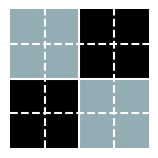

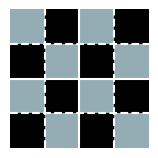

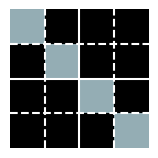

In [51]:
# Figure 6a
import copy

def make_run(n,value):
    output = []
    for i in range(0,n):
        output.append(value)
    return(output)

def generate_target_matrix(k,target):

    if target == 'cdnm':
        nblocks = 2
    elif target == 'identity':
        nblocks = 4
    elif target == 'common':
        nblocks = 4
    else:
        assert False

    nrows_per_block = round(k/nblocks)

    rows = list()

    toggle_block = 1
    for ib in range(0,nblocks):

        row = []
        toggle_row = toggle_block
        for i in range(0,nblocks):

            if target == 'common':
                if i == ib:
                    row = row + make_run(nrows_per_block,1)
                else:
                    row = row + make_run(nrows_per_block,0)
            else:
                # both CDNM and identity            
                row = row + make_run(nrows_per_block,toggle_row)

            toggle_row = (1-toggle_row)
        rows.append(row)

        toggle_block = (1-toggle_block)
    target = np.tile(rows[0],(nrows_per_block,1))

    for ib in range(1,nblocks):
        block = np.tile(rows[ib],(nrows_per_block,1))
        target = np.concatenate((target,block),axis=0)

    return target


k = 16
targets = ['cdnm','identity','common']
targets_off_diag = ['cdnm','identity','common']

ntargets = len(targets)

target_matrices = list()

for it,target in enumerate(targets):
    # one of the three targets you specified
    #target_matrices.append(np.abs(generate_target_matrix(k,target)-1))
    target_matrices.append(generate_target_matrix(k,target))
off_diag_target= target_matrices[1] & ~target_matrices[2]

indices_diagonal = np.diag_indices(k)

scoring_matrices = copy.deepcopy(target_matrices)

for it,target in enumerate(targets):

    scoring_matrix = (scoring_matrices[it]).astype('float')

    # dummy value to exclude diagonal
    scoring_matrix[indices_diagonal] = 2

    # find ones / zeros, compute ratio,
    (indices_ones_rows,indices_ones_cols)   = np.where(scoring_matrix==1)
    n1 = len(indices_ones_rows)
    (indices_zeros_rows,indices_zeros_cols) = np.where(scoring_matrix==0)
    n0 = len(indices_zeros_rows)
    ratio = n0/n1
    #indices_ones[target] = [indices_ones_rows,indices_ones_cols]

    # set ones to the ratio
    scoring_matrix[indices_ones_rows,indices_ones_cols] = ratio

    # set zeros to -1 
    scoring_matrix[indices_zeros_rows,indices_zeros_cols] = -1

    # normalize so that the weights of the ones add up to 1 (same for -1)
    values = scoring_matrix[indices_ones_rows,indices_ones_cols]
    total  = np.sum(values)
    scoring_matrix = scoring_matrix / total

    #check normalization
    tmp = scoring_matrix[indices_ones_rows,indices_ones_cols]
    total_ones = np.sum(tmp)
    tmp = scoring_matrix[indices_zeros_rows,indices_zeros_cols]
    total_zeros = np.sum(tmp)
    print('target %s:\tsum_1=%1.2f\tsum_0=%1.2f' % (target,total_ones,total_zeros))

    # store
    scoring_matrices[it] = copy.deepcopy(scoring_matrix)
file_path = os.path.join(save_path, "scoring_matrix_cdnm.npy")
scoring_matrices[0]=np.load(file_path)

file_path = os.path.join(save_path, "scoring_matrix_identity.npy")
scoring_matrices[1]=np.load(file_path)

file_path = os.path.join(save_path, "scoring_matrix_common.npy")
scoring_matrices[2]=np.load(file_path)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs(fig_path, exist_ok=True)

for i in [0, 1, 2]:
    M = np.asarray(target_matrices[i])

    # --- save numeric matrix to Excel (one file per matrix) ---
    pd.DataFrame(M).to_excel(f"{fig_path}/target_matrix_{i}.xlsx",
                             index=False, header=False)

    # --- plot & save image ---
    fig, ax1 = plt.subplots(figsize=(1.8, 1.8))
    cax = ax1.imshow(M, cmap='bone', interpolation='nearest', vmin=0, vmax=1.5)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    for side in ['top', 'right', 'bottom', 'left']:
        ax1.spines[side].set_visible(False)

    ax1.axhline(y=7.5,  color='w', linestyle='-')
    ax1.axvline(x=7.5,  color='w', linestyle='-')
    ax1.axhline(y=3.5,  color='w', linestyle='--')
    ax1.axvline(x=3.5,  color='w', linestyle='--')
    ax1.axhline(y=11.5, color='w', linestyle='--')
    ax1.axvline(x=11.5, color='w', linestyle='--')

    fig.savefig(f"{fig_path}/target_matrix_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


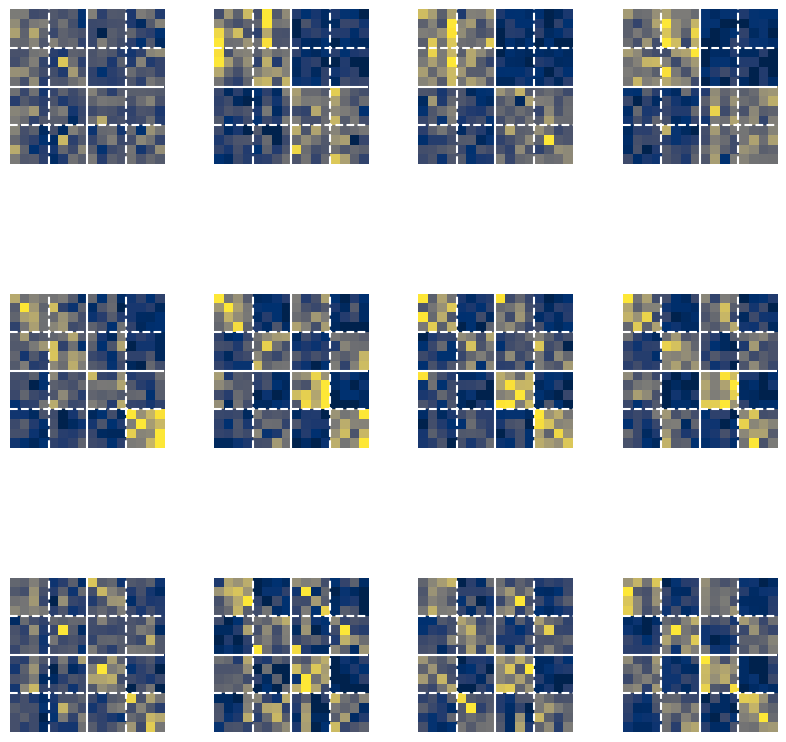

In [52]:
#Fig 6b-d
fig, axes = plt.subplots(3, 4, figsize=(8, 10))
axes_flat = axes.flatten()
for index,i in enumerate([0,4,5,9,15,19,20,24,25,29,30,34]):
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']
    session_names=df_sessions_f['session_names']
    CM=[]
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        cm_cdnm=loaded_data['SVM']['vals_and_ID']['cm']
        #cm_cdnm = loaded_data["cm_similarity_pca_epochs"]
        CM.append(cm_cdnm)
    cm_cdnm=np.mean(CM,axis=0)

    axes_flat[index].imshow(cm_cdnm, cmap = 'cividis', interpolation='nearest',vmin=0, vmax=0.2)
    axes_flat[index].axes.get_xaxis().set_visible(False)  # Hide x-axis ticks and labels
    axes_flat[index].axes.get_yaxis().set_visible(False)  # Hide x-axis ticks and labels

    axes_flat[index].spines['top'].set_visible(False)  # Hide top spine/frame
    axes_flat[index].spines['right'].set_visible(False)  # Hide right spine/frame
    axes_flat[index].spines['bottom'].set_visible(False)  # Hide bottom spine/frame
    axes_flat[index].spines['left'].set_visible(False)  # Hide left spine/frame

    axes_flat[index].axhline(y=7.5, color='w', linestyle='-')
    axes_flat[index].axvline(x=7.5, color='w', linestyle='-')

    axes_flat[index].axhline(y=3.5, color='w', linestyle='--')
    axes_flat[index].axvline(x=3.5, color='w', linestyle='--')

    axes_flat[index].axhline(y=11.5, color='w', linestyle='--')
    axes_flat[index].axvline(x=11.5, color='w', linestyle='--')

plt.subplots_adjust(hspace=0.1, wspace=0.3)  # reduce hspace for tighter rows
fig.tight_layout(pad=1.0, h_pad=0, w_pad=3)

plt.show()
fig.savefig(f"{fig_path}/5b-d.png", dpi=300, bbox_inches="tight")


/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1377778420.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


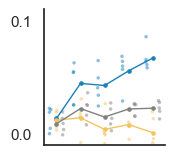

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1377778420.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


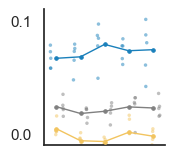

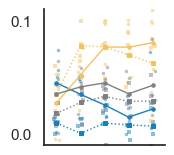

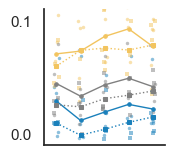

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_15306/1377778420.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Mann–Whitney U test: U = 1322.00, p = 0.0008, n1 = 49, n2 = 38
                   Effect     F  df1  df2        p  partial η²         95% CI
         C(session_index)  1.08    4   35 0.381430       0.110   [0.757, 1.0]
                 C(group) 14.28    1   35 0.000589       0.290 [0.972, 0.721]
C(session_index):C(group)  0.99    4   35 0.423844       0.102   [0.745, 1.0]
                   Effect    F  df1  df2        p  partial η²        95% CI
         C(session_index) 5.12    4   35 0.002363       0.369 [0.913, 0.42]
                 C(group) 0.06    1   35 0.811338       0.002  [0.805, 1.0]
C(session_index):C(group) 0.97    4   35 0.435247       0.100  [0.742, 1.0]
                   Effect    F  df1  df2        p  partial η²         95% CI
         C(session_index) 0.59    4   35 0.669163       0.064    [0.66, 1.0]
                 C(group) 5.61    1   35 0.023512       0.138 [0.951, 0.022]
C(session_index):C(group) 0.10    4   35 0.980575       0.012     [0.0, 1.0]


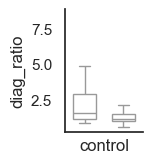

In [53]:
 #Figure 6e-g
npermutations = 1000

scores_permute= dict()
scores_data= dict()
df_sim=pd.DataFrame()

df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<35)]
CM_session=[]
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    CM=[]
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        cm_cdnm=loaded_data['SVM']['vals_and_ID']['cm']
        #cm_cdnm = loaded_data["cm_similarity_pca_epochs"]

        #CM.append(cm_cdnm)
        #cm_cdnm=np.mean(CM,axis=0)  


        scores = np.zeros((ntargets))
        p_value = np.zeros((ntargets))
        scores_perm = np.zeros((ntargets,npermutations))
        off_diag = np.mean(cm_cdnm[off_diag_target.astype(bool)])
        in_diag = np.mean(cm_cdnm[target_matrices[2].astype(bool)])
        diag_ratio= in_diag/off_diag

        # calculate the three scores for each permutation
        for ip in range(0,npermutations):
            permutation_here = np.random.permutation(k)
            permutation_here2 = np.random.permutation(k)

            permuted_data_matrix = copy.deepcopy(cm_cdnm)
            reference_here = np.arange(0,k,dtype=int)

            permuted_data_matrix[reference_here,:] = permuted_data_matrix[permutation_here,:]
            permuted_data_matrix[:,reference_here] = permuted_data_matrix[:,permutation_here2]

            for it,target in enumerate(targets):
                scoring_matrix = scoring_matrices[it]
                target_matrix = target_matrices[it]

                tmp = np.sum(np.sum(np.multiply(scoring_matrix,permuted_data_matrix)))
                scores_perm[it,ip] = tmp
                # calculate the three scores for each real matrix
        for it,target in enumerate(targets):
            scoring_matrix = scoring_matrices[it]
            target_matrix = target_matrices[it]
            scores[it] = np.sum(np.sum(np.multiply(scoring_matrix,cm_cdnm)))
            p_value[it] = ((1+np.sum(scores_perm[it,:]>= scores[it]) )/ (1+npermutations))
        new_row = pd.DataFrame([{
            'session_name': session_name,
            'session_title': session_title,
            'session_title_idx': index,
            'cdnm_sim': scores[0],
            'disc_sim': scores[1],
            'both_sim': scores[2],
            'cdnm_sim_p': p_value[0],
            'disc_sim_p': p_value[1],
            'both_sim_p': p_value[2],
            'in_diag': in_diag,
            'off_diag': off_diag,
            'diag_ratio': diag_ratio
        }])            
        df_sim = pd.concat([df_sim, new_row], ignore_index=True)
def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]
    return pd.cut([value], bins=bins, labels=labels, right=False)[0]

df_sim['bin_column'] = df_sim['session_title_idx'].apply(categorize_into_bins)

color_set = ["#1a80bb", "#8cc5e3","#f2c45f","#eddca5"]
color_set = ["#1a80bb", "#f2c45f","gray"]

melted_df = pd.melt(df_sim, id_vars=[ 'session_name','session_title','session_title_idx','bin_column'], value_vars=['cdnm_sim','disc_sim','both_sim'], var_name='sim_type', value_name='sim_value')

for i in [1,2]:
    
    data = melted_df[((melted_df.bin_column==i)) ]
    
    g = sns.catplot(
        data=data, x="session_title_idx", y="sim_value", hue="sim_type",
        capsize=.2, palette=color_set, kind="point",
        height=2.2, aspect=1,
        linestyles=["-", "-", "-"], linewidth=1,
        markers=["o", "o", "o"],
        zorder=10,
        legend=False, ci=None
    )
    
    # --- Overlay individual datapoints ---
    ax = g.ax
    sns.stripplot(
        data=data, x="session_title_idx", y="sim_value", hue="sim_type",
        dodge=True, palette=color_set, size=2.5,
        alpha=0.5, jitter=True, ax=ax, zorder=1
    )
    
    ax.legend_.remove()    
    # Formatting
    g.fig.tight_layout(w_pad=1)
    g.set_titles(""); g.despine(left=False, bottom=False, top=True)
    g.set(ylabel='', xlabel='', xticks=[], yticks=[0, .1], title='', ylim=(-.01, .11))

    plt.show()
    g.savefig(f"{fig_path}/6e{i}.png", dpi=300, bbox_inches="tight")

color_set = ["#1a80bb", "#1a80bb","#f2c45f","#f2c45f",'gray','gray']

melted_df = pd.melt(df_sim, id_vars=[ 'session_name','session_title','session_title_idx','bin_column'], value_vars=['cdnm_sim','disc_sim','both_sim'], var_name='sim_type', value_name='sim_value')

for i in [4,5]:
    data = melted_df[((melted_df.bin_column==i) | (melted_df.bin_column==i+2)) ]
    data = data.copy()
    data['session_title_idx'] = data['session_title_idx'].apply(lambda x: x - 10 if x >= 25 else x)
    data['combined'] = data['sim_type'] + ' - Bin ' + data['bin_column'].astype(str)
    
    # Main pointplot (group means with error bars)
    g = sns.catplot(
        data=data, x="session_title_idx", y="sim_value",
        hue="combined", 
        capsize=.2, palette=color_set,
        kind="point", height=2.2, aspect=1,
        estimator=np.mean,
        linestyles=["-", ":", "-", ":", "-", ":"],
        linewidth=1,
        markers=["o", "s", "o", "s", "o", "s"],   # circle vs square
        zorder=10,
        legend=False, errorbar=None
    )
    
    ax = g.ax
    
    # --- Overlay raw points ---
    # Loop through groups in 'combined' to assign markers manually
    unique_groups = data['combined'].unique()
    markers=["o", "s", "o", "s", "o", "s"]  # circle vs square
    
    for gr, group in enumerate(unique_groups):
        sub = data[data['combined'] == group]
        m = markers[gr]  # default "o" if not in map
        sns.stripplot(
            data=sub, x="session_title_idx", y="sim_value",
            dodge=True, jitter=True, size=2.5,
            alpha=0.5, marker=m, color=color_set[gr],
            ax=ax, zorder=1
        )
    
    
    # Formatting
    g.fig.tight_layout(w_pad=1)
    g.set_titles("")
    g.despine(left=False, bottom=False, top=True)
    g.set(ylabel='', xlabel='', xticks=[], yticks=[0, .1], title='', ylim=(-.01, .11))

    
    plt.show()
    g.savefig(f"{fig_path}/6f{i}.png", dpi=300, bbox_inches="tight")

color_set = ["w", "w"]

data = df_sim[((df_sim.bin_column==4) | (df_sim.bin_column==5) |
               (df_sim.bin_column==6) | (df_sim.bin_column==7)) ].copy()
data['session_title_idx'] = data['session_title_idx'].apply(lambda x: x - 10 if x >= 25 else x)
data['control'] = data['session_title'].str.contains('control', case=False, na=False).astype(int)

fig, ax = plt.subplots(figsize=(1, 1.6))
sns.boxplot(
    data=data, x="control", y="diag_ratio",
    palette=color_set, width=0.6, fliersize=0,  # fliersize=0 hides outlier dots
    ax=ax
)

# Statistical test
grouped_values = {group: values.tolist() for group, values in data.groupby('control').diag_ratio}
stat_U, p_value = mannwhitneyu(grouped_values[0], grouped_values[1], alternative='two-sided')
print(f"Mann–Whitney U test: U = {stat_U:.2f}, p = {p_value:.4f}, "
      f"n1 = {len(grouped_values[0])}, n2 = {len(grouped_values[1])}")

ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_path}/6e{i}.png", dpi=300, bbox_inches="tight")


session_titles = df_sim['session_title'].drop_duplicates()

experimental_titles = session_titles.iloc[15:20]  
control_titles = session_titles.iloc[25:30]       
# Step 3: Filter df_sim
df_filtered = df_sim[df_sim['session_title'].isin(experimental_titles.tolist() + control_titles.tolist())].copy()

# Optional: Add group label
df_filtered['group'] = df_filtered['session_title'].apply(
    lambda x: 'experimental' if x in experimental_titles.values else 'control'
)

# Step 6: Convert to categorical types
df_filtered['group'] = df_filtered['group'].astype('category')
df_filtered['session_title'] = df_filtered['session_title'].astype('category')
# 

# Define ordinal mapping
ordinal_map = {
    'first': 0,
    'second': 1,
    'third': 2,
    'forth': 3,
    'last': 4
}

# Mapping function
def map_session_index(title):
    parts = title.lower().split()

    # Must contain at least 3 parts: e.g., ['cue-identity', 'a', 'first']
    if len(parts) >= 3:
        group = parts[1]  # 'a' or 'b'
        ordinal = parts[2]  # 'first', 'second', etc.

        group_offset = 0 if group == 'a' else 5
        ordinal_index = ordinal_map.get(ordinal, -1)

        if ordinal_index >= 0:
            return group_offset + ordinal_index
    return -1  # if format doesn't match

# Apply to DataFrame
df_filtered['session_index'] = df_filtered['session_title'].apply(map_session_index)
df_filtered = df_filtered[df_filtered['session_index'] >= 0]  # filter valid mappings
df_filtered['session_index'] = df_filtered['session_index'].astype('category')

# Run the two-way ANOVA
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols('cdnm_sim ~ C(session_index) * C(group)', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))

model = ols('disc_sim ~ C(session_index) * C(group)', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))

model = ols('both_sim ~ C(session_index) * C(group)', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

eta_table = add_eta2_ci_from_anova(anova_table, alpha=0.05, digits=3)
print(eta_table.to_string(index=False))


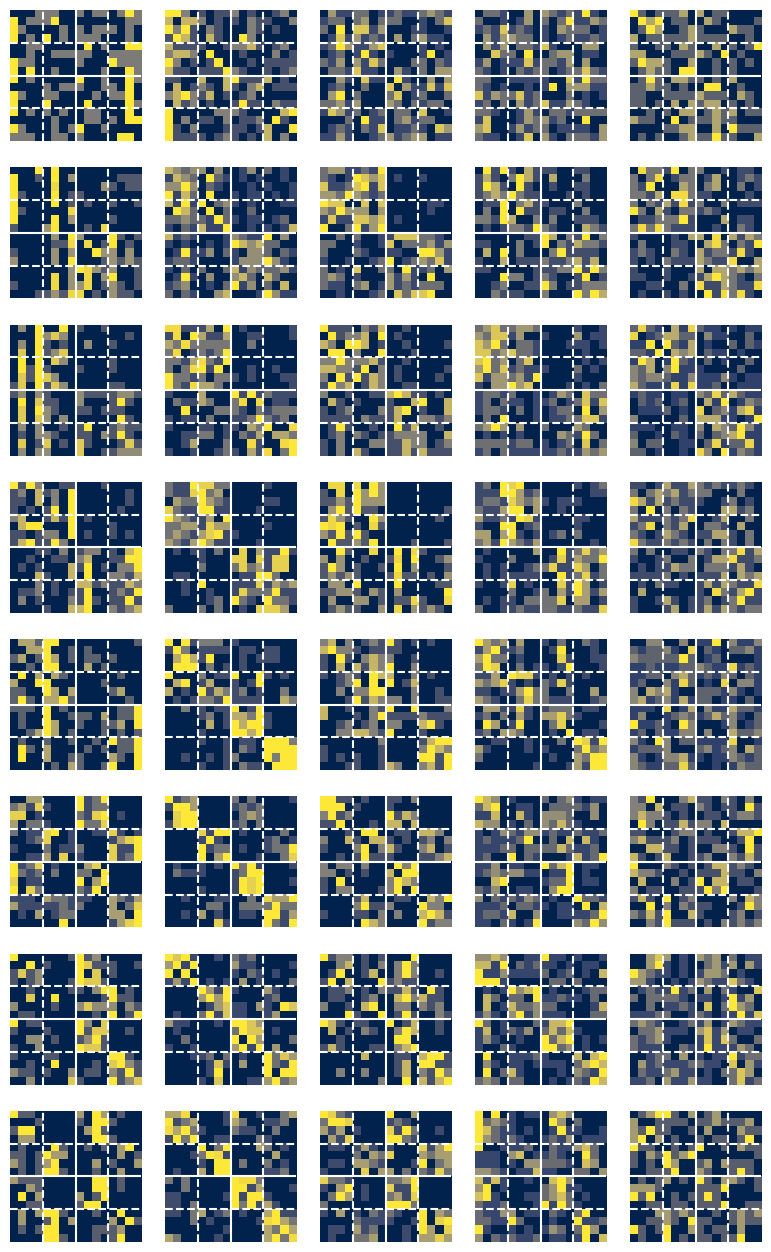

In [54]:
#Supplementary Figure 5
fig, axes = plt.subplots(8, 5, figsize=(10, 16))
axes_flat = axes.flatten()

for index,i in enumerate([0,4,5,9,15,19,20,24]):
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']
    session_names=df_sessions_f['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        cm_cdnm=loaded_data['SVM']['vals_and_ID']['cm']
        #cm_cdnm = loaded_data["cm_similarity_pca_epochs"]


        axes_flat[index*5+session_idx].imshow(cm_cdnm, cmap = 'cividis', interpolation='nearest',vmin=0, vmax=0.2)
        axes_flat[index*5+session_idx].axes.get_xaxis().set_visible(False)  # Hide x-axis ticks and labels
        axes_flat[index*5+session_idx].axes.get_yaxis().set_visible(False)  # Hide x-axis ticks and labels
    
        axes_flat[index*5+session_idx].spines['top'].set_visible(False)  # Hide top spine/frame
        axes_flat[index*5+session_idx].spines['right'].set_visible(False)  # Hide right spine/frame
        axes_flat[index*5+session_idx].spines['bottom'].set_visible(False)  # Hide bottom spine/frame
        axes_flat[index*5+session_idx].spines['left'].set_visible(False)  # Hide left spine/frame
    
        axes_flat[index*5+session_idx].axhline(y=7.5, color='w', linestyle='-')
        axes_flat[index*5+session_idx].axvline(x=7.5, color='w', linestyle='-')
    
        axes_flat[index*5+session_idx].axhline(y=3.5, color='w', linestyle='--')
        axes_flat[index*5+session_idx].axvline(x=3.5, color='w', linestyle='--')
    
        axes_flat[index*5+session_idx].axhline(y=11.5, color='w', linestyle='--')
        axes_flat[index*5+session_idx].axvline(x=11.5, color='w', linestyle='--')
    
#fig.tight_layout(pad=2, w_pad=0.05, h_pad=2)
#plt.subplots_adjust(wspace=0.000005, hspace=0.15)
fig.subplots_adjust(wspace=0.0)
fig.savefig(f"{fig_path}/S4.png", dpi=300, bbox_inches="tight")

#fig.subplots_adjust(wspace=0.05, hspace=0.2)
plt.show()



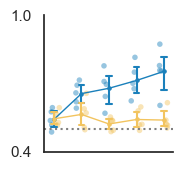

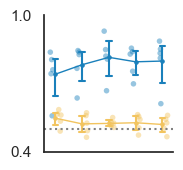

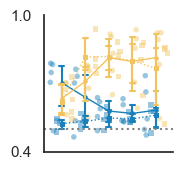

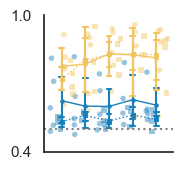

In [55]:
# Suplementary figure 6
df_scores=pd.DataFrame()
df_rats = pd.DataFrame()#initialize df for Behavioral sessions

df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<35)]
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict = loaded_data['behave_dict']
        filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
        filtered_dict['rats']=session_name[:4]
        filtered_dict['session_name'] = session_name
        filtered_dict['session_title'] = session_title
        filtered_dict['session_id'] = index
        df_temp = pd.DataFrame([filtered_dict])
        if df_rats.empty:
            df_rats = pd.DataFrame(columns=df_temp.columns)
        df_rats = pd.concat([df_rats,df_temp ], axis=0)

        cdnm_score=loaded_data['SVM2']['cdnm_rule']['score']
        disc_score=loaded_data['SVM2']['disc_rule']['score']
        cdnm_p=loaded_data['SVM2']['cdnm_rule']['p_value']
        disc_p=loaded_data['SVM2']['disc_rule']['p_value']
        cm_cdnm=loaded_data['SVM']['cdnm_rule']['cm_cdnm'][1][0]
        new_row = pd.DataFrame([{
            'session_name': session_name,
            'session_title': session_title,
            'session_title_idx': index,
            'cdnm_score': cdnm_score,
            'cdnm_p': cdnm_p,
            'disc_score': disc_score,
            'disc_p': disc_p,
            'cm_cdnm': cm_cdnm
        }])
        df_scores = pd.concat([df_scores, new_row], ignore_index=True)

df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)
melted_df = pd.melt(df_scores, id_vars=['session_title','session_title_idx','cm_cdnm'], value_vars=['cdnm_score', 'disc_score'])
melted_df['bin_column'] = melted_df['session_title_idx'].apply(categorize_into_bins)

data=melted_df[melted_df['session_title_idx']<35]
color_set = ["#1a80bb", "#f2c45f"]

def stouffer_p(series):
    clean_p = series.dropna()
    if len(clean_p) == 0:
        return float('nan')
    z_scores = norm.isf(clean_p)  # Convert p-values to Z-scores
    z_combined = np.sum(z_scores) / np.sqrt(len(z_scores))  # Combine Z-scores
    return norm.sf(z_combined)  # Convert back to p-value

# Apply Stouffer’s method for each group
stouffer_df = df_scores.groupby('session_title_idx').agg({
    'cdnm_p': stouffer_p,
    'disc_p': stouffer_p
}).reset_index()
n_tests = 60 
stouffer_df['cdnm_p_corrected'] = (stouffer_df['cdnm_p'] * n_tests).clip(upper=1.0)
stouffer_df['disc_p_corrected'] = (stouffer_df['disc_p'] * n_tests).clip(upper=1.0)

# --- tiny helper for nice alignment of raw points with hue dodge ---
def _x_positions(base_x, group_idx, n_groups, jitter=0.08, dodge=0.26):
    """
    base_x: array-like of x positions (numeric)
    group_idx: 0..(n_groups-1) for each hue group
    n_groups: number of hue levels shown at each x
    Returns jittered+dodged x positions.
    """
    base_x = np.asarray(base_x, float)
    offset = (group_idx - (n_groups - 1) / 2.0) * dodge
    return base_x + offset + np.random.uniform(-jitter, jitter, size=base_x.size)

# Create a new column "session_idx5" that cycles 1–5
# (session_title_idx % 5) gives 0–4, so add 1 to make it 1–5
melted_df["session_idx5"] = (melted_df["session_title_idx"] % 5) 

# ====== CASE 1: bins [1, 2] → two rules; raw points marker = 'o' ======
color_set = ["#1a80bb", "#f2c45f"]  # cdnm, disc

for i in [1, 2]:
    data = melted_df[melted_df.bin_column == i].copy()
    data['combined'] = data['variable'] + ' - Bin ' + data['bin_column'].astype(str)

    # Fix hue order so colors are stable: (cdnm, disc)
    hue_order = [f'cdnm_score - Bin {i}', f'disc_score - Bin {i}']

    # Mean ± SE via catplot
    g = sns.catplot(
        data=data, x="session_idx5", y="value",
        hue="combined", hue_order=hue_order,
        capsize=.2, palette=color_set,
        kind="point", height=2.2, aspect=1, estimator=np.mean,
        linestyles=["-", "-"], linewidth=1, markers=["o", "o"],
        err_kws={'linewidth': 1.5}, legend=False
    )
    ax = g.ax

    # --- Overlay raw datapoints (both hues, marker 'o') ---
    n_groups = len(hue_order)
    for gidx, grp in enumerate(hue_order):
        sub = data[data['combined'] == grp]
        if sub.empty:
            continue
        xj = _x_positions(sub['session_idx5'].values, gidx, n_groups, jitter=0.08, dodge=0.26)
        ax.scatter(
            xj, sub['value'].values,
            s=16, alpha=0.45, marker='o', color=color_set[gidx],
            edgecolors='none', zorder=1
        )

    # Cosmetics
    g.fig.tight_layout(w_pad=1); g.set_titles("")
    g.despine(left=False, bottom=False, top=True); g.refline(y=0.5, linestyle=":")
    g.set(ylabel='', xlabel='', xticks=[], title='', yticks=[.4, 1], ylim=(.4, 1))
    plt.show()
    g.fig.savefig(f'{fig_path}/S4a_{i}.png', dpi=300, bbox_inches="tight")


# ====== CASE 2: bins [4, 5] vs [7, 8] → two rules x two groups ======
# Colors repeated per rule: cdnm(blue) for both groups, disc(yellow) for both groups
color_set = ["#1a80bb", "#1a80bb", "#f2c45f", "#f2c45f"]  # [cdnm-exp, cdnm-ctrl, disc-exp, disc-ctrl]

for i in [4, 5]:
    data = melted_df[(melted_df.bin_column == i) | (melted_df.bin_column == i + 2)].copy()
    data['session_title_idx'] = data['session_title_idx'].apply(lambda x: x - 10 if x >= 25 else x)
    data['combined'] = data['variable'] + ' - Bin ' + data['bin_column'].astype(str)
    data["session_idx5"] = (data["session_title_idx"] % 5) 

    # Hue order: cdnm-exp(o), cdnm-ctrl(s), disc-exp(o), disc-ctrl(s)
    hue_order = [
        f'cdnm_score - Bin {i}',
        f'cdnm_score - Bin {i+2}',
        f'disc_score - Bin {i}',
        f'disc_score - Bin {i+2}',
    ]
    line_styles = ["-", ":", "-", ":"]    # solid for exp, dotted for control
    mean_markers = ["o", "s", "o", "s"]   # match your catplot config

    # Mean ± SE
    g = sns.catplot(
        data=data, x="session_idx5", y="value",
        hue="combined", hue_order=hue_order,
        capsize=.2, palette=color_set,
        kind="point", height=2.2, aspect=1, estimator=np.mean,
        linestyles=line_styles, linewidth=1, markers=mean_markers,
        err_kws={'linewidth': 1.5}, legend=False
    )
    ax = g.ax

    # --- Overlay raw datapoints ---
    # raw markers: 'o' for experimental (bin i), 's' for control (bin i+3)
    raw_markers = ["o", "s", "o", "s"]
    n_groups = len(hue_order)

    for gidx, grp in enumerate(hue_order):
        sub = data[data['combined'] == grp]
        if sub.empty:
            continue
        xj = _x_positions(sub['session_idx5'].values, gidx, n_groups, jitter=0.08, dodge=0.28)
        ax.scatter(
            xj, sub['value'].values,
            s=16, alpha=0.45, marker=raw_markers[gidx], color=color_set[gidx],
            edgecolors='none', zorder=1
        )

    # Cosmetics
    g.fig.tight_layout(w_pad=1); g.set_titles("")
    g.despine(left=False, bottom=False, top=True); g.refline(y=0.5, linestyle=":")
    g.set(ylabel='', xlabel='', xticks=[], title='', yticks=[.4, 1], ylim=(.4, 1))
    plt.show()
    g.fig.savefig(f'{fig_path}/S6a_{i}.png', dpi=300, bbox_inches="tight")


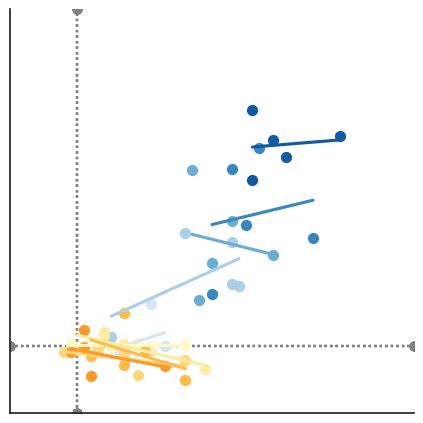

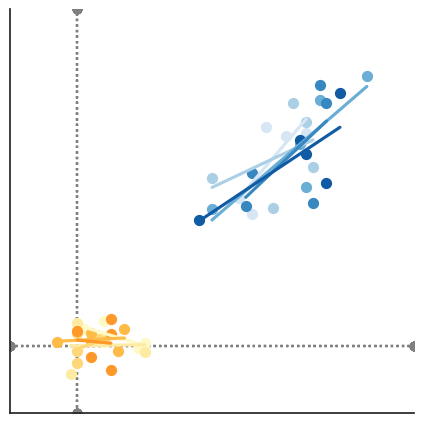

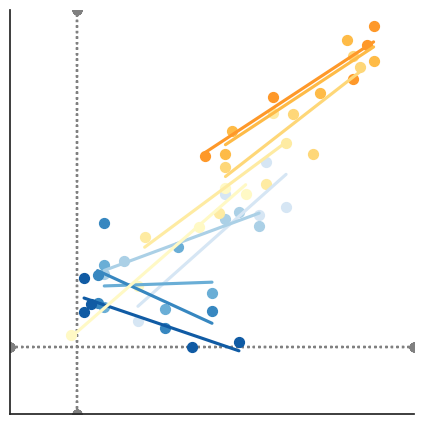

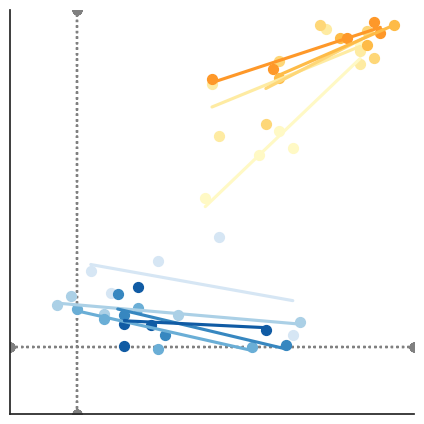

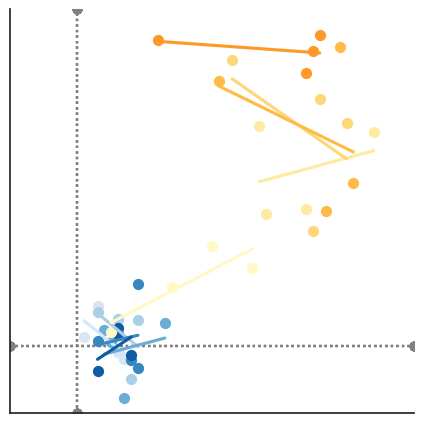

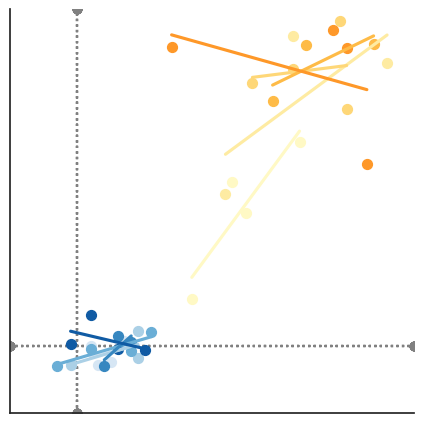

In [56]:
#Figure 7a-c
df=pd.DataFrame()
df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<35)]
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):

        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        cdnm_score= loaded_data['SVM']['cdnm_rule']['score']
        disc_score= loaded_data['SVM']['disc_rule']['score']
        cm_cdnm   = loaded_data["SVM"]["cdnm_rule"]["cm_cdnm"][1][0]
        correct_cdnm = loaded_data["behave_dict"]["correct_cdnm"]
        correct_disc = loaded_data["behave_dict"]["correct_disc"]
        rats = session_name[:4]

        new_row = pd.DataFrame([{
            'cm_cdnm': cm_cdnm,
            'rats': rats,
            'session_name': session_name,
            'session_title': session_title,
            'session_title_idx': index,
            'cdnm_score': cdnm_score,
            'correct_cdnm': correct_cdnm,
            'disc_score': disc_score,
            'correct_disc': correct_disc
        }])        
        df = pd.concat([df, new_row], ignore_index=True)


df['bin_column'] = df['session_title_idx'].apply(categorize_into_bins)

melted_df_both1 = pd.melt(df, id_vars=[ 'rats','session_title_idx','bin_column','cm_cdnm'], value_vars=['cdnm_score','disc_score'], var_name='score_type', value_name='score_value')
melted_df_both2 = pd.melt(df, id_vars=[ 'rats','session_title_idx','bin_column','cm_cdnm'], value_vars=['correct_cdnm','correct_disc'], var_name='correct_type', value_name='correct_value')
melted_df_both = pd.concat((melted_df_both1, melted_df_both2['correct_value']),axis=1)

melted_df_both['combined'] = melted_df_both['session_title_idx'].astype(str) + '_' + melted_df_both['score_type']

melted_df_both_2 = melted_df_both.sort_values(by=['bin_column','score_type'])
blue_palette = sns.color_palette("Blues",5)
yellow_palette = sns.color_palette("YlOrBr",9)
yellow_palette=yellow_palette[0:5]
both_palettes = blue_palette+yellow_palette

for i in [1,2,4,5,6,7]:
    data = melted_df_both_2[((melted_df_both_2.bin_column==i) ) ]


    g = sns.lmplot(
        data=data, x="score_value", y="correct_value", hue="combined",
        palette=both_palettes, ci=None,
        height=4.4, aspect=1, scatter_kws={"s": 50, "alpha": 1},
        legend=False                   # <- prevent legend creation (avoids the error)
    )
    
    # Set axis limits and ticks (keep ticks, drop labels)
    g.set(
        xlabel=None, ylabel=None, title='',
        xticks=[.4, 1], yticks=[.4, 1],
        xlim=(.4, 1), ylim=(.4, 1)
    )
    
    # Remove tick labels but keep tick marks
    for ax in g.axes.flatten():
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
    

    g.refline(x=.5,y=0.5,linestyle=":",zorder=0)
    
    g.savefig(f"{fig_path}/7ac{i}.png", dpi=300, bbox_inches="tight")


df_f = df[(df.session_title_idx>=15)  & (df.session_title_idx<25)]




In [57]:
# fig 7 statistics
stages = [0,1,2,3,4]
# stages = [5,6,7,8,9]
# stages = [15,16,17,18,19]
# stages = [20,21,22,23,24]
# stages = [30, 31,32,33,34]
# stages = [35, 36,37,38,39]


filtered_df = melted_df_both_2[
    (melted_df_both_2['score_type'] == 'cdnm_score') &
    (melted_df_both_2['session_title_idx'].astype(int).isin(stages))
    ].copy()
model_simple_cdnm = smf.ols('correct_value ~ score_value', data=filtered_df).fit()
print(model_simple_cdnm.summary())

model_interaction_cdnm = smf.ols('correct_value ~ score_value * session_title_idx', data=filtered_df).fit()
print(model_interaction_cdnm.summary())

filtered_df = melted_df_both_2[
    (melted_df_both_2['score_type'] == 'disc_score') &
    (melted_df_both_2['session_title_idx'].astype(int).isin(stages))
    ].copy()
model_simple_disc = smf.ols('correct_value ~ score_value', data=filtered_df).fit()
print(model_simple_disc.summary())

model_interaction_disc = smf.ols('correct_value ~ score_value * session_title_idx', data=filtered_df).fit()
print(model_interaction_disc.summary())

stages = [15,16,17,18,19]
#stages = [20,21,22,23,24]
#stages = [30,31,32,33,34]
#stages = [35,36,37,38,39]
# Step 1: Filter for 'cdnm_score'
filtered_df = melted_df_both_2[
    (melted_df_both_2['score_type'] == 'cdnm_score') &
    (melted_df_both_2['session_title_idx'].astype(int).isin(stages))
    ].copy()
model_simple = smf.ols('correct_value ~ score_value', data=filtered_df).fit()
print(model_simple.summary())

model_interaction = smf.ols('correct_value ~ score_value * session_title_idx', data=filtered_df).fit()
print(model_interaction.summary())
early_bins = [15, 16]
late_bins = [17, 18, 19]

df2 = filtered_df.copy()
df2 = df2[df2['session_title_idx'].isin(early_bins + late_bins)]
df2['is_late'] = df2['session_title_idx'].apply(lambda x: 1 if x in late_bins else 0)

import statsmodels.formula.api as smf

model = smf.ols('correct_value ~ score_value * is_late', data=df2).fit()
print(model.summary())
import statsmodels.api as sm

def analyze_session_slopes(df, early_sessions, late_sessions,
                           xvar="score_value", yvar="correct_value", session_col="session_title_idx"):
    """
    Fit per-session regressions of behavior ~ decoder accuracy
    and compare early vs late sessions.
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns [xvar, yvar, session_col].
    early_sessions, late_sessions : list
        Session indices or labels to split groups.
    xvar, yvar, session_col : str
        Column names for predictor, outcome, and session identifier.
    """

    slopes = {}
    correlations = {}

    for session, subdf in df.groupby(session_col):
        X = sm.add_constant(subdf[xvar])
        y = subdf[yvar]
        model = sm.OLS(y, X).fit()
        slopes[session] = model.params[xvar]

        r, _ = stats.pearsonr(subdf[xvar], subdf[yvar])
        correlations[session] = r

    # mean slopes for early and late
    early_slopes = [slopes[s] for s in early_sessions if s in slopes]
    late_slopes = [slopes[s] for s in late_sessions if s in slopes]

    early_corrs = [correlations[s] for s in early_sessions if s in correlations]
    late_corrs = [correlations[s] for s in late_sessions if s in correlations]

    # Fisher z-test for correlation difference
    if early_corrs and late_corrs:
        r1, r2 = np.mean(early_corrs), np.mean(late_corrs)
        n1 = sum([len(df[df[session_col] == s]) for s in early_sessions if s in correlations])
        n2 = sum([len(df[df[session_col] == s]) for s in late_sessions if s in correlations])

        z1 = np.arctanh(r1)
        z2 = np.arctanh(r2)
        se = np.sqrt(1/(n1-3) + 1/(n2-3))
        z_stat = (z1 - z2) / se
        p_val = 2*(1 - stats.norm.cdf(abs(z_stat)))
    else:
        z_stat, p_val = np.nan, np.nan

    # Bootstrap slope difference
    n_boot = 5000
    boot_diffs = []
    all_sessions = early_sessions + late_sessions
    df_sub = df[df[session_col].isin(all_sessions)]

    for _ in range(n_boot):
        boot = df_sub.sample(frac=1, replace=True)
        slopes_boot = {}
        for session, subdf in boot.groupby(session_col):
            X = sm.add_constant(subdf[xvar])
            y = subdf[yvar]
            model = sm.OLS(y, X).fit()
            slopes_boot[session] = model.params[xvar]
        es = np.mean([slopes_boot.get(s, np.nan) for s in early_sessions])
        ls = np.mean([slopes_boot.get(s, np.nan) for s in late_sessions])
        boot_diffs.append(es - ls)

    ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])

    results = {
        "slopes": slopes,
        "correlations": correlations,
        "early_mean_slope": np.mean(early_slopes),
        "late_mean_slope": np.mean(late_slopes),
        "slope_diff_boot_CI": (ci_low, ci_high),
        "fisher_z_stat": z_stat,
        "fisher_p": p_val
    }

    return results

early = [15,16]   # indices for early sessions
late  = [17,18,19]   # indices for late sessions
results = analyze_session_slopes(filtered_df, early, late)
print(results)


                            OLS Regression Results                            
Dep. Variable:          correct_value   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     30.75
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           1.22e-05
Time:                        13:41:11   Log-Likelihood:                 30.112
No. Observations:                  25   AIC:                            -56.22
Df Residuals:                      23   BIC:                            -53.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0381      0.125     -0.304      

                            OLS Regression Results                            
Dep. Variable:                cm_cdnm   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     11.98
Date:                Mon, 15 Dec 2025   Prob (F-statistic):            0.00154
Time:                        13:41:51   Log-Likelihood:                 10.913
No. Observations:                  34   AIC:                            -17.83
Df Residuals:                      32   BIC:                            -14.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0208      0.203      0.103      0.9

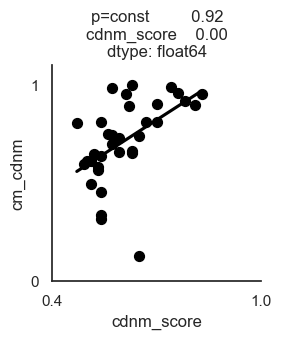

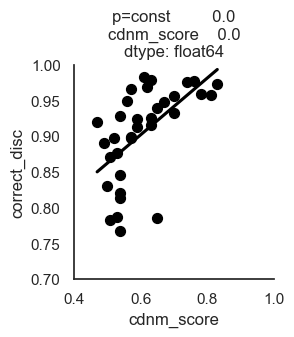

In [58]:
#Figure 7-d-e

df_f = df[(df.session_title_idx>=17)  & (df.session_title_idx<25) & (df.session_title_idx!=20)]

x_param='cdnm_score'
y_param='cm_cdnm'

g = sns.lmplot(
    data=df_f, x=x_param, y=y_param,
    height=3, scatter_kws={"s": 50, "alpha": 1,'color': 'black'},ci=None,
    line_kws={'color': 'black'})
g.set(xlim=(0.4, 1), ylim=(0, 1.2))
g.set(ylabel=y_param,xlabel=x_param,title = '',xticks = [.4,1],yticks = [0,1], ylim=(0, 1.1), xlim=(.4, 1))

X = sm.add_constant(df_f[x_param])
y = df_f[y_param]
model = sm.OLS(y, X).fit()

plt.title(f'p={np.round(model.pvalues,2)}')
g.despine(left=False, bottom=False, top=True)

g.savefig(f"{fig_path}/7d.png", dpi=300, bbox_inches="tight")

#g.savefig(f'{save_path}/ignore_prob.png', dpi=300, bbox_inches='tight')
model = smf.ols('cm_cdnm ~ cdnm_score', data=df_f).fit()
print(model.summary())

x_param='cdnm_score'
y_param='correct_disc'

g = sns.lmplot(
    data=df_f, x=x_param, y=y_param,
    height=3, scatter_kws={"s": 50, "alpha": 1,'color': 'black'},ci=None,
    line_kws={'color': 'black'})
g.set(xlim=(0.4, 1), ylim=(0.7, 1))


g.set(ylabel=y_param,xlabel=x_param,title = '', ylim=(0.7, 1), xlim=(.4, 1))

X = sm.add_constant(df_f[x_param])
y = df_f[y_param]
model = sm.OLS(y, X).fit()

plt.title(f'p={np.round(model.pvalues,2)}')
g.savefig(f"{fig_path}/7e.png", dpi=300, bbox_inches="tight")

# Fit linear model with interaction
model = smf.ols('correct_disc ~ cdnm_score', data=df_f).fit()

# Print model summary
print(model.summary())
#df_f.to_excel(f"{fig_path}/fig7de_raw.xlsx", index=False)


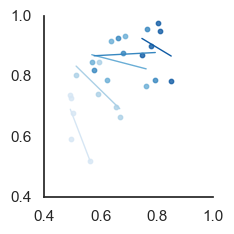

In [59]:
#Figure 7-f

from scipy.stats import linregress, pearsonr

#sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(2.5,2.5))
ax = plt.gca()
colors = sns.color_palette("Blues",5)
lines = []

# loop over stages (0–4 early, 15–19 late)
for i, (early, late) in enumerate(zip(range(0, 5), range(15, 20))):
    # extract matching subsets
    x = df.loc[df['session_title_idx'] == early, 'correct_cdnm'].reset_index(drop=True)
    y = df.loc[df['session_title_idx'] == late,  'correct_disc'].reset_index(drop=True)

    # align lengths
    n = min(len(x), len(y))
    x, y = x.iloc[:n], y.iloc[:n]
    if n < 3:  # skip if too few points
        continue

    # correlation and regression
    r, p_corr = pearsonr(x, y)
    slope, intercept, r_value, p_slope, stderr = linregress(x, y)

    # scatter points
    ax.scatter(x, y, s=10, color=colors[i], alpha=0.8, label=f"{early}→{late} (r={r:.2f}, p={p_corr:.3g})")

    # regression line (no shaded CI)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, intercept + slope*x_line, color=colors[i], linewidth=1)

    lines.append(f"{early}→{late}: r={r:.2f}, p={p_corr:.3g}")

# axis labels and style
# ax.set_xlabel("correct_cdnm (early sessions 0–4)")
# ax.set_ylabel("correct_disc (late sessions 15–19)")
ax.set_ylim([0.4,1])
ax.set_xlim([0.4,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# legend
#ax.legend(frameon=True, fontsize=9, loc='best')

# # annotation of all r,p
# ax.text(0.02, 0.98, "\n".join(lines), transform=ax.transAxes, va='top', ha='left',
#         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.5"))

plt.tight_layout()
plt.savefig(f"{fig_path}/7f.png", dpi=300, bbox_inches="tight")
plt.show()


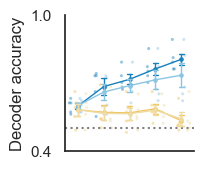

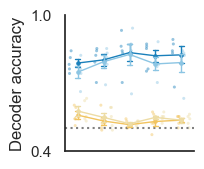

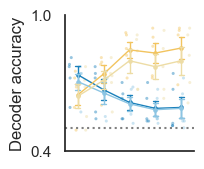

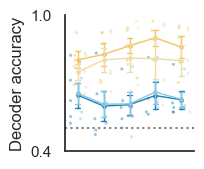

In [60]:
# Suplementary figure 6b

color_set = ["#1a80bb","#f2c45f", "#8cc5e3","#eddca5"]
df_scores=pd.DataFrame()
df_rats = pd.DataFrame()  # initialize df for Behavioral sessions
df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<35)]

for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']

    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict = loaded_data['behave_dict']
        filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
        filtered_dict['rats']=session_name[:4]
        filtered_dict['session_name'] = session_name
        filtered_dict['session_title'] = session_title
        filtered_dict['session_id'] = index
        df_temp = pd.DataFrame([filtered_dict])
        if df_rats.empty:
            df_rats = pd.DataFrame(columns=df_temp.columns)
        df_rats = pd.concat([df_rats, df_temp], axis=0)

        cdnm_score = loaded_data['SVM']['cdnm_rule']['score']
        disc_score = loaded_data['SVM']['disc_rule']['score']
        cdnm_r     = loaded_data['SVM']['cdnm_rule']['score_reg']
        disc_r     = loaded_data['SVM']['disc_rule']['score_reg']

        new_row = pd.DataFrame([{
            'session_name': session_name,
            'session_title': session_title,
            'session_title_idx': index,
            'cdnm_score': cdnm_score,
            'disc_score': disc_score,
            'cdnm_score_post_reg': cdnm_r,
            'disc_score_post_reg': disc_r
        }])
        df_scores = pd.concat([df_scores, new_row], ignore_index=True)

df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)
melted_df = pd.melt(
    df_scores,
    id_vars=['session_title','session_title_idx'],
    value_vars=['cdnm_score', 'disc_score', 'cdnm_score_post_reg', 'disc_score_post_reg'],
    var_name='variable', value_name='value'
)
melted_df['bin_column'] = melted_df['session_title_idx'].apply(categorize_into_bins)

# Consistent hue order so colors match across plots
hue_order = ['cdnm_score', 'disc_score', 'cdnm_score_post_reg', 'disc_score_post_reg']

for i in [1, 2, 4, 5]:

    data = melted_df[(melted_df.bin_column == i)]

    # Mean ± SE lines/points
    g = sns.catplot(
        data=data, x="session_title_idx", y="value",
        hue="variable", hue_order=hue_order,
        capsize=.2, palette=color_set, errorbar="se",
        kind="point", height=2.2, aspect=1,
        estimator=np.mean, legend=False,linewidth=1, 
        zorder=10
    )

    ax = g.ax

    # --- Overlay individual datapoints (background) ---
    sns.stripplot(
        data=data, x="session_title_idx", y="value",
        hue="variable", hue_order=hue_order,
        dodge=True, jitter=0.18, size=2.2,
        alpha=0.45, palette=color_set,
        linewidth=0, ax=ax, zorder=1
    )

    # Remove duplicate legend created by stripplot
    if ax.legend_ is not None:
        ax.legend_.remove()

    # Formatting (same as yours)
    g.fig.tight_layout(w_pad=1)
    g.set_titles("")
    g.despine(left=False, bottom=False, top=True)
    g.refline(y=0.5, linestyle=":")
    g.set(ylabel='Decoder accuracy', xlabel='', xticks=[], title='', yticks=[.4, 1], ylim=(.4, 1))

    plt.show()
    g.savefig(f"{fig_path}/S4b{i}.png", dpi=300, bbox_inches="tight")

# melted_df_remap = remap_df(melted_df)
# melted_df_remap.to_excel(f"{fig_path}/S6b_raw.xlsx", index=False)


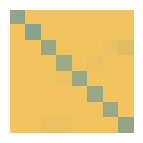

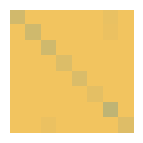

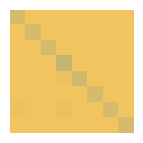

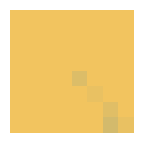

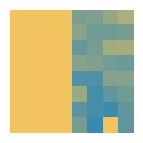

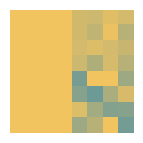

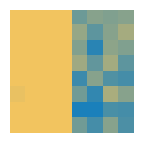

In [61]:
# Fig. 8
dreadd_path = f"{save_path}/DREADD_summery.csv"

# Load the combined analysys table of all rats in the inactivation experiment
import pandas as pd
combined_analysis_table = pd.read_csv(dreadd_path)

grouped = combined_analysis_table.groupby(['subject', 'session'])
# --- Prepare to store results
results_dict = {}
df_rats = pd.DataFrame()
Big_Analysis_table_mode= pd.DataFrame()
for (subject, session), analysis_table in grouped:
    behave_dict = analyze_behave(analysis_table)
    results_dict[(subject, session)] = behave_dict
    filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
    filtered_dict['rats']=subject
    filtered_dict['session_name'] = f'{subject}-{session}'
    filtered_dict['session_title'] = analysis_table['Problem'].iloc[0]
    filtered_dict['session_id'] = session
    filtered_dict['Group'] = analysis_table['Group'].iloc[0]
    filtered_dict['Sex'] = analysis_table['Sex'].iloc[0]

    df = pd.DataFrame([filtered_dict])
    if df_rats.empty:
        df_rats = pd.DataFrame(columns=df.columns)
    df_rats = pd.concat([df_rats,df ], axis=0)

    Analysis_table_f = behave_dict['Analysis_table_mod']
    Analysis_table_f['rats'] = subject
    Analysis_table_f['session_name'] = f'{subject}-{session}'
    Analysis_table_f['session_title'] = analysis_table['Problem'].iloc[0]
    Analysis_table_f['session_id'] = session
    Analysis_table_f['Group'] = analysis_table['Group'].iloc[0]

    if Big_Analysis_table_mode.empty:
        Big_Analysis_table_mode = pd.DataFrame(columns=Analysis_table_f.columns)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        Big_Analysis_table_mode = pd.concat([Big_Analysis_table_mode, Analysis_table_f], axis=0)
        
import matplotlib.colors as mcolors
plt.rcParams['axes.grid'] = False        # Disable grid lines globally
plt.rcParams['axes.linewidth'] = 1    # Make axes thicker
plt.rcParams['axes.edgecolor'] = 'black' # Make axes darker

colors = ["#1a80bb", "#f2c45f"]  # Blue to orange shades
num_colors = 100
blue_to_orange = mcolors.LinearSegmentedColormap.from_list("BlueToOrange", colors, N=num_colors)
odor_means =Big_Analysis_table_mode.groupby(['Group','session_id','odor_before','odor_ID']).go_nogo.mean()

l_values = [5, 6, 10, 11, 15, 16, 20]
#excel_path = os.path.join(fig_path, "go_odors_all_exp.xlsx")  # one workbook for all matrices

for l in l_values:
    # ---- 1) Extract matrix for this session ----
    # Keep as DataFrame so it stays 2D (with numeric headers stripped for clean Excel)
    df_mat = odor_means.loc[('Experiment', l, slice(None), slice(None))].unstack()
    # If the result isn't a plain DataFrame already, wrap it:
    df_mat = pd.DataFrame(df_mat)

    # ---- 2) Plot & save heatmap image ----
    fig, ax = plt.subplots(figsize=(1.6, 1.6))
    ax.imshow(df_mat.values, cmap=blue_to_orange, interpolation='nearest', vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for sp in ['top', 'right', 'bottom', 'left']:
        ax.spines[sp].set_visible(False)
    fig.savefig(os.path.join(fig_path, f"go_ratio_Exp{l}.png"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)




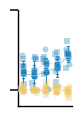

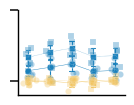

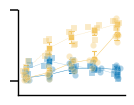

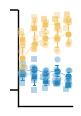

In [62]:
plt.rcParams['axes.grid'] = False        # Disable grid lines globally
plt.rcParams['axes.linewidth'] = 1    # Make axes thicker
plt.rcParams['axes.edgecolor'] = 'black' # Make axes darker
# Update matplotlib settings so ticks are always drawn
plt.rcParams.update({
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False
})

fig_path = '/Users/maori2/Documents/revision_stuff/new_figures'
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Learning curves exp+control combined Figure 2g
def categorize_into_bins(value):
    bins = [1, 6, 11, 16, 21]
    labels = [1, 2, 3, 4]
    return pd.cut([value], bins=bins, labels=labels, right=False)[0]

def find_first_index(df_group): # Custom function to find the first index in vehave_crit where Value = 1
    index = (df_group['behave_crit'] == 1).idxmax()
    return index if not (index==0 or pd.isna(index)) else 500
df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)


df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=['Group', 'Sex','rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')
melted_df["hue_combo"] = melted_df["score_type"] + "_" + melted_df["Group"]
color_set = ["#1a80bb","#1a80bb","#f2c45f","#f2c45f"]
melted_df_f = melted_df.copy()

# Map session_id 1–20 → 1–5 repeating
melted_df_f["session_id"] = melted_df_f["session_id"].map(
    lambda x: x % 5 if x % 5 != 0 else 5
)

for i in range(1, 5):
    data = melted_df_f[melted_df_f["bin_column"]==i]
    g = sns.catplot(
        data=data, x="session_id", y="score_value", hue="hue_combo",
        palette=color_set,
        kind="point", height=1.8, aspect=1.4,
        estimator=np.mean, capsize=.2,
        linestyles=["-", ":", "-", ":"],
        markers=["o", "s", "o", "s"],
        linewidth=1,
        err_kws={'linewidth': 1.0}
    )
    ax = g.axes.flat[0]

    # Overlay raw points manually with custom markers
    markers = ["o", "s", "o", "s"]
    for (hue_level, marker, color) in zip(data["hue_combo"].unique(), markers, color_set):
        subset = data[data["hue_combo"] == hue_level]
        # jitter for visibility
        x_positions = subset["session_id"] + (np.random.randn(len(subset)) * 0.1) -1
        ax.scatter(
            x_positions, subset["score_value"],
            marker=marker, facecolors=color, edgecolors="none",
            s=20, alpha=0.35, zorder=1
        )

    # 1) Line2D markers (one artist holds line+markers)
    for line in ax.findobj(mpl.lines.Line2D):
        mk = line.get_marker()
        if not mk or mk == "None":
            continue  # skip pure lines / caplines
        col = line.get_color()
        line.set_linewidth(0.3)
        line.set_markersize(5)            # small, but big enough to see edge
        line.set_markerfacecolor(col)
        line.set_markeredgecolor("w")   # <— edge color
        line.set_markeredgewidth(0.4)
        line.set_zorder(10)
    for ln in ax.lines:
        if ln.get_marker() in [None, "None", ""]:   # pure lines (not markers)
            ln.set_linewidth(0.8)                   # make them thin

    # 2) Collection-based markers (some seaborn versions/themes use these)
    # PathCollection (scatter-like) or LineCollection (errorbars)
    for coll in ax.collections:
        # Thin the errorbar strokes
        try:
            coll.set_linewidths([0.3])
        except Exception:
            pass
        # If this collection holds the markers, set its edge
        if isinstance(coll, mpl.collections.PathCollection):
            try:
                coll.set_edgecolor("w")   # <— edge color
                coll.set_linewidth(0.3)
                coll.set_zorder(10)

            except Exception:
                pass

   
    leg = ax.get_legend()
    if leg: leg.remove()
    g.set_titles("")
    g.despine(left=False, bottom=False, top=True, right=True)
    g.set(ylabel="", xlabel="", xticks=[], yticks=[.5, 1.0], ylim=(.4, 1.0), yticklabels=[])
    g._legend.remove()
    #plt.colorbar()
    g.savefig(f"{fig_path}/8_{i}.png", dpi=300, bbox_inches="tight")

# 

=== Type II ANOVA (Full 4-way model) ===
                                   sum_sq     df          F        PR(>F)
Group                            0.194262    1.0  84.639401  1.801146e-17
Sex                              0.008665    1.0   3.775396  5.318096e-02
session_id                       1.863698   19.0  42.737187  5.961428e-66
score_type                       0.064266    1.0  28.000579  2.733421e-07
Group:Sex                        0.004237    1.0   1.846169  1.755052e-01
Group:session_id                 0.121943   19.0   2.796314  1.473357e-04
Sex:session_id                   0.036838   19.0   0.844738  6.519656e-01
Group:score_type                 0.026146    1.0  11.391720  8.602329e-04
Sex:score_type                   0.004767    1.0   2.076757  1.508611e-01
session_id:score_type            3.441760   19.0  78.924357  9.298774e-92
Group:Sex:session_id             0.024491   19.0   0.561609  9.301922e-01
Group:Sex:score_type             0.001118    1.0   0.487232  4.858404e-

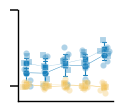

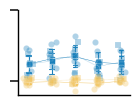

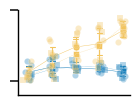

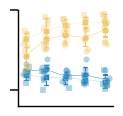

In [63]:
# by sex
# Analyze DREADD data
plt.rcParams['axes.grid'] = False        # Disable grid lines globally
plt.rcParams['axes.linewidth'] = 1    # Make axes thicker
plt.rcParams['axes.edgecolor'] = 'black' # Make axes darker
# Update matplotlib settings so ticks are always drawn
plt.rcParams.update({
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False
})

import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Learning curves exp+control combined Figure 2g
def categorize_into_bins(value):
    bins = [1, 6, 11, 16, 21]
    labels = [1, 2, 3, 4]
    return pd.cut([value], bins=bins, labels=labels, right=False)[0]

def find_first_index(df_group): # Custom function to find the first index in vehave_crit where Value = 1
    index = (df_group['behave_crit'] == 1).idxmax()
    return index if not (index==0 or pd.isna(index)) else 500
df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)


df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=['Group', 'Sex','rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')
melted_df["hue_combo"] = melted_df["score_type"] + "_" + melted_df["Sex"]
color_set = ["#1a80bb","#1a80bb","#f2c45f","#f2c45f"]

#melted_df_f = melted_df[melted_df['Group'] == 'Control'].copy()
melted_df_f = melted_df.copy()

# Map session_id 1–20 → 1–5 repeating
melted_df_f["session_id"] = melted_df_f["session_id"].map(
    lambda x: x % 5 if x % 5 != 0 else 5
)

for i in range(1, 5):
    data = melted_df_f[melted_df_f["bin_column"]==i]
    g = sns.catplot(
        data=data, x="session_id", y="score_value", hue="hue_combo",
        palette=color_set,
        kind="point", height=1.8, aspect=1.4,
        estimator=np.mean, capsize=.2,
        linestyles=["-", ":", "-", ":"],
        markers=["o", "s", "o", "s"],
        linewidth=1,   # <-- force thin connecting lines
        err_kws={'linewidth': 1.0}
    )

    ax = g.axes.flat[0]


    # Overlay raw points manually with custom markers
    markers = ["o", "s", "o", "s"]
    for (hue_level, marker, color) in zip(data["hue_combo"].unique(), markers, color_set):
        subset = data[data["hue_combo"] == hue_level]
        # jitter for visibility
        x_positions = subset["session_id"] + (np.random.randn(len(subset)) * 0.1) -1
        ax.scatter(
            x_positions, subset["score_value"],
            marker=marker, facecolors=color, edgecolors="none",
            s=20, alpha=0.35, zorder=1
        )

    # 1) Line2D markers (one artist holds line+markers)
    for line in ax.findobj(mpl.lines.Line2D):
        mk = line.get_marker()
        if not mk or mk == "None":
            continue  # skip pure lines / caplines
        col = line.get_color()
        line.set_linewidth(0.3)
        line.set_markersize(5)            # small, but big enough to see edge
        line.set_markerfacecolor(col)
        line.set_markeredgecolor("w")   # <— edge color
        line.set_markeredgewidth(0.4)
        line.set_zorder(10)
    for ln in ax.lines:
        if ln.get_marker() in [None, "None", ""]:   # pure lines (not markers)
            ln.set_linewidth(0.8)                   # make them thin

    # 2) Collection-based markers (some seaborn versions/themes use these)
    # PathCollection (scatter-like) or LineCollection (errorbars)
    for coll in ax.collections:
        # Thin the errorbar strokes
        try:
            coll.set_linewidths([0.3])
        except Exception:
            pass
        # If this collection holds the markers, set its edge
        if isinstance(coll, mpl.collections.PathCollection):
            try:
                coll.set_edgecolor("w")   # <— edge color
                coll.set_linewidth(0.3)
                coll.set_zorder(10)

            except Exception:
                pass

    # (Optional) sanity test: try black edges once to verify you can see them
    # for line in ax.findobj(mpl.lines.Line2D):
    #     if line.get_marker() not in [None, "None", ""]:
    #         line.set_markeredgecolor("black")

    # cleanup
    leg = ax.get_legend()
    if leg: leg.remove()
    g.set_titles("")
    g.despine(left=False, bottom=False, top=True, right=True)
    g.set(ylabel="", xlabel="", xticks=[], yticks=[.5, 1.0], ylim=(.4, 1.0), yticklabels=[])
    g._legend.remove()
    #plt.colorbar()
    g.savefig(f"{fig_path}/R1_{i}.png", dpi=300, bbox_inches="tight")

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# --- Fit the full model and print ANOVA (Type II) ---
model = ols("score_value ~ Group * Sex * session_id * score_type", data=melted_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("=== Type II ANOVA (Full 4-way model) ===")
print(anova_table)

# Extract p-value for the three-way interaction of interest (optional gate)
term_name = 'Sex:session_id:score_type'
p_threeway = anova_table.loc[term_name, 'PR(>F)'] if term_name in anova_table.index else np.nan
print(f"\nP-value for {term_name}: {p_threeway}")

# --- Posthoc for Sex within each (session_id × score_type) cell ---
def posthoc_sex_by_session_and_scoretype(df, alpha=0.05, require_min_n_per_group=1, apply_global_holm=True):
    """
    For each combination of session_id and score_type:
      - Run Tukey HSD on Sex groups (score_value as outcome).
      - Collect results into a tidy DataFrame.
    Optionally apply Holm-Bonferroni across ALL Tukey p-values to control familywise error across sessions.
    """
    results = []

    # Make sure required columns exist
    needed_cols = {'score_value', 'Sex', 'session_id', 'score_type'}
    missing = needed_cols - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame missing required columns: {missing}")

    # Ensure categorical handling for clean outputs (recommended)
    df = df.copy()
    df['Sex'] = df['Sex'].astype('category')
    df['score_type'] = df['score_type'].astype('category')

    # Iterate over cells of (session_id × score_type)
    for st in sorted(df['score_type'].unique()):
        for sess in np.sort(df['session_id'].unique()):
            sub = df[(df['score_type'] == st) & (df['session_id'] == sess)].dropna(subset=['score_value', 'Sex'])

            # Need at least 2 Sex levels and minimal sample per level
            if sub['Sex'].nunique() < 2:
                continue
            if sub.groupby('Sex').size().min() < require_min_n_per_group:
                continue

            # Tukey HSD within this cell
            tukey = pairwise_tukeyhsd(endog=sub['score_value'], groups=sub['Sex'], alpha=alpha)

            # Extract table rows (skip header row)
            tbl = tukey._results_table.data
            header, rows = tbl[0], tbl[1:]

            # Optional: compute group means to include for context
            means = sub.groupby('Sex')['score_value'].mean().to_dict()
            ns = sub.groupby('Sex')['score_value'].size().to_dict()

            for r in rows:
                # r = [group1, group2, meandiff, p-adj, lower, upper, reject]
                g1, g2, meandiff, p_adj, lower, upper, reject = r
                results.append({
                    'session_id': sess,
                    'score_type': st,
                    'contrast': f'{g1} vs {g2}',
                    'group1': g1,
                    'group2': g2,
                    'mean_group1': means.get(g1, np.nan),
                    'mean_group2': means.get(g2, np.nan),
                    'n_group1': ns.get(g1, np.nan),
                    'n_group2': ns.get(g2, np.nan),
                    'mean_diff': meandiff,
                    'ci_low': lower,
                    'ci_high': upper,
                    'p_adj_tukey_within_cell': p_adj,     # Tukey-adjusted within this cell
                    'reject_tukey_within_cell': bool(reject),
                })

    if not results:
        return pd.DataFrame(columns=[
            'session_id','score_type','contrast','group1','group2',
            'mean_group1','mean_group2','n_group1','n_group2',
            'mean_diff','ci_low','ci_high',
            'p_adj_tukey_within_cell','reject_tukey_within_cell',
            'p_holm_global','reject_holm_global'
        ])

    out = pd.DataFrame(results)

    # Optionally apply Holm-Bonferroni across ALL tests to control familywise error across sessions
    if apply_global_holm:
        rej, p_holm, _, _ = multipletests(out['p_adj_tukey_within_cell'].values, alpha=alpha, method='holm')
        out['p_holm_global'] = p_holm
        out['reject_holm_global'] = rej
    else:
        out['p_holm_global'] = np.nan
        out['reject_holm_global'] = np.nan

    # Sort nicely
    out = out.sort_values(['score_type', 'session_id', 'contrast']).reset_index(drop=True)
    return out

# Run posthoc specifically for Sex across (session_id × score_type)
print("\n=== Posthoc for Sex within each (session_id × score_type) cell ===")
posthoc_df = posthoc_sex_by_session_and_scoretype(
    melted_df,
    alpha=0.05,
    require_min_n_per_group=1,   # increase to 2 if you want ≥2 observations per Sex
    apply_global_holm=True       # set to False if you don't want across-cells multiplicity control
)

cols_to_show = [
    'score_type','session_id','contrast',
    'mean_group1','mean_group2','n_group1','n_group2',
    'mean_diff','ci_low','ci_high',
    'p_adj_tukey_within_cell','reject_tukey_within_cell',
    'p_holm_global','reject_holm_global'
]
print(posthoc_df[cols_to_show].to_string(index=False))
